In [153]:
from thesis import SAVED_RESULTS_PATH
from typing import List, Optional
import pandas as pd
from pandas import DataFrame
import numpy as np
import matplotlib.pyplot as plt
from thesis import ROOT


BASELINE_METRICS = ['DEGs', 'r2mean_all_boostrap_mean', 'r2mean_top20_boostrap_mean', 'r2mean_top100_boostrap_mean']
DISTANCE_METRICS = ['edistance', 'wasserstein', 'euclidean', 'mean_pairwise', 'mmd']
METRICS = BASELINE_METRICS + DISTANCE_METRICS

FIGURES_PATH = SAVED_RESULTS_PATH / "multi_task_aae_eval" / "figures"

In [154]:
all_df = pd.read_csv(ROOT / "analysis" / "multi_task_aae.csv")
all_df_overview = pd.read_csv(ROOT / "analysis" / "multi_task_aae_overview.csv")

all_df = pd.read_csv(ROOT / "saved_results" / "metrics.csv")

METRICS_DF = all_df
METRICS_DF_OVERVIEW = all_df_overview
MODELS = [
    "ButterflyPipeline",
    "ScGenPipeline",
    "MultiTaskAaeAutoencoderPipeline",
    "MultiTaskAaeAdversarialPipeline",
    "MultiTaskAaeAdversarialGaussianPipeline",
    "MultiTaskAaeAutoencoderOptimalTransportPipeline",
    "MultiTaskAaeAutoencoderAndOptimalTransportPipeline",
    "MultiTaskVaeAutoencoderPipeline",
    "MultiTaskVaeAutoencoderOptimalTransportPipeline",
    "MultiTaskVaeAutoencoderAndOptimalTransportPipeline"
]

In [155]:
# check variability between seeds
dataset_model = METRICS_DF[METRICS_DF['model'] == 'MultiTaskAaeAutoencoderPipeline']
dataset_model = dataset_model[dataset_model["cell_type_test"] == "Hepatocytes - portal"]
dataset_model = dataset_model[dataset_model["dose"] == 30]
dataset_model = dataset_model[dataset_model["experiment_name"].isin(["seed_1", "seed_2", "seed_19193"])]
dataset_model


model                              dataset  \
4063  MultiTaskAaeAutoencoderPipeline  NaultMultiplePipeline_NaultPipeline   
4288  MultiTaskAaeAutoencoderPipeline  NaultMultiplePipeline_NaultPipeline   
7506  MultiTaskAaeAutoencoderPipeline  NaultMultiplePipeline_NaultPipeline   

     experiment_name perturbation  dose  DEGs  r2mean  r2mean_top20  \
4063          seed_1         tcdd  30.0    34   0.669         0.805   
4288          seed_2         tcdd  30.0     8   0.599         0.741   
7506      seed_19193         tcdd  30.0    24   0.650         0.785   

      r2mean_top100  r2mean_all_boostrap_mean  ...        cell_type_test  \
4063          0.887                  0.668259  ...  Hepatocytes - portal   
4288          0.857                  0.598458  ...  Hepatocytes - portal   
7506          0.876                  0.649145  ...  Hepatocytes - portal   

      average_mean_expressed_diff average_fractions_diff  \
4063                     0.763647               0.217056   
4288                     0.764387               0.207234   
7506                     0.775634               0.214651   

      average_mean_degs20_diff  average_mean_degs100_diff  edistance  \
4063                  0.709829                   0.782503   6.948559   
4288                  0.775776                   0.807551  19.930629   
7506                  0.746439                   0.802481  10.105387   

      wasserstein  euclidean  mean_pairwise        mmd  
4063     3.580094   2.636011       1.838861   6.948558  
4288     4.986872   4.464366       2.188280  19.930634  
7506     4.013452   3.178895       1.951821  10.105391  

[3 rows x 22 columns]

In [224]:
def _plot_2d_metrics(
    dataset: DataFrame,
    title: str,
    x_labels: List[str],
    metrics: List[str] = BASELINE_METRICS,
    models=MODELS,
    file_name_to_save: Optional[str] = None,
):
    x = np.arange(len(x_labels))
    width = 0.08
    
    nrows = int(np.ceil(len(metrics) / 2))

    fig, axes = plt.subplots(nrows, 2, figsize=(14, 10))
    axes = axes.flatten()

    for i, metric in enumerate(metrics):
        ax = axes[i]

        start = -(len(models) // 2)
        start = start if len(models) % 2 != 0 else start - 1
        end = len(models) // 2
        x_bars = [x + i * width for i in range(start, end + 1, 1)]
        for experiment, x_bar in zip(models, x_bars):
            ax.bar(
                x_bar,
                dataset[dataset["model"] == experiment][metric],
                width,
                label=experiment,
                alpha=0.7,
            )

        ax.set_xticks(x)
        ax.set_xticklabels(x_labels, rotation=45, ha="right")
        ax.set_ylabel(metric)
        # ax.set_title(f"Comparison of {metric}")
        
    if len(metrics) % 2 != 0:
        fig.delaxes(axes[-1])

    handles, labels = ax.get_legend_handles_labels()
    fig.legend(handles, labels, loc="upper center", bbox_to_anchor=(0.5, 1.05), ncol=4)
    fig.suptitle(title)

    plt.tight_layout(rect=[0, 0, 1, 0.96])  # Leave space at the top for the legend
    if file_name_to_save:
        plt.savefig(
            FIGURES_PATH / f"{file_name_to_save}.pdf", dpi=300, bbox_inches="tight"
        )
    plt.show()


def plot_2d_metrics_per_dosage(
    dataset,
    title: str,
    cell_type: str,
    models=MODELS,
    file_name_to_save: Optional[str] = None,
    metrics=BASELINE_METRICS,
):

    dataset = dataset[dataset["cell_type_test"] == cell_type].sort_values("dose")
    dosages = sorted(
        dataset["dose"].unique().tolist()
    )
    #assert len(dosages) > 1
    _plot_2d_metrics(
        dataset=dataset,
        title=title,
        x_labels=dosages,
        models=models,
        file_name_to_save=file_name_to_save,
        metrics=metrics
    )
    
def plot_2d_metrics_per_dosage_overview(cell_type_test: str):
    dataset = METRICS_DF_OVERVIEW
    _plot_2d_metrics(
        dataset=dataset,
        title="",
        x_labels=[f'{cell_type_test}'],
        metrics=BASELINE_METRICS,
        models=MODELS
    )


def plot_2d_metrics_per_cell_type(
    dataset,
    title: str,
    models=MODELS,
    file_name_to_save: Optional[str] = None,
    metrics=BASELINE_METRICS,
):
    dataset = dataset.sort_values("cell_type_test")
    cell_types = sorted(dataset["cell_type_test"].unique().tolist())
    _plot_2d_metrics(
        dataset=dataset,
        title=title,
        x_labels=cell_types,
        models=models,
        file_name_to_save=file_name_to_save,
        metrics=metrics
    )

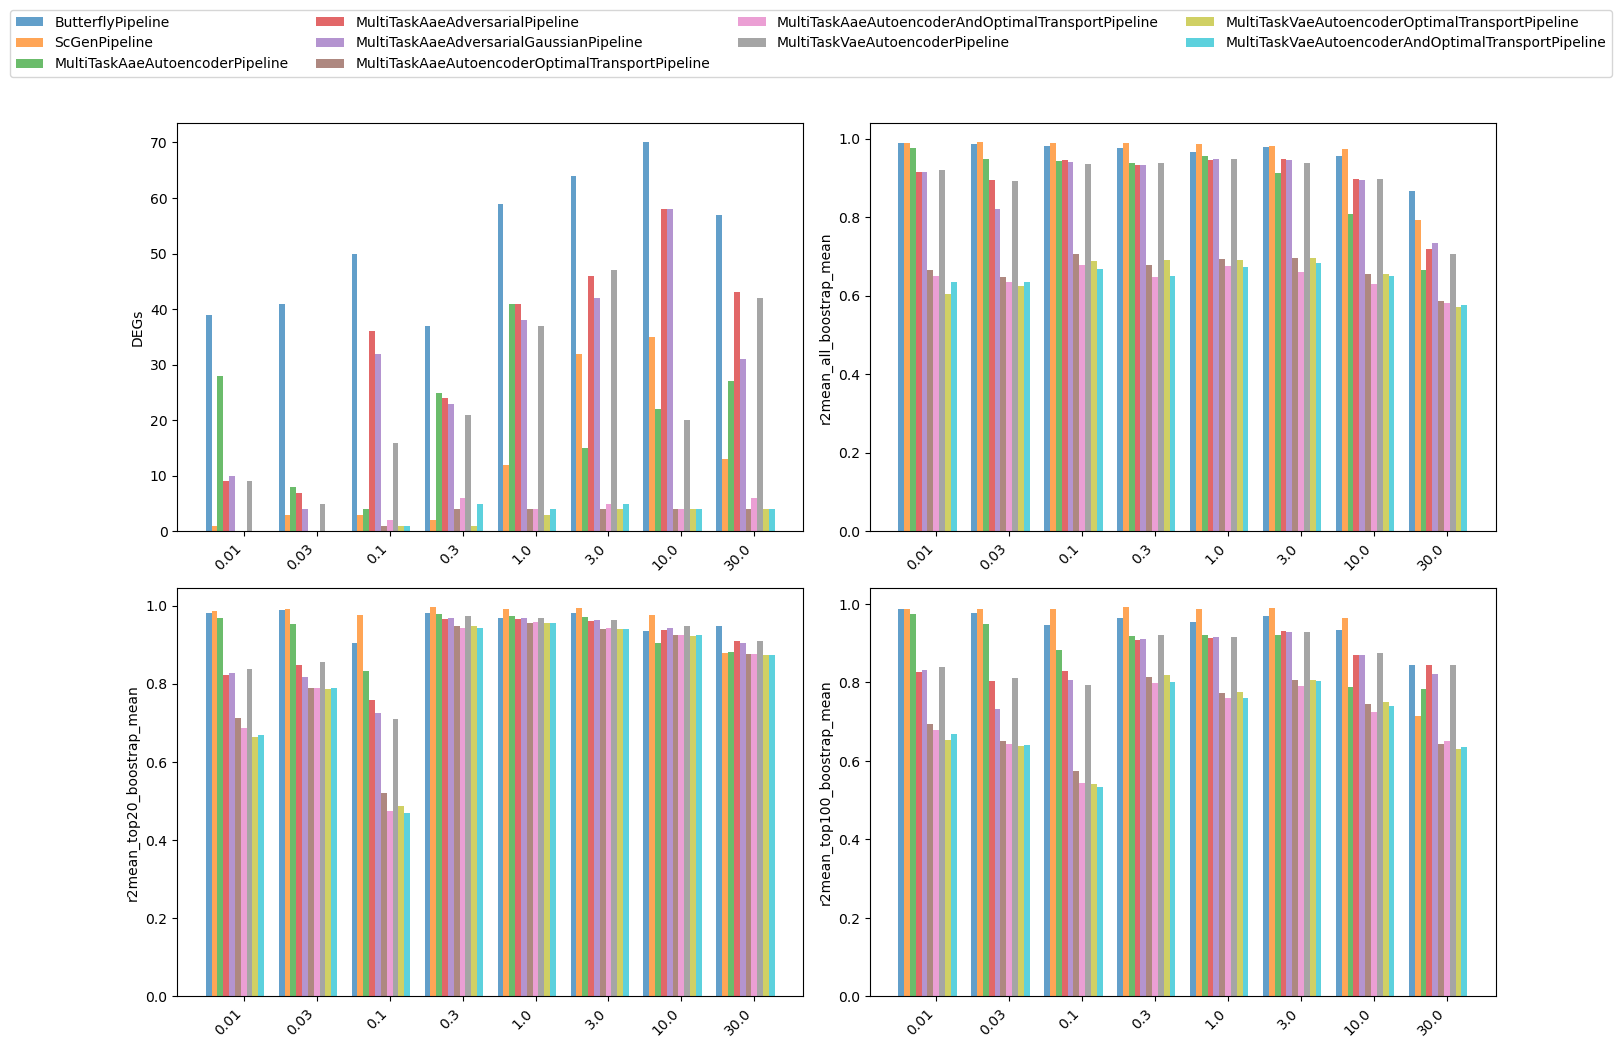

In [157]:
dataset_str = [
    "NaultMultiplePipeline_NaultPipeline",
    "NaultSinglePipeline_NaultPipeline",
]
dataset = METRICS_DF[METRICS_DF["dataset"].isin(dataset_str)]
dataset = dataset[
    dataset["experiment_name"].isna()
]  # with empty experiment name the seed is the default 19193
models = MODELS

plot_2d_metrics_per_dosage(
    dataset=dataset,
    cell_type="Hepatocytes - portal",
    models=models,
    title="",
)

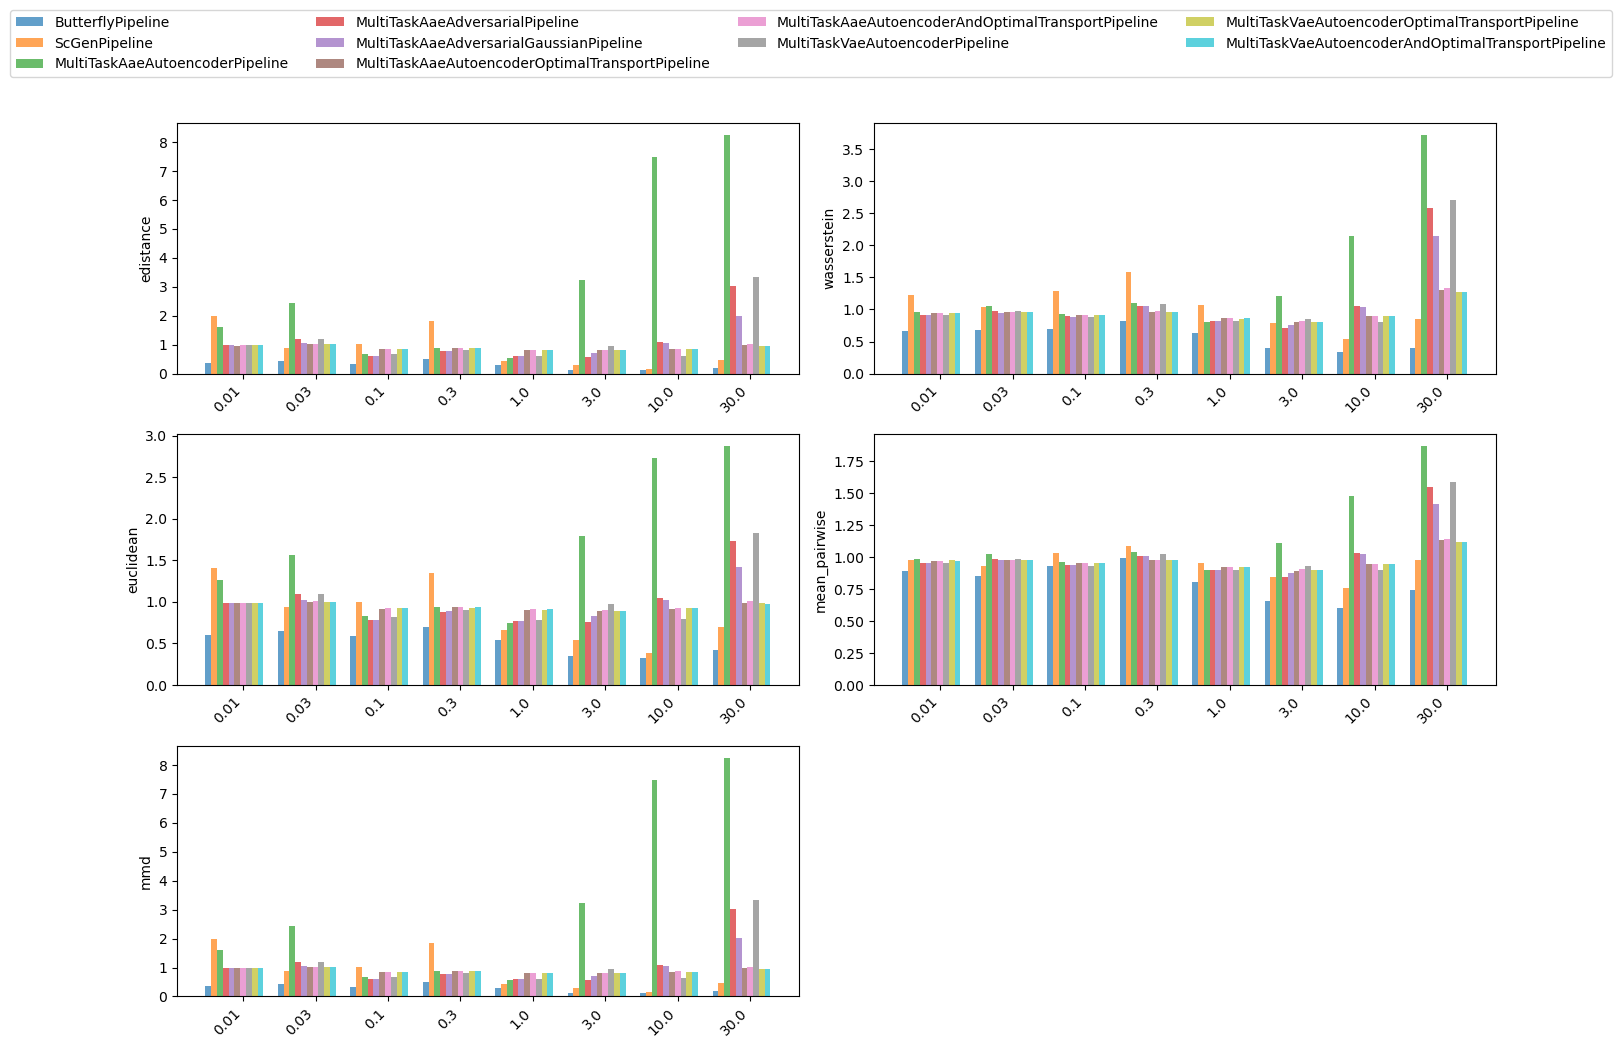

In [158]:
plot_2d_metrics_per_dosage(
    dataset=dataset,
    cell_type="Hepatocytes - portal",
    models=models,
    title="",
    metrics=DISTANCE_METRICS
)

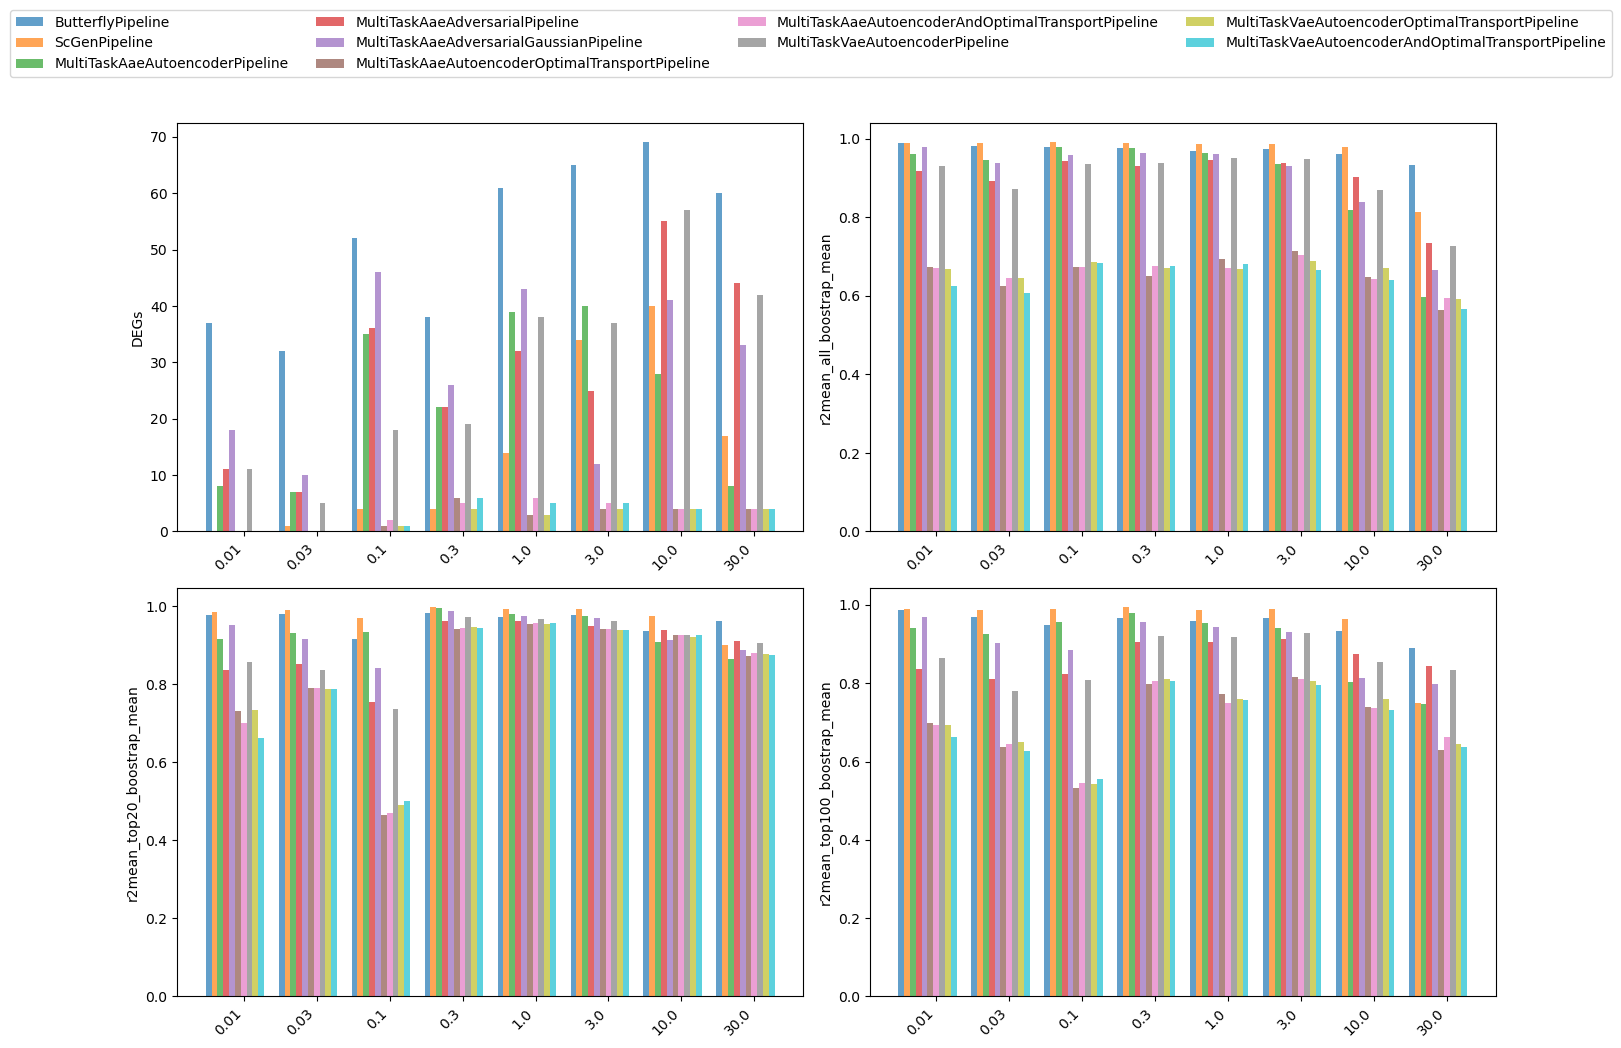

In [159]:
dataset_str = [
    "NaultMultiplePipeline_NaultPipeline",
    "NaultSinglePipeline_NaultPipeline",
]
dataset = METRICS_DF[METRICS_DF["dataset"].isin(dataset_str)]
# I have re-run the experiment specifiying explicitly the seed. Is it the same with above?
dataset = dataset[dataset["experiment_name"] == "seed_2"] 
models = MODELS

plot_2d_metrics_per_dosage(
    dataset=dataset,
    cell_type="Hepatocytes - portal",
    models=models,
    title="",
)

In [160]:
from enum import Enum
from typing import List
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches


class PlotType(Enum):
    Violin = 0
    Boxplot = 1


class DimToReduce(Enum):
    X = 0
    Y = 1


def get_plot(
    datasets_name: List[str],
    experiment_name: str,
    x_key: str,
    y_key: str,
    title: str,
    dim_to_reduce: DimToReduce,
    plot_type=PlotType.Violin,
    metrics: List[str] = [
        "DEGs",
        "r2mean",
        "r2mean_top20_boostrap_mean",
        "r2mean_top100_boostrap_mean",
    ],
    file_name_to_save: Optional[str] = None,
):
    dataset = METRICS_DF[METRICS_DF["experiment_name"] == experiment_name]
    dataset = dataset[dataset["dataset"].isin(datasets_name)].sort_values(
        by=[x_key, y_key]
    )
    x_labels_init = sorted(dataset[x_key].unique().tolist())
    y_labels_init = sorted(dataset[y_key].unique().tolist())

    x = np.arange(len(x_labels_init))
    y = np.arange(len(y_labels_init))
    width = 0.1
    
    nrows = int(np.ceil(len(metrics) / 2))

    fig, axes = plt.subplots(nrows, 2, figsize=(14, 10))
    axes = axes.flatten()

    x_labels = x_labels_init if dim_to_reduce == DimToReduce.Y else y_labels_init
    y_labels = y_labels_init if dim_to_reduce == DimToReduce.Y else x_labels_init
    x = x if dim_to_reduce == DimToReduce.Y else y
    x_key = x_key if dim_to_reduce == DimToReduce.Y else y_key
    
    def _plot(ax, metric):
        start = -(len(MODELS) // 2)
        start = start if len(MODELS) % 2 != 0 else start - 1
        end = len(MODELS) // 2
        x_bars = [x + i * width for i in range(start, end + 1, 1)]
        for model_index, (model, x_bar) in enumerate(zip(MODELS, x_bars)):
            dataset_model = dataset[dataset["model"] == model]

            plot_data = []
            for x_label in x_labels:
                plot_data.append(
                    dataset_model[dataset_model[x_key] == x_label][metric].values.tolist()
                )
                assert len(plot_data[-1]) == len(y_labels)

            if plot_type == PlotType.Violin:
                ax.violinplot(
                    dataset=plot_data,
                    positions=x_bar,
                    widths=width,
                    vert=True,
                    showmedians=True,
                )
            elif plot_type == PlotType.Boxplot:
                ax.boxplot(
                    plot_data,
                    positions=x_bar,
                    widths=width,
                    patch_artist=True,
                    boxprops=dict(facecolor=f"C{model_index}", color="black"),
                    medianprops=dict(color="black"),
                )
            else: 
                raise NotImplementedError

    for ax, metric in zip(axes, metrics):
        _plot(ax, metric)

        ax.set_xticks(x)
        ax.set_xticklabels(x_labels, rotation=45, ha="right")
        ax.set_ylabel(metric)
        
    if len(metrics) % 2 != 0:
        fig.delaxes(axes[-1])

    # Create custom legend handles
    legend_handles = [mpatches.Patch(color=f"C{i}", label=model) for i, model in enumerate(MODELS)]
    
    # Add custom legend
    fig.legend(legend_handles, [model for model in MODELS], loc="upper center", bbox_to_anchor=(0.5, 1.05), ncol=4)
    fig.suptitle(title)

    plt.tight_layout(rect=[0, 0, 1, 0.96])  # Leave space at the top for the legend
    if file_name_to_save is not None:
        fig.savefig(FIGURES_PATH / f'{file_name_to_save}.pdf', dpi=300, bbox_inches='tight')
    plt.show()


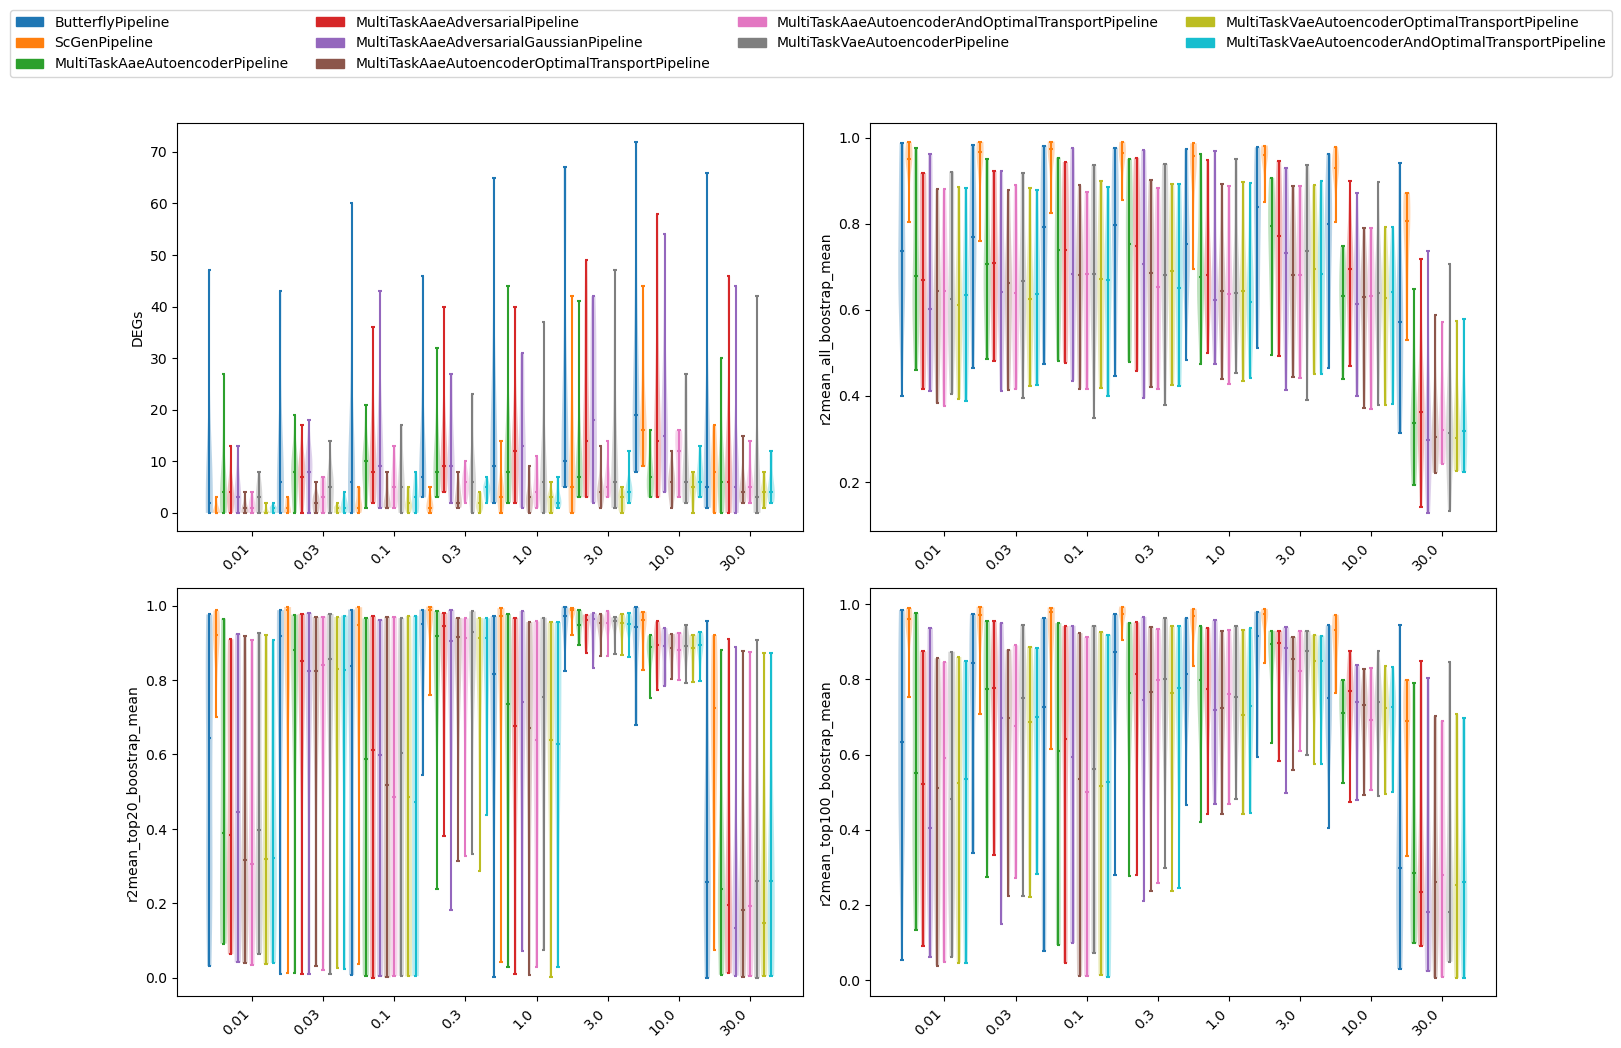

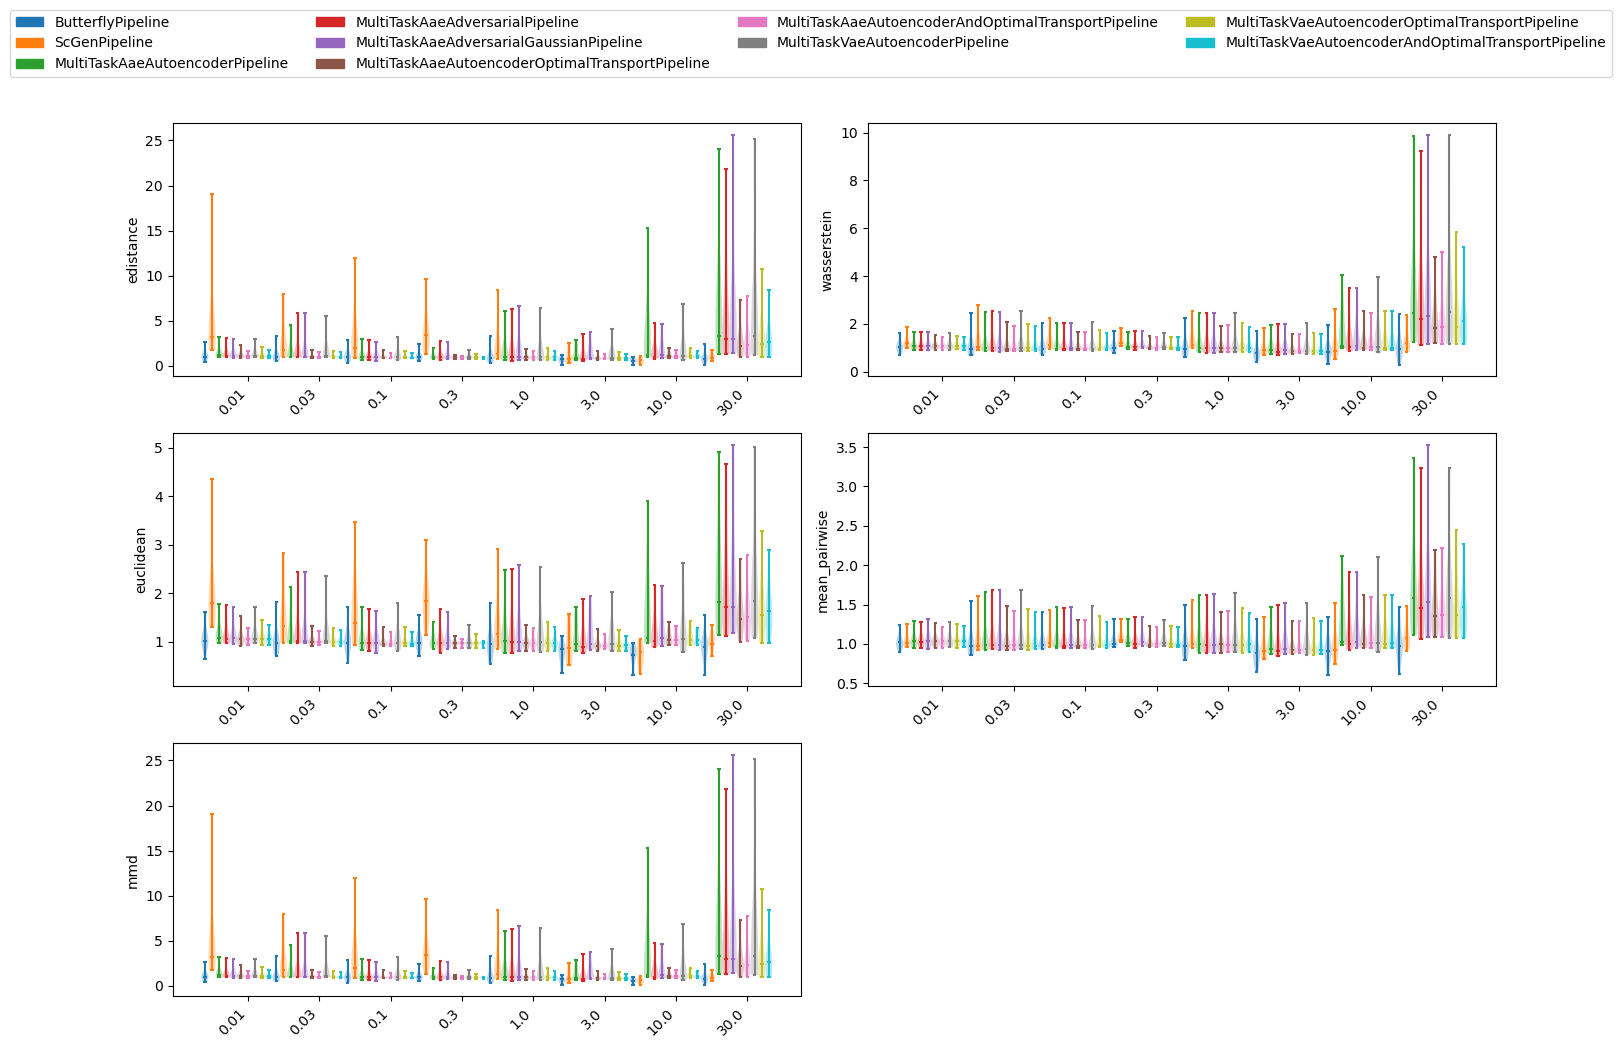

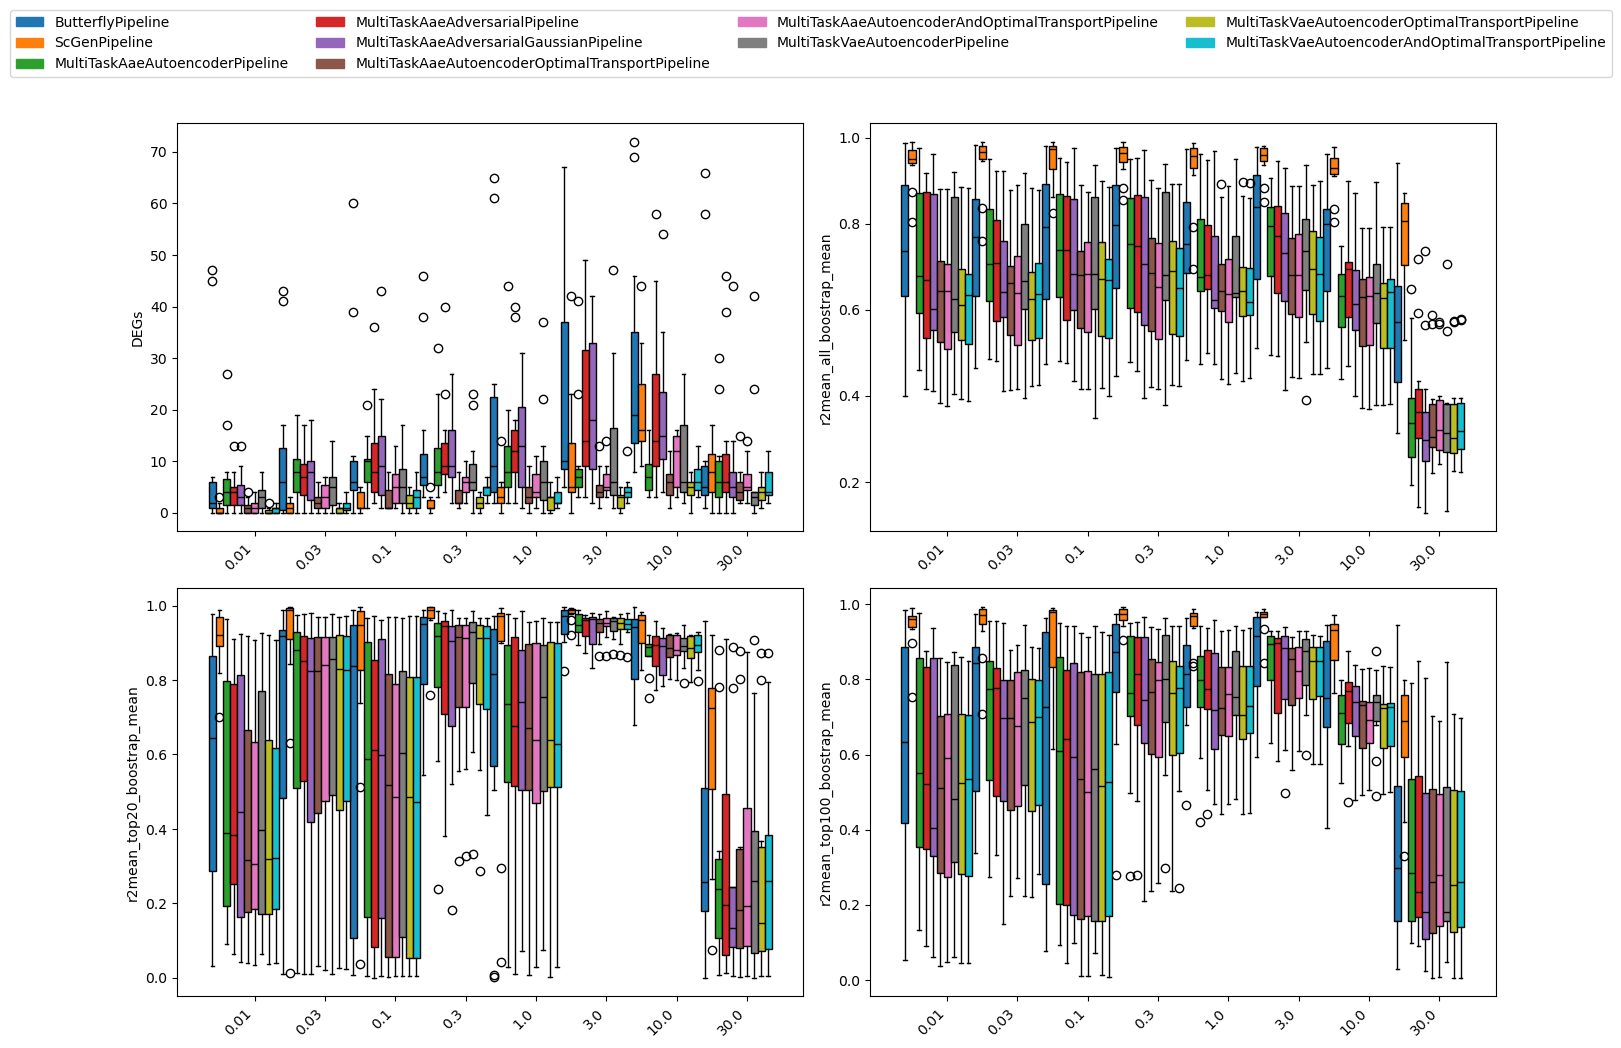

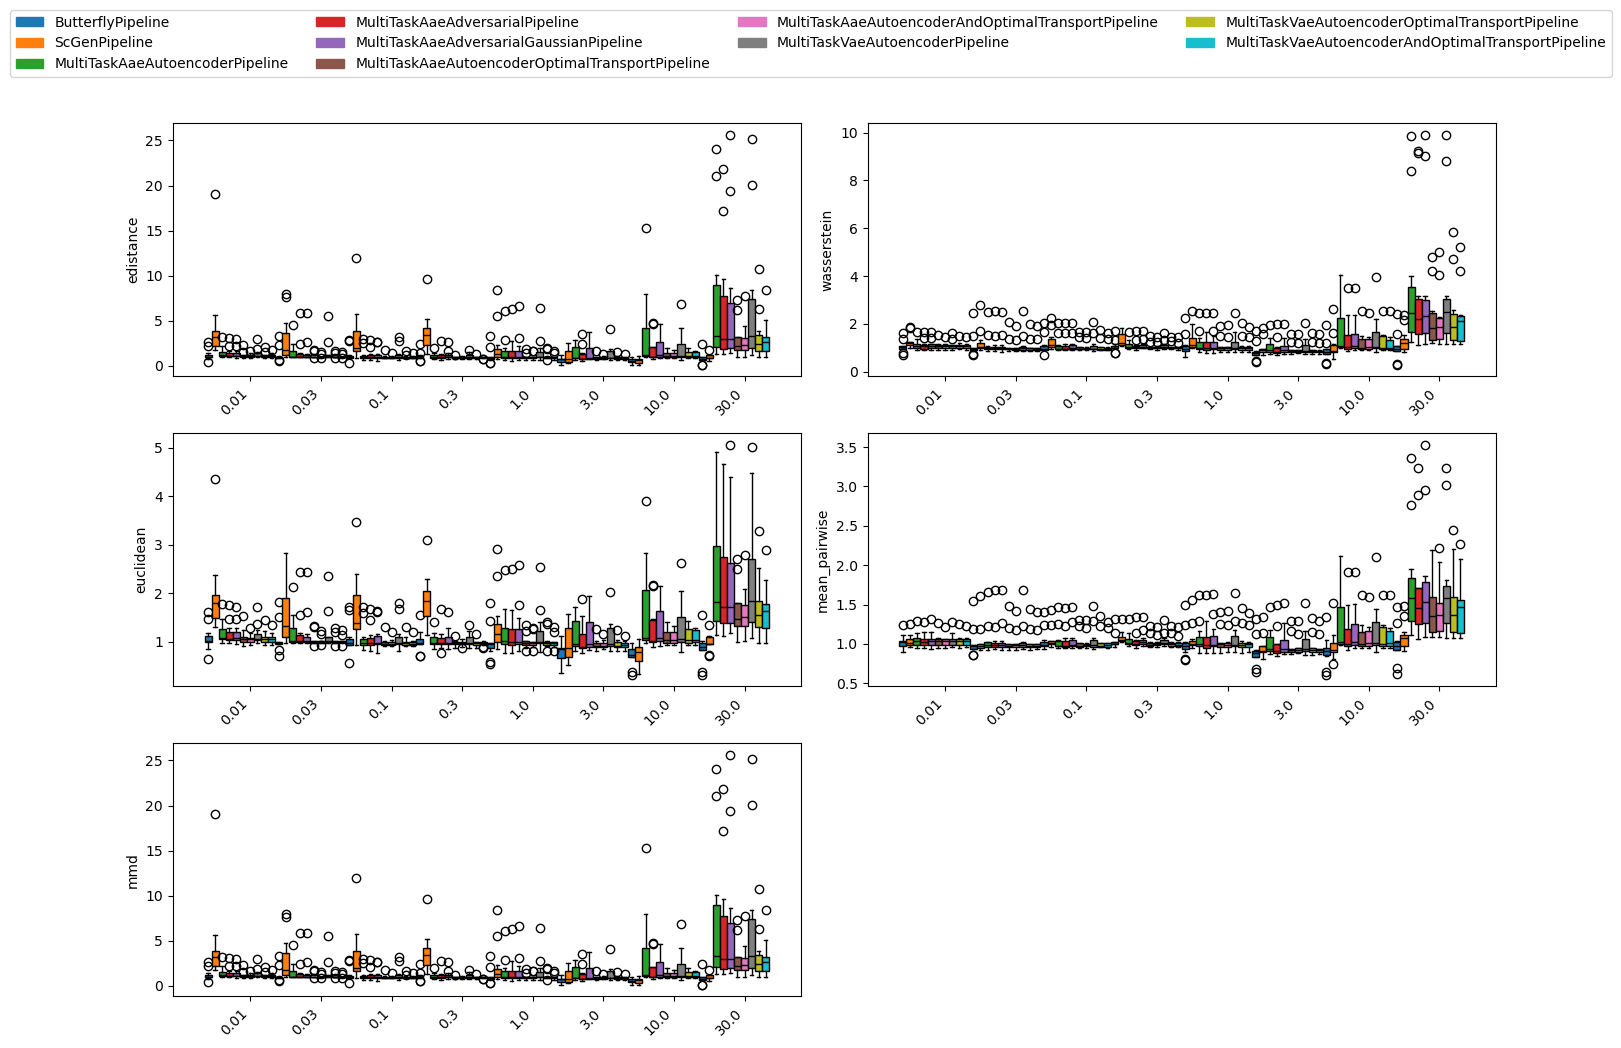

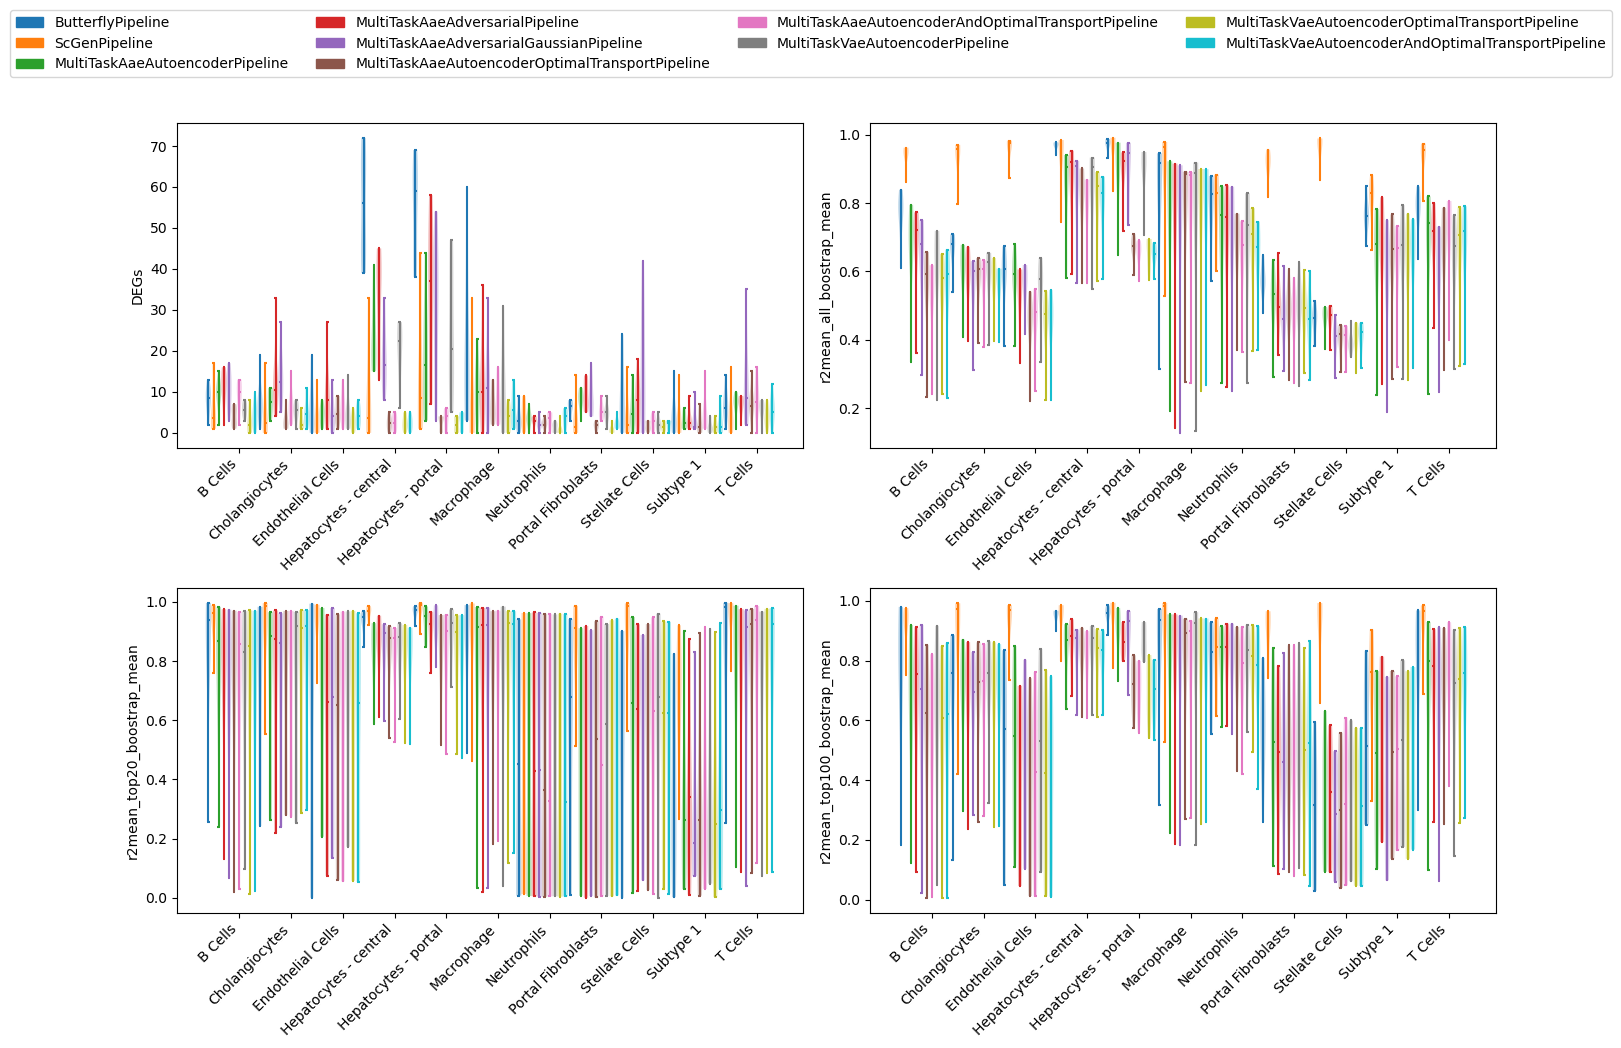

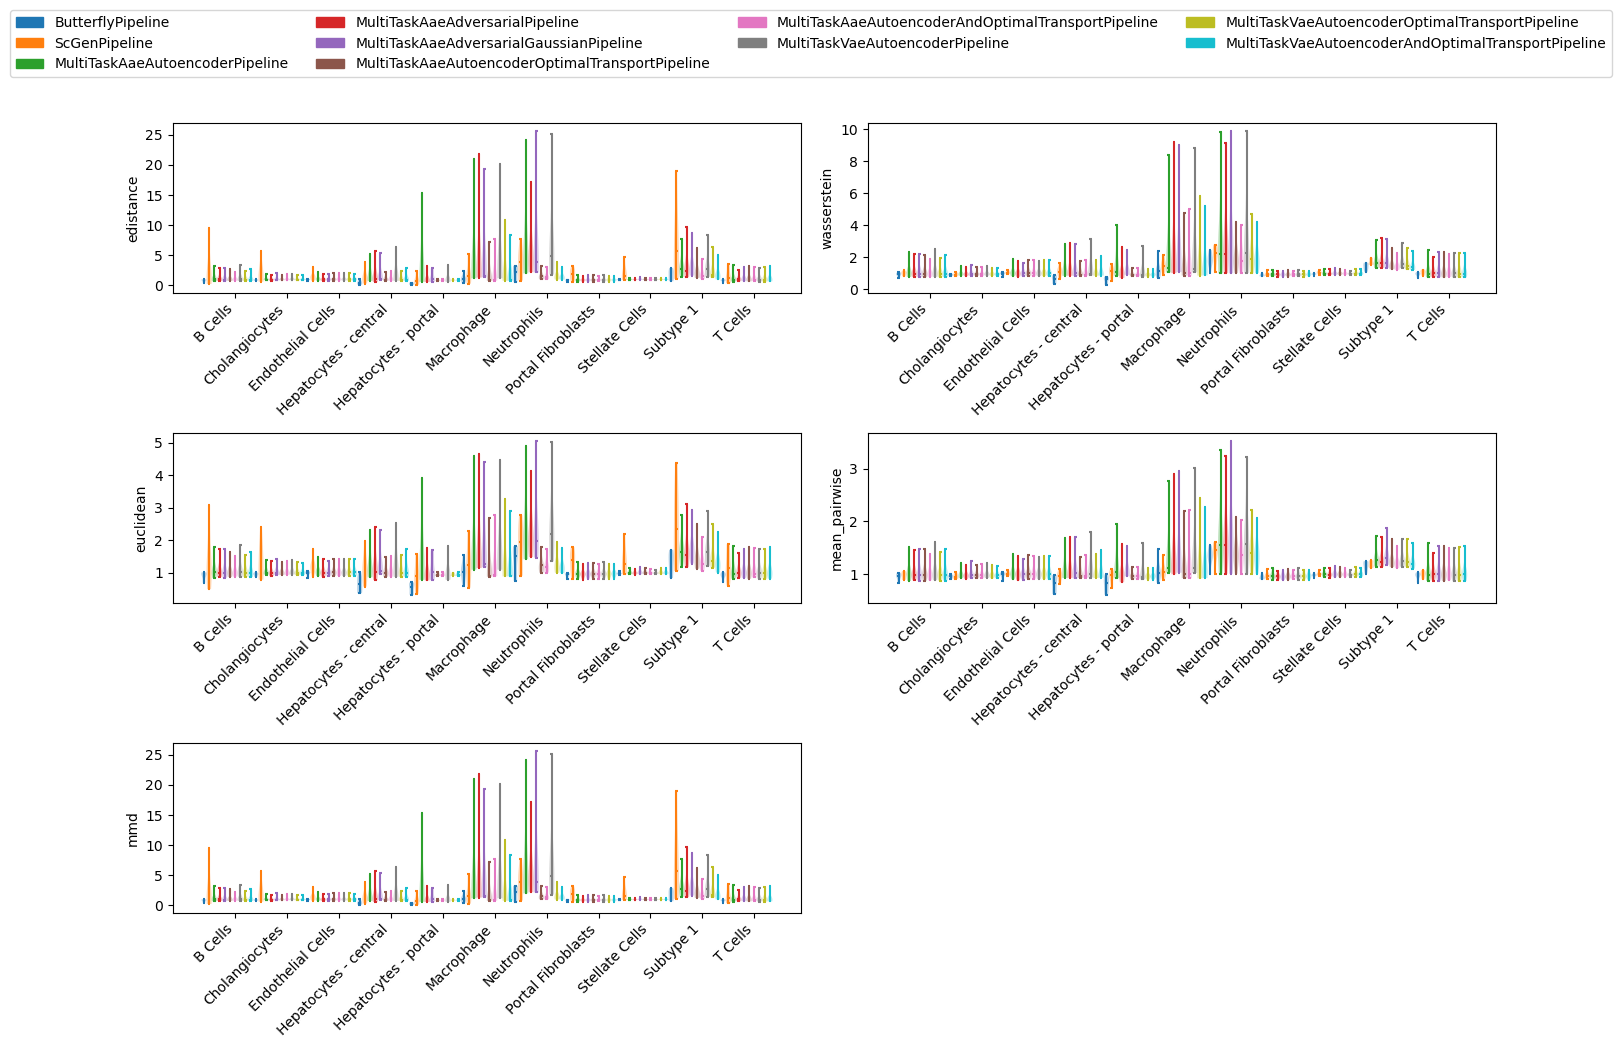

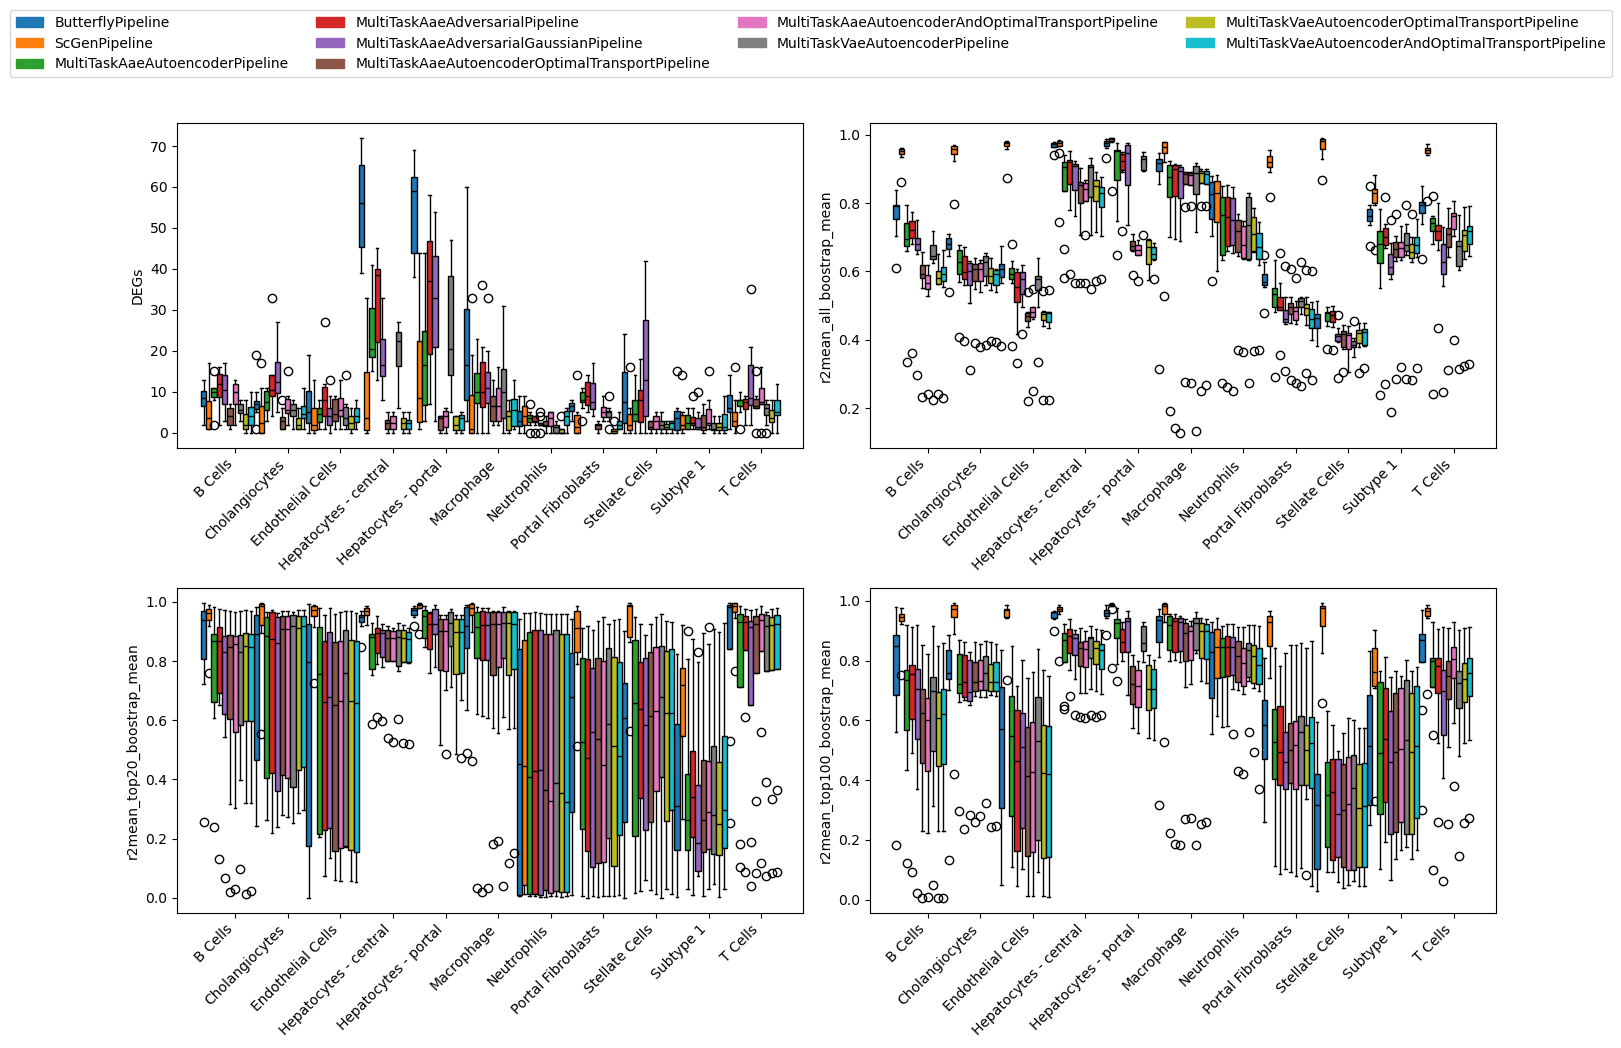

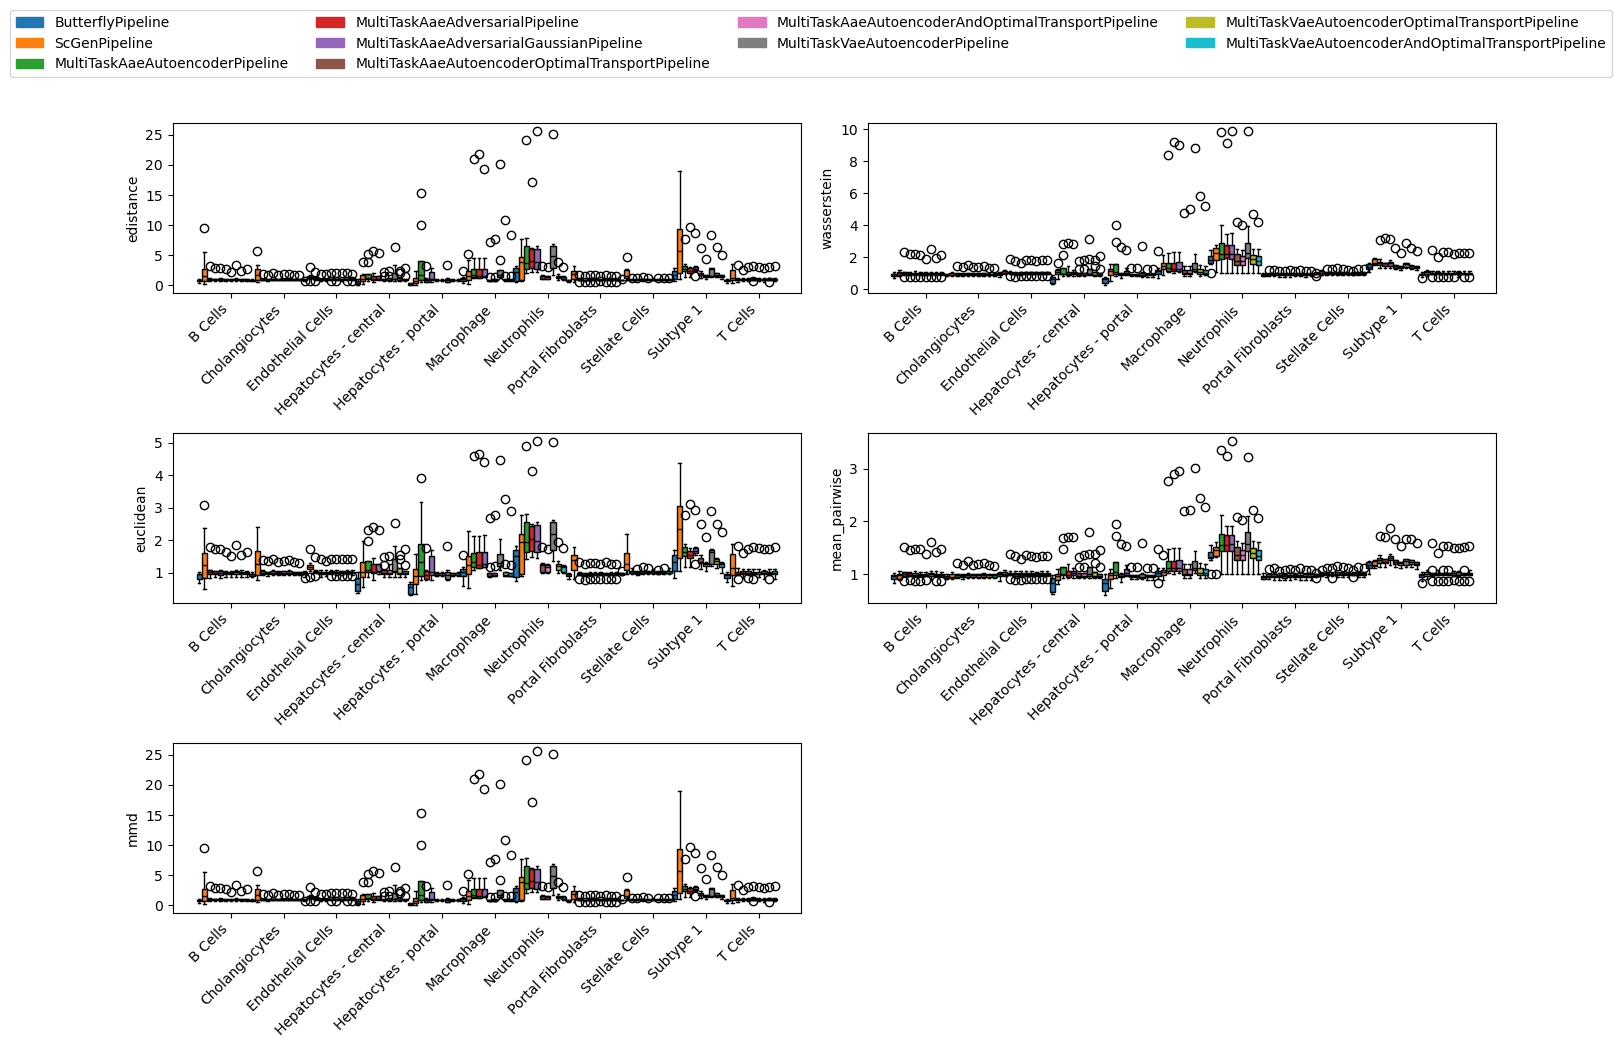

In [161]:
dim_to_reduce = [DimToReduce.X, DimToReduce.Y]
plots = [PlotType.Violin, PlotType.Boxplot]
metrics = [BASELINE_METRICS, DISTANCE_METRICS]
for dim in dim_to_reduce:
    for plot in plots:
        for idx, metric in enumerate(metrics):
            get_plot(
                datasets_name=["NaultMultiplePipeline_NaultPipeline", "NaultSinglePipeline_NaultPipeline"],
                experiment_name="seed_19193",
                x_key="cell_type_test",
                y_key="dose",
                dim_to_reduce=dim,
                plot_type=plot,
                title="",
                metrics=metric,
                #file_name_to_save=f'NaultPipeline_{dim.name}_{plot.name}_metrics{idx}'
            )

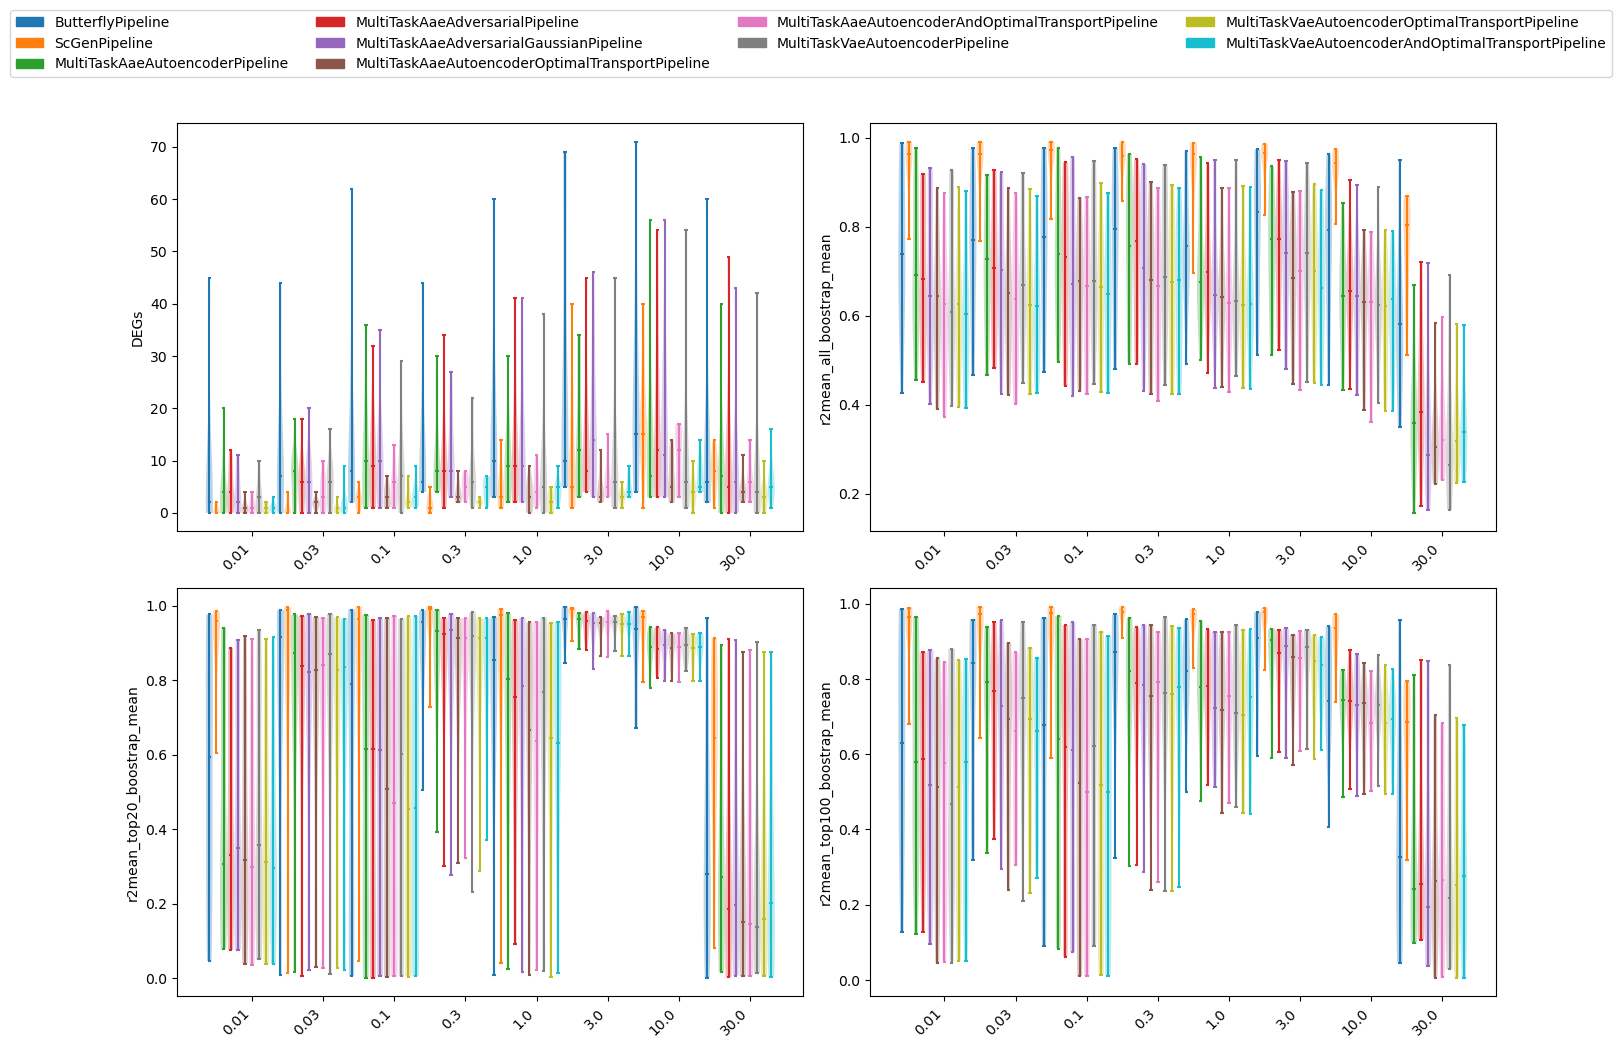

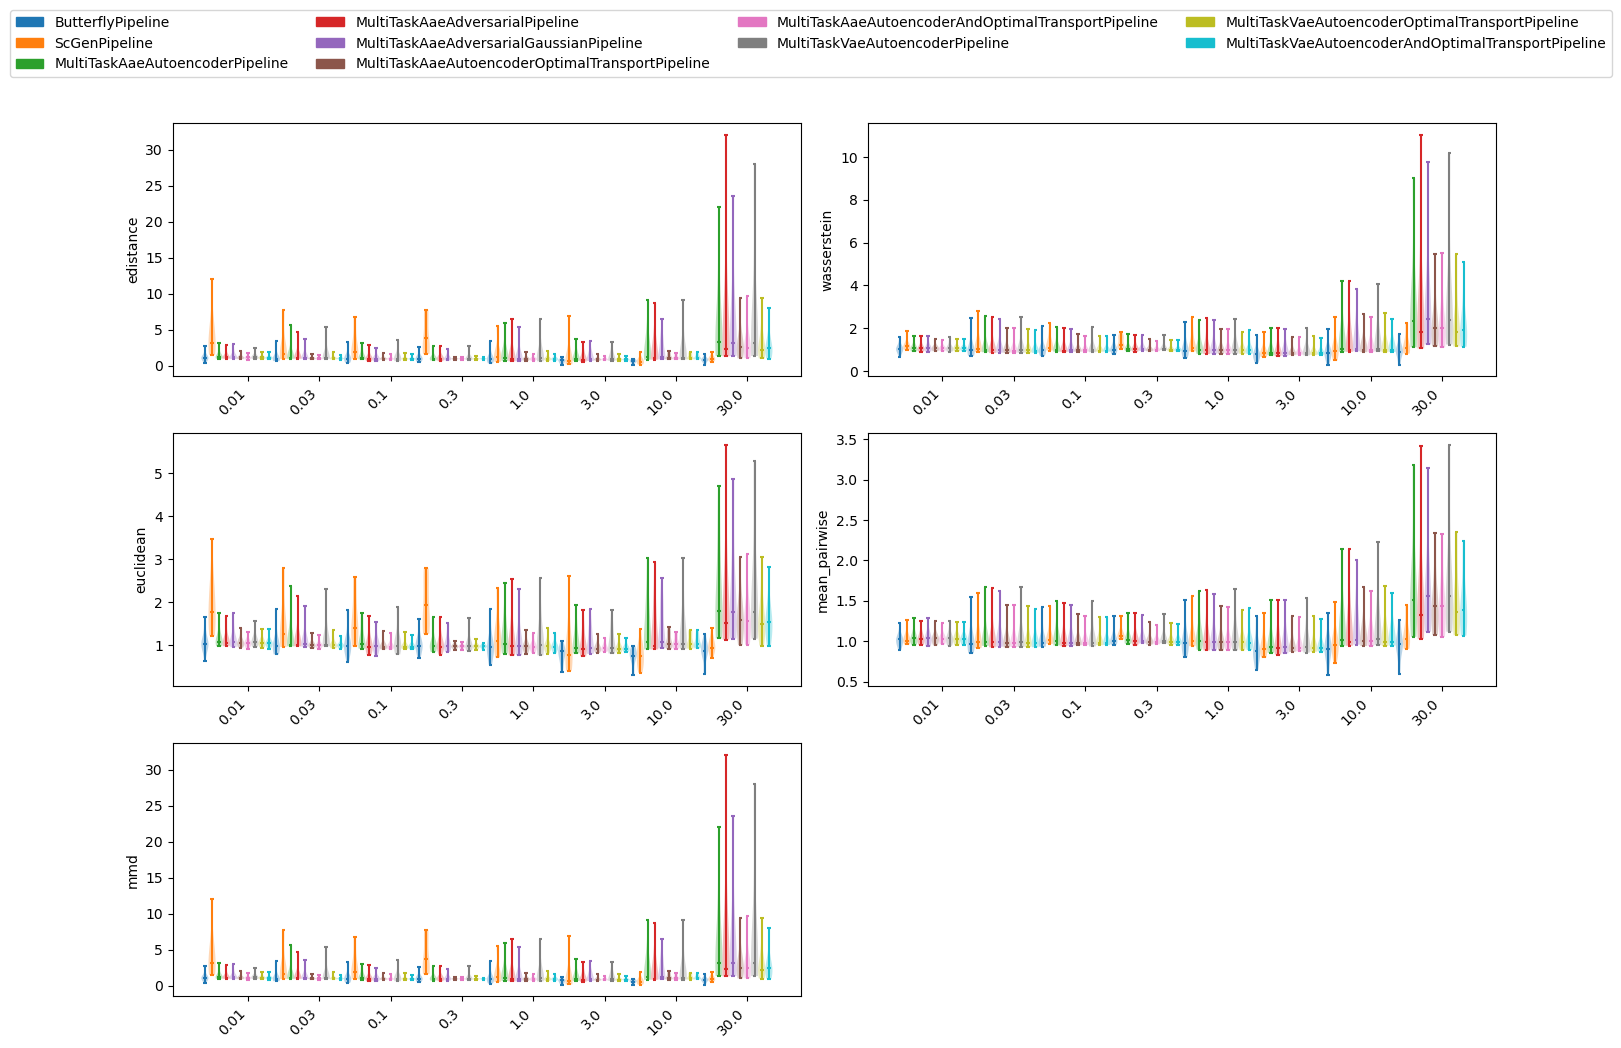

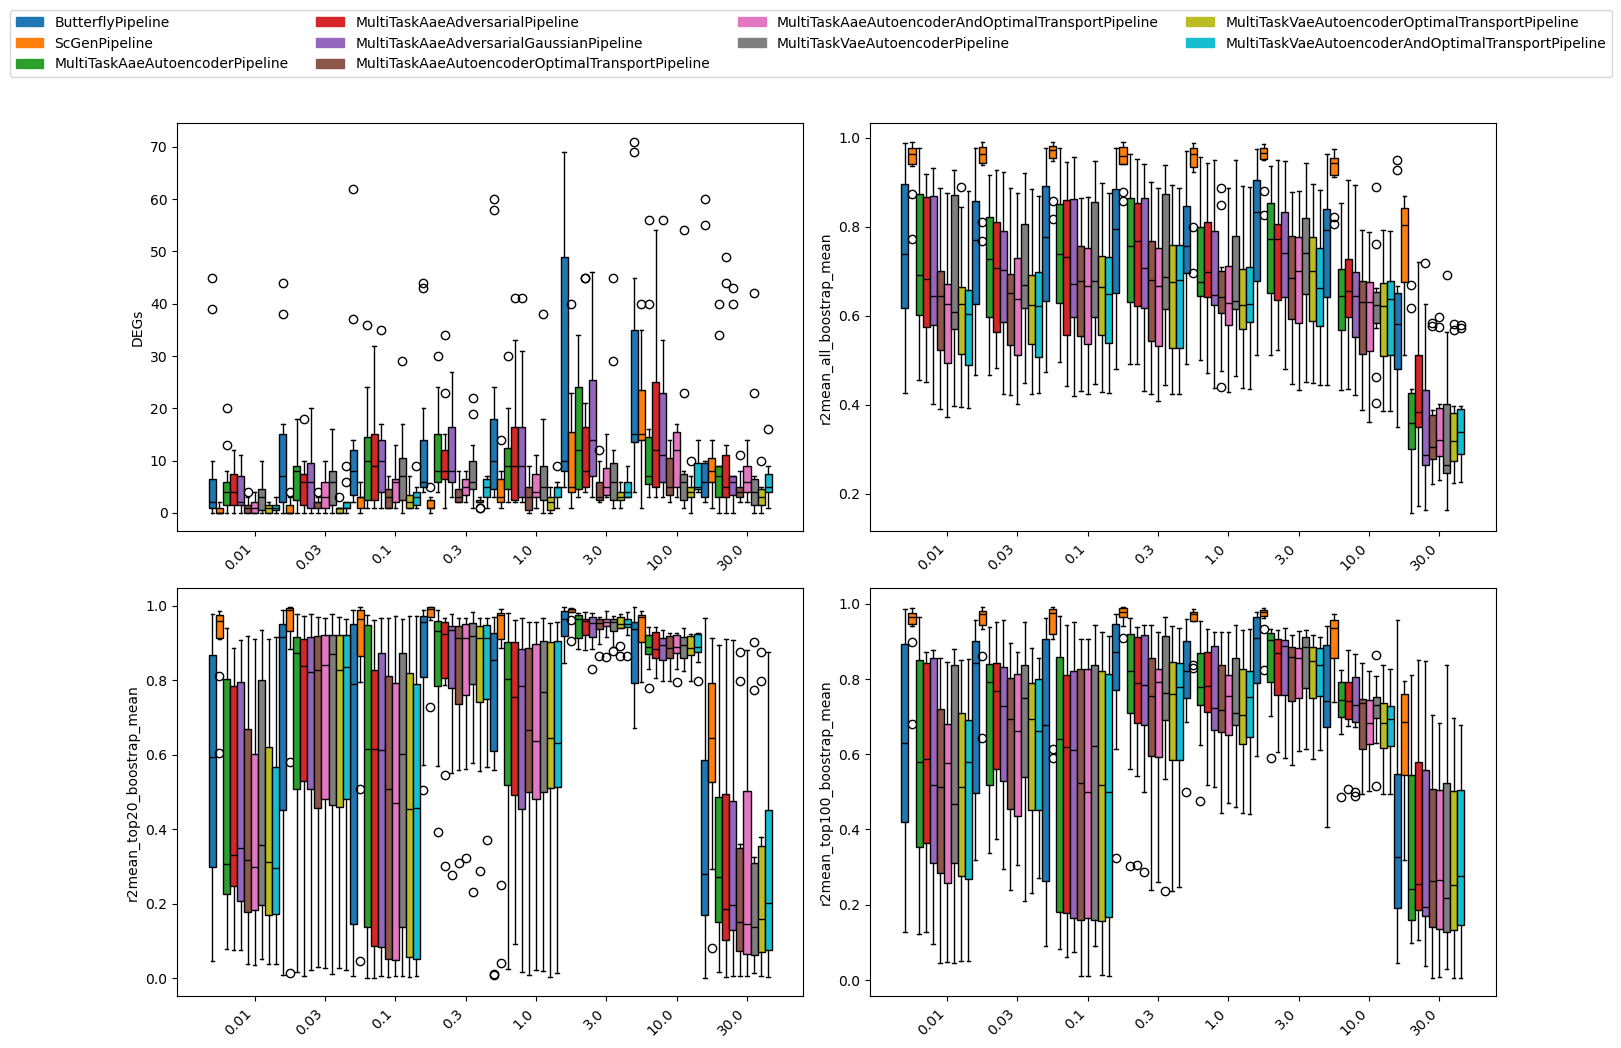

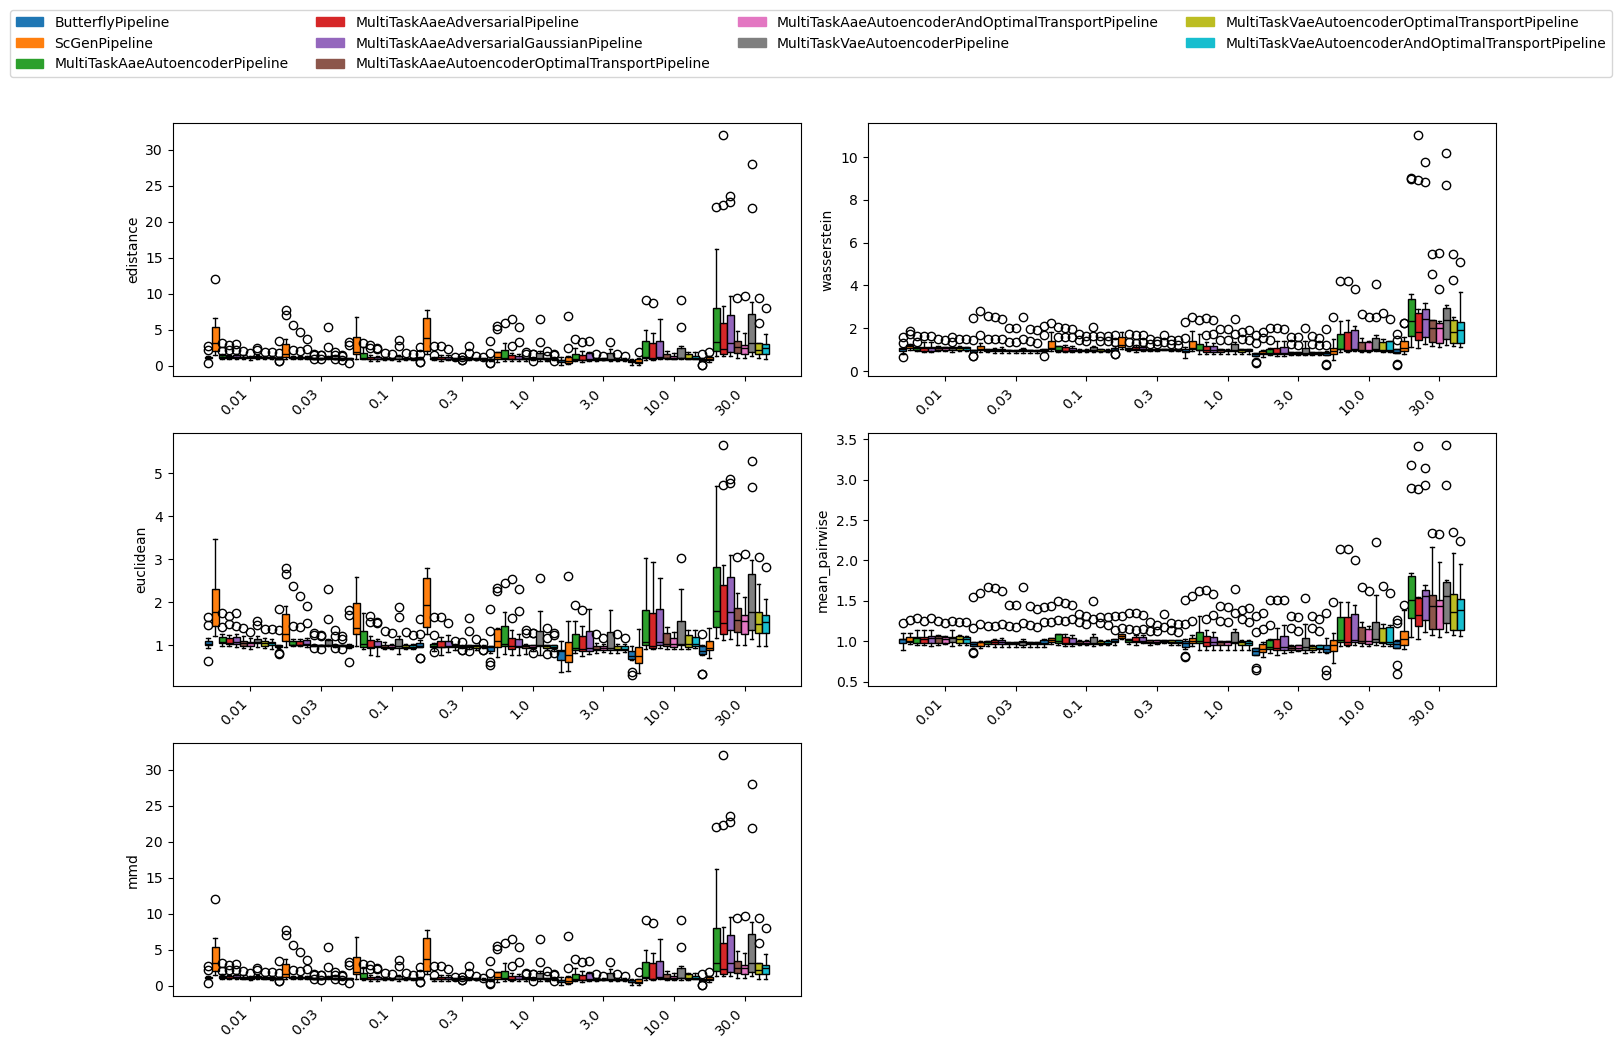

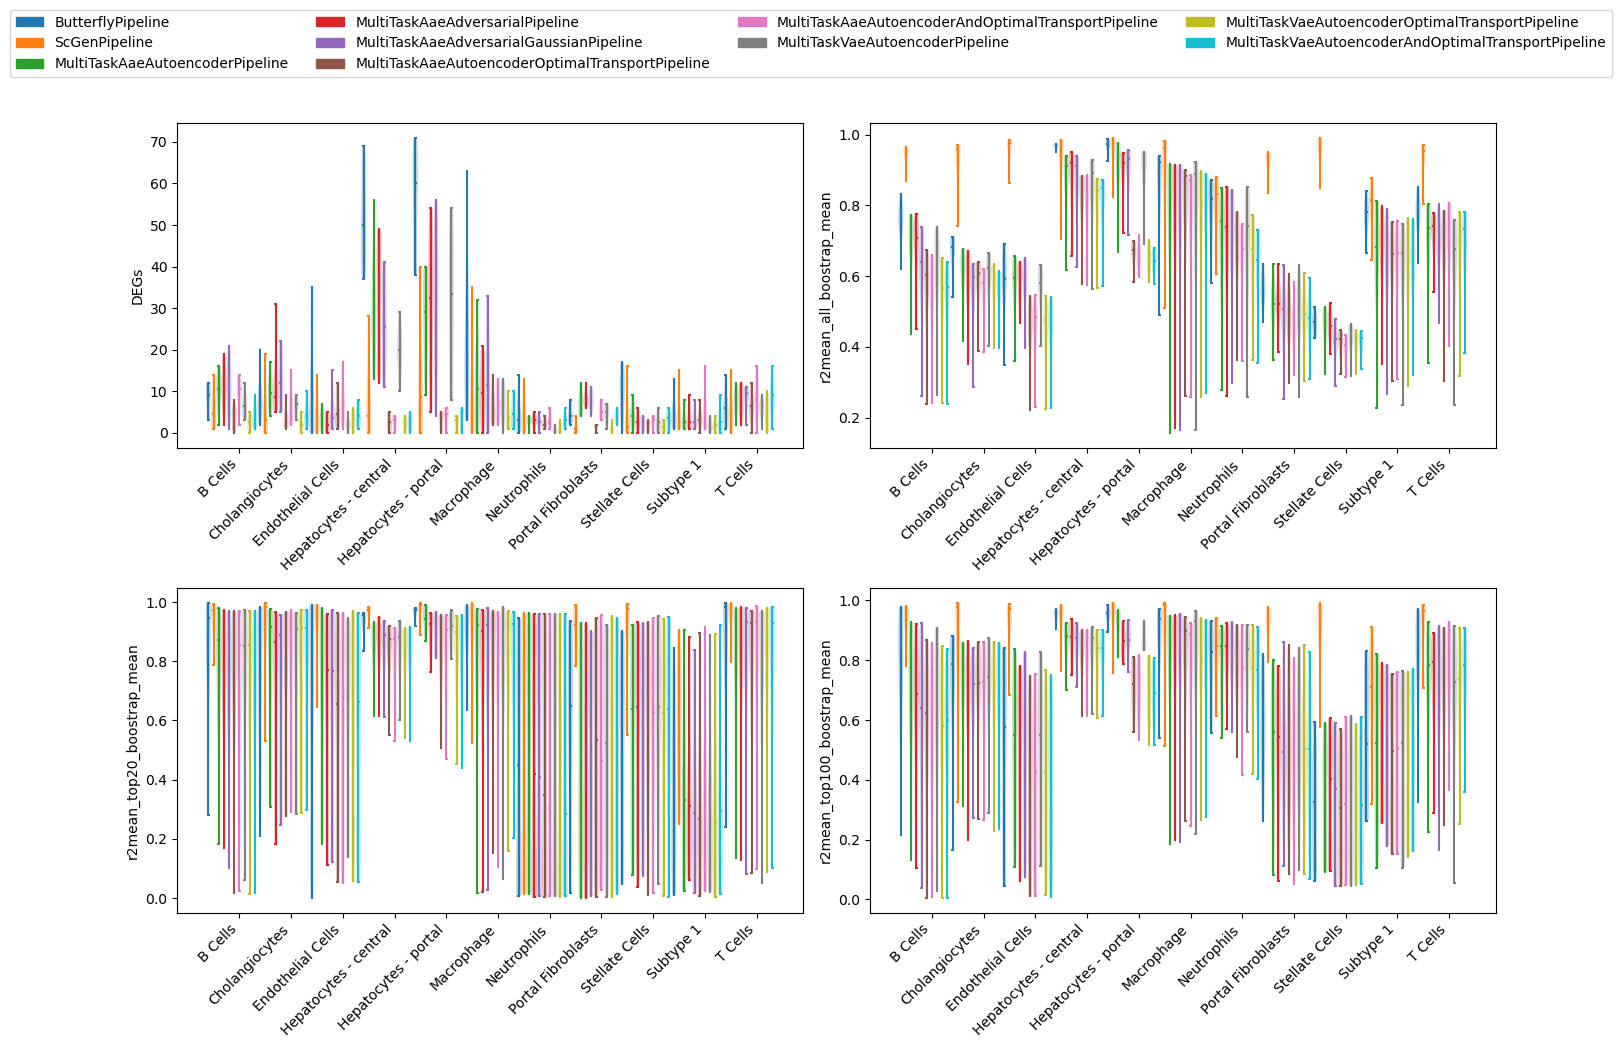

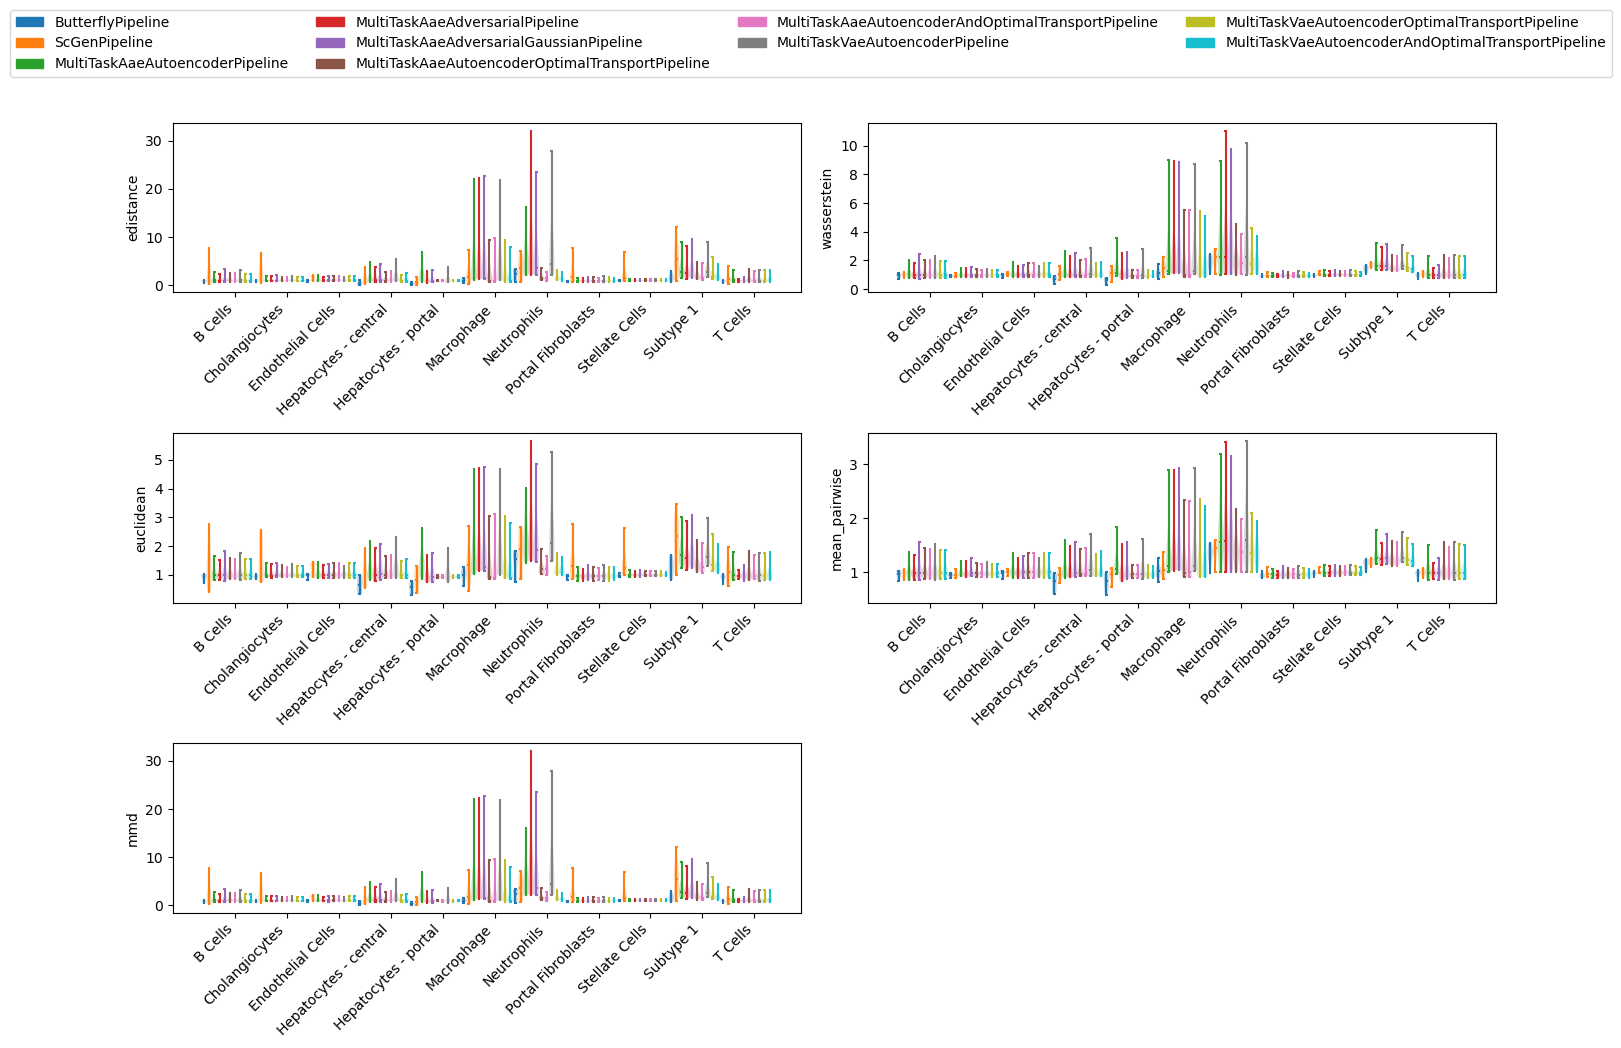

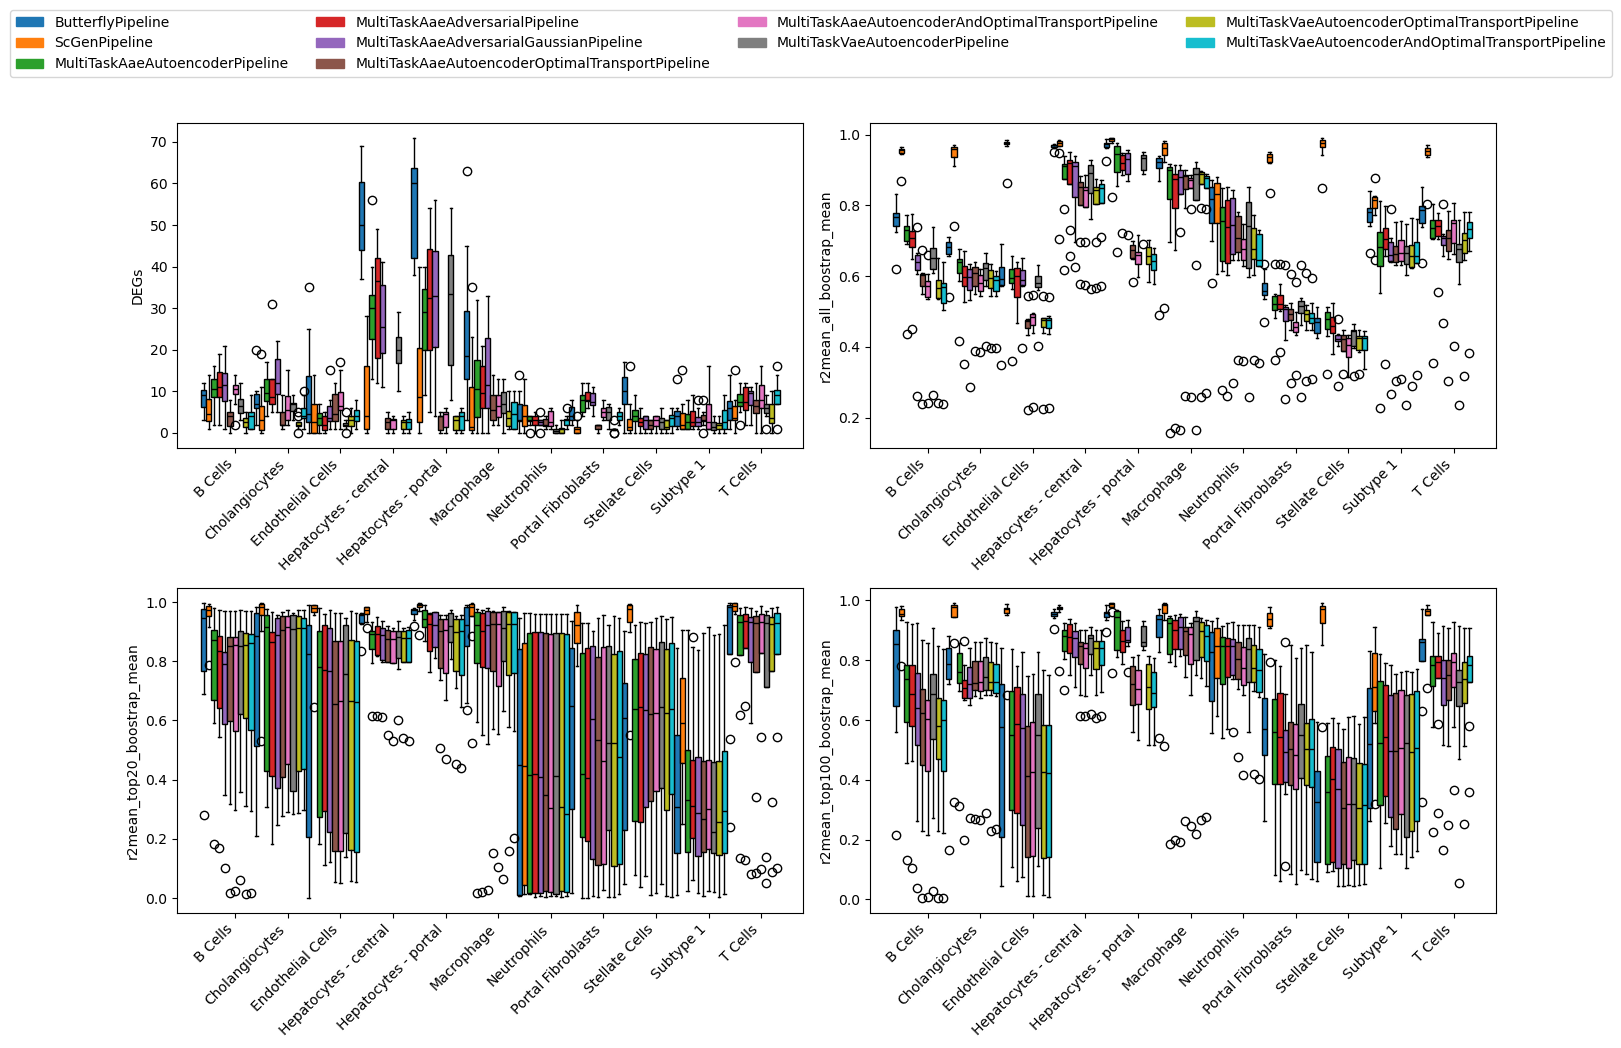

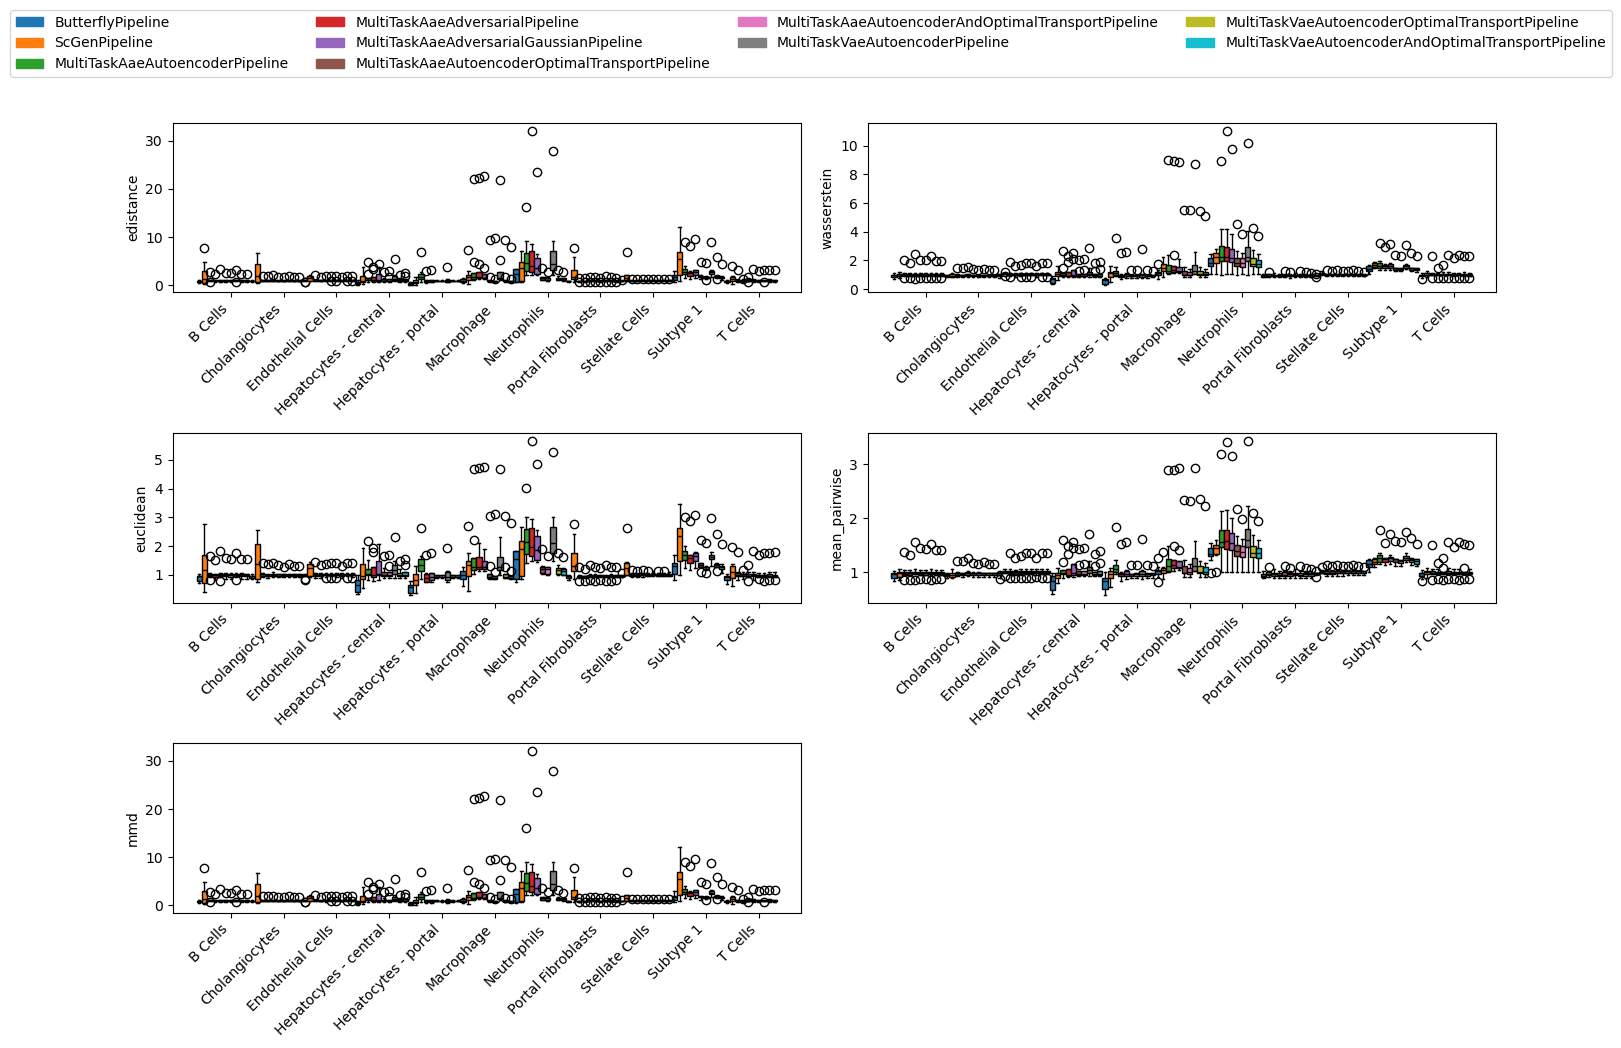

In [162]:
dim_to_reduce = [DimToReduce.X, DimToReduce.Y]
plots = [PlotType.Violin, PlotType.Boxplot]
metrics = [BASELINE_METRICS, DISTANCE_METRICS]
for dim in dim_to_reduce:
    for plot in plots:
        for idx, metric in enumerate(metrics):
            get_plot(
                datasets_name=["NaultMultiplePipeline_NaultPipeline", "NaultSinglePipeline_NaultPipeline"],
                experiment_name="seed_1",
                x_key="cell_type_test",
                y_key="dose",
                dim_to_reduce=dim,
                plot_type=plot,
                title="",
                metrics=metric,
                #file_name_to_save=f'NaultPipeline_{dim.name}_{plot.name}_metrics{idx}'
            )

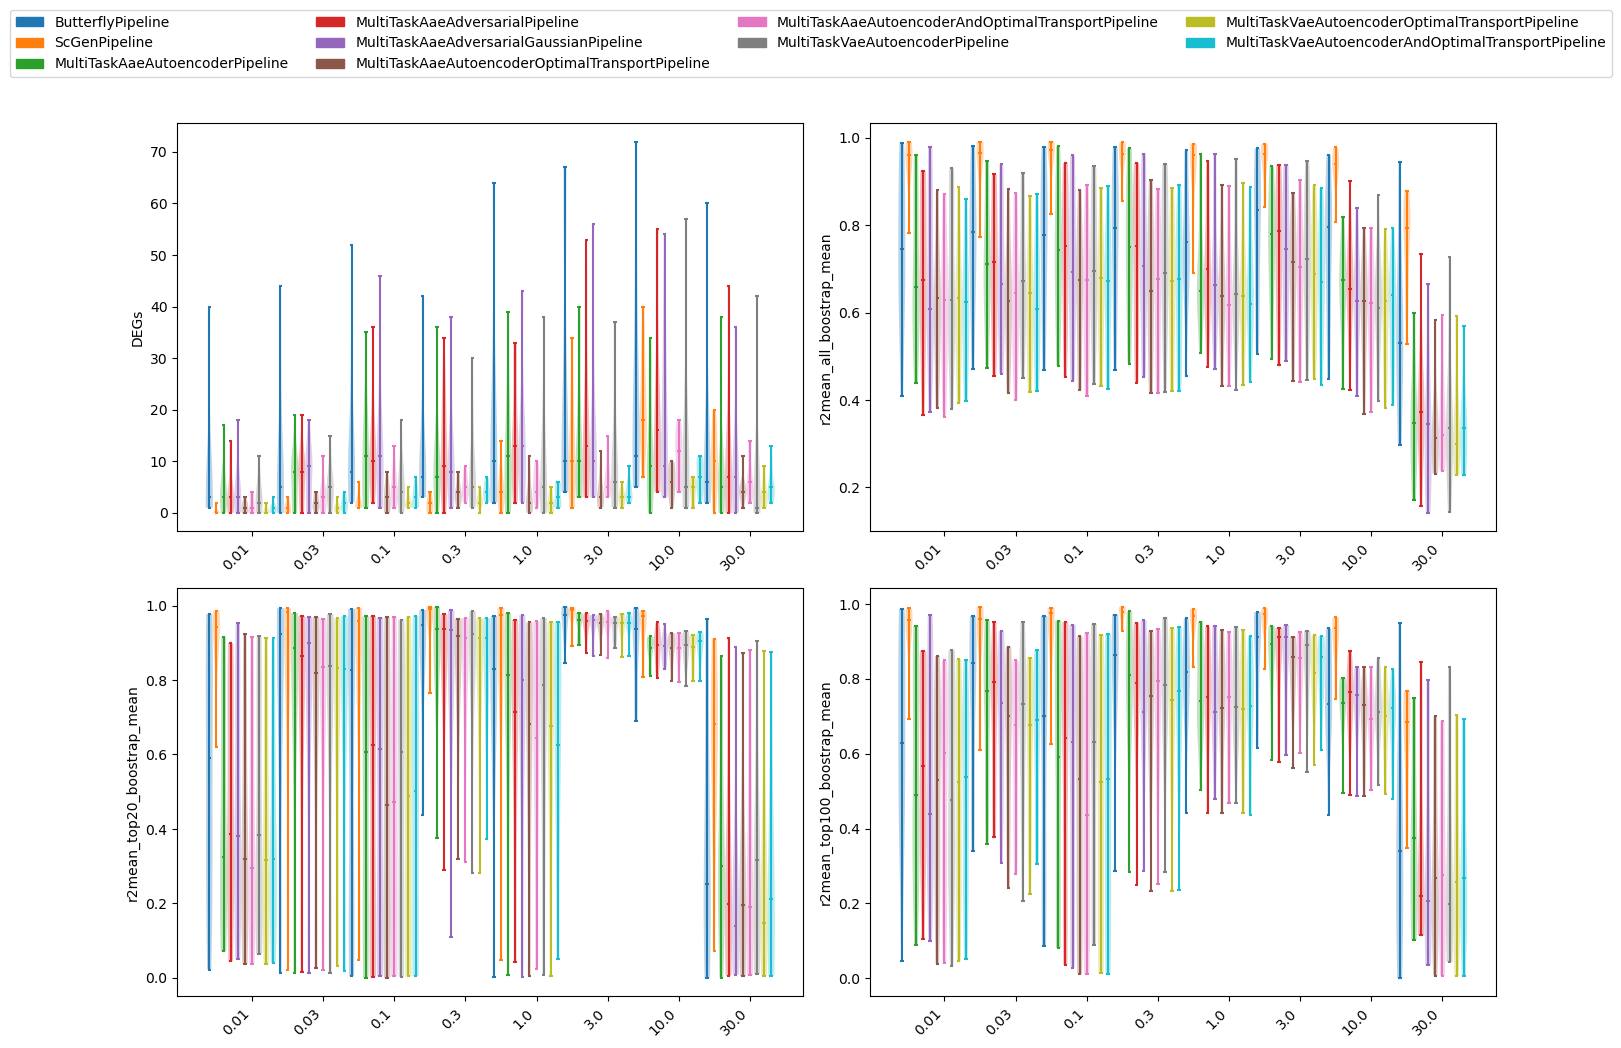

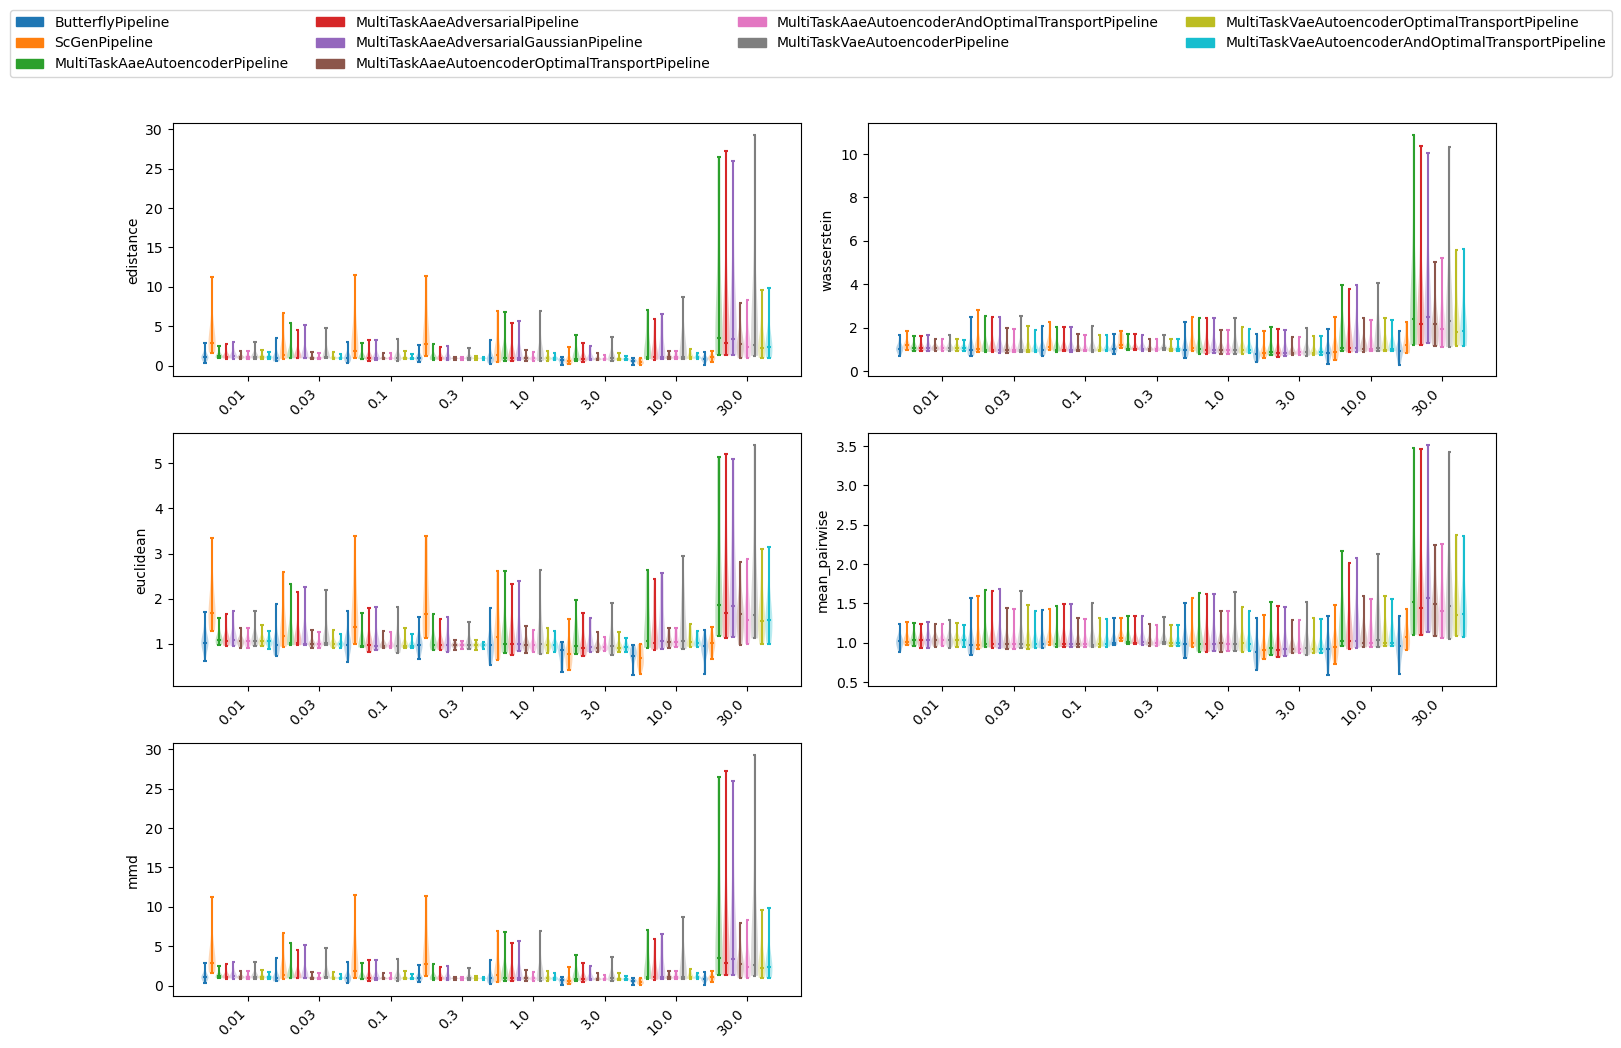

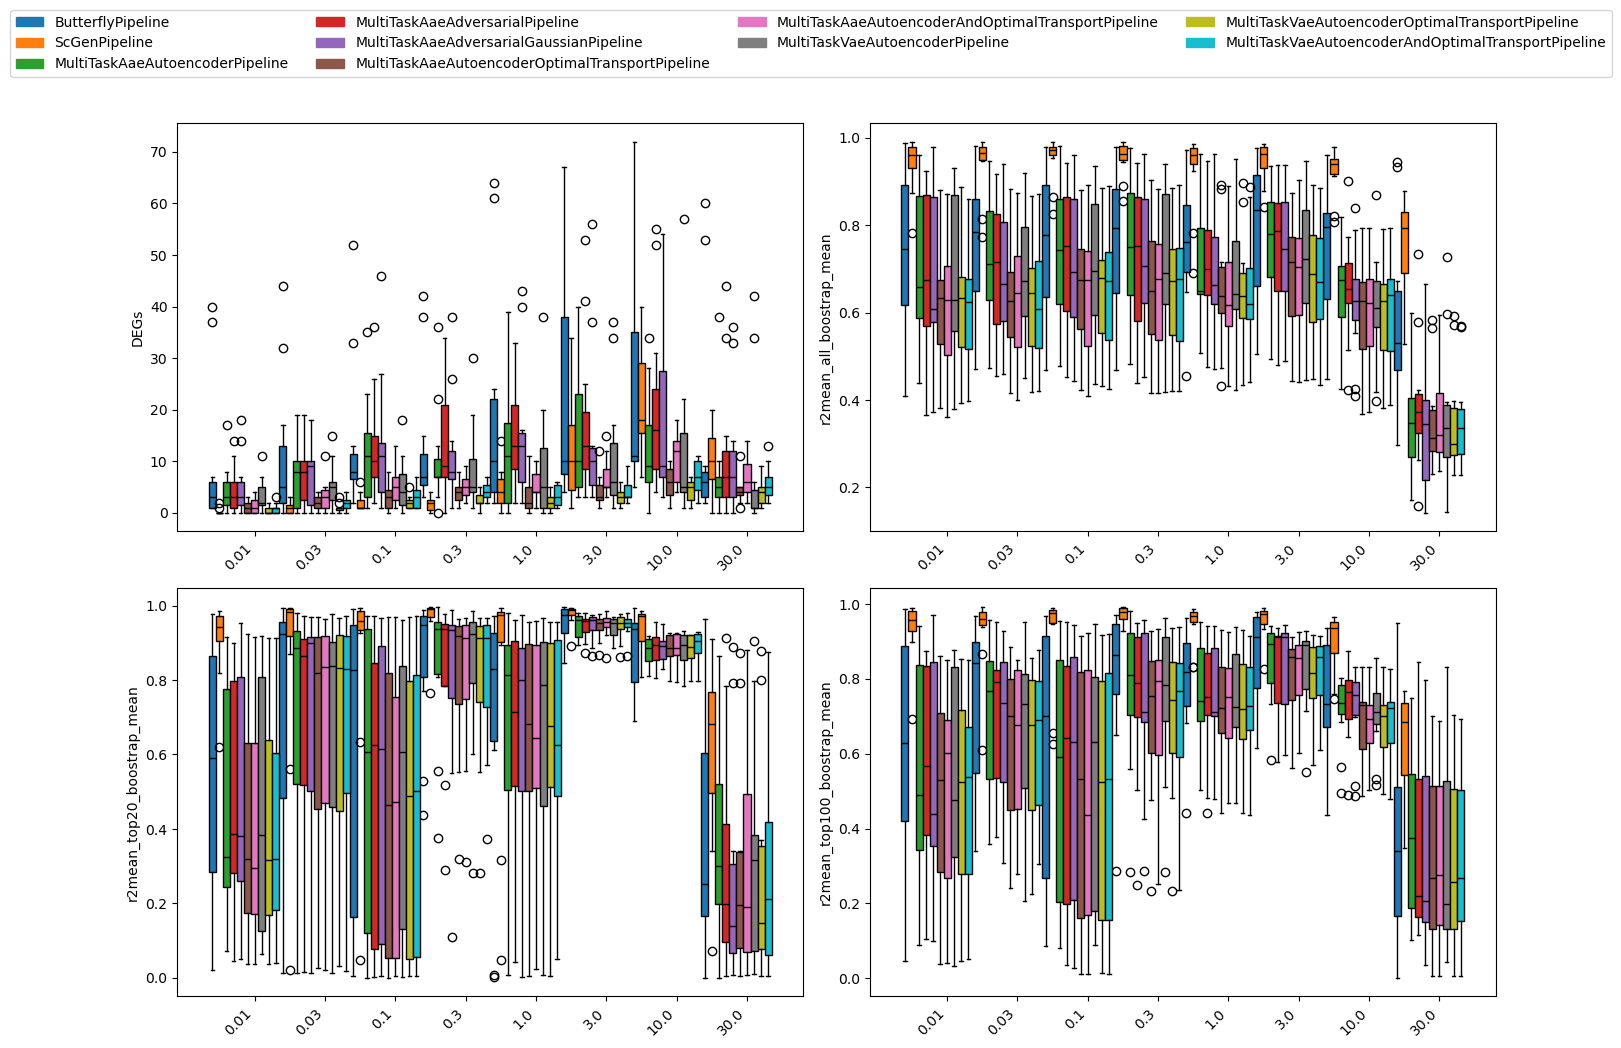

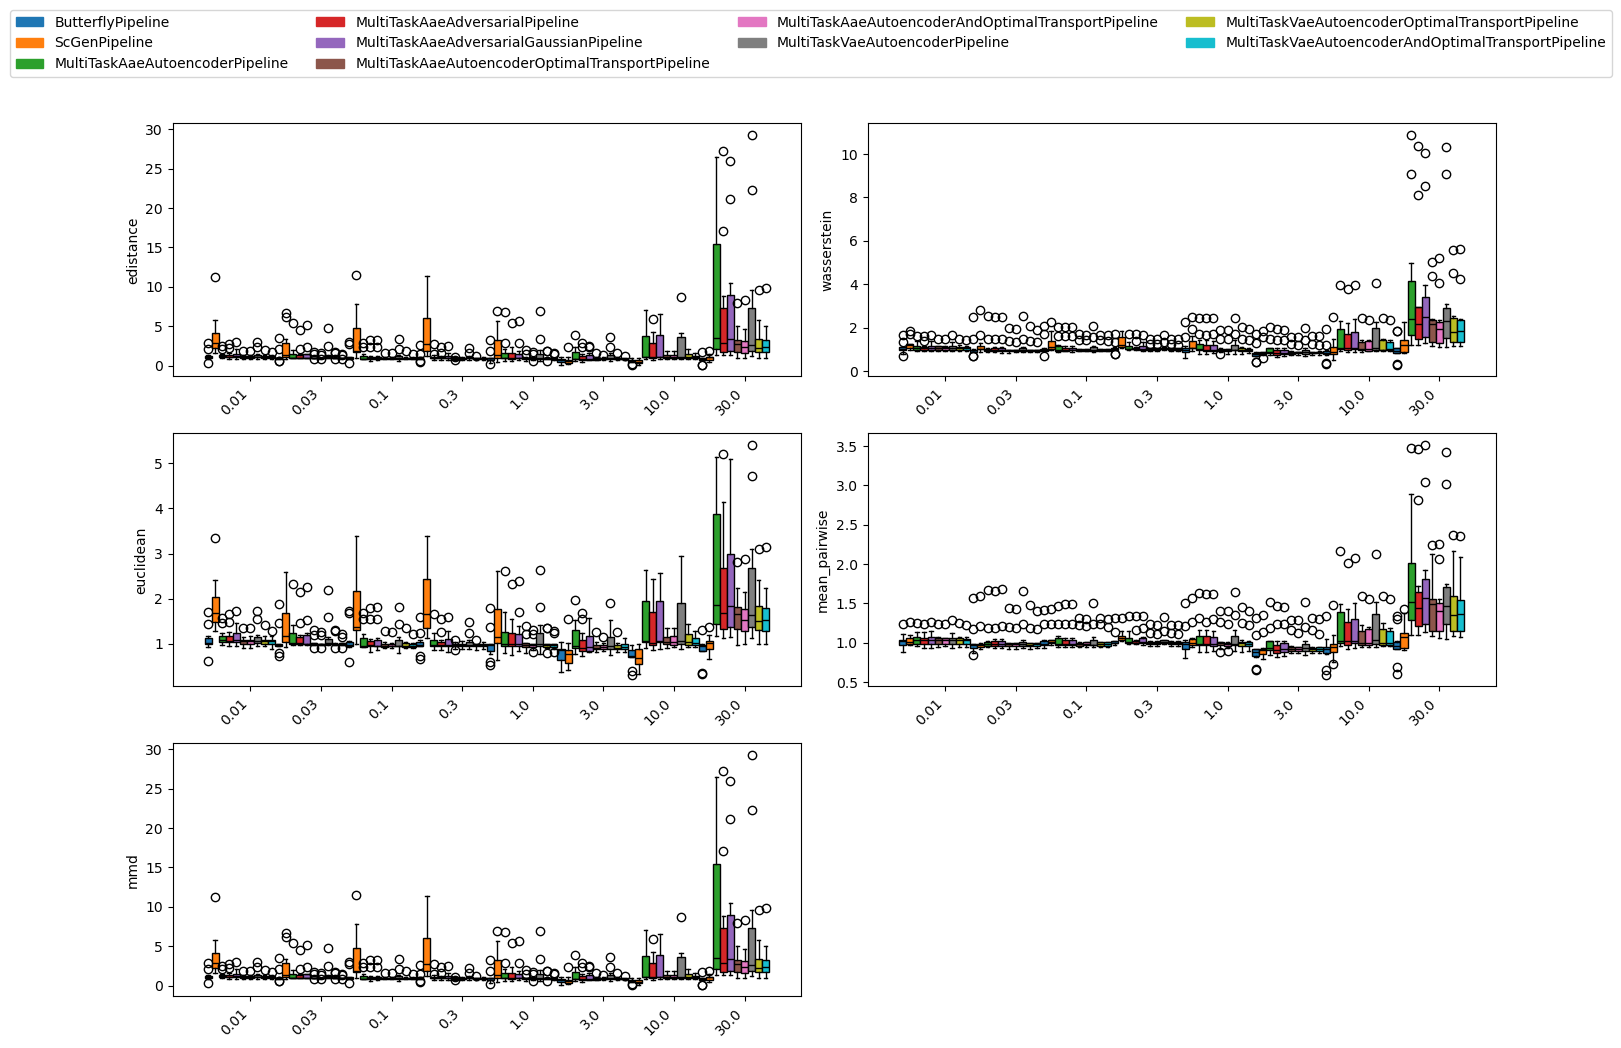

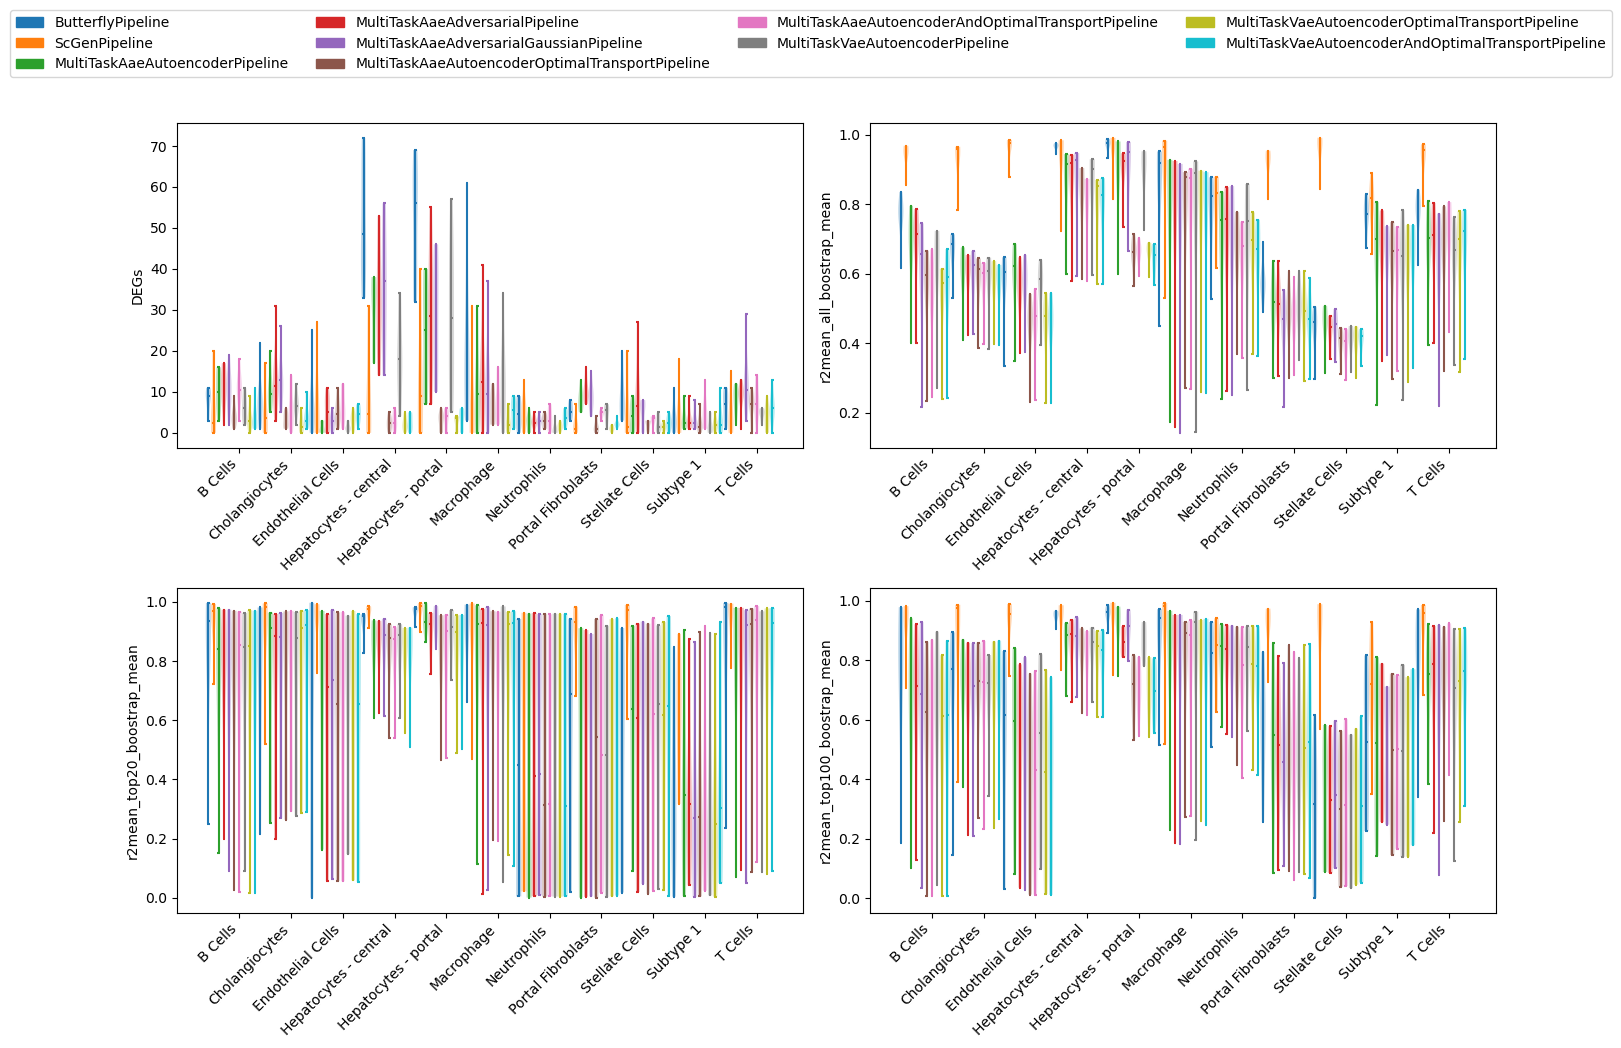

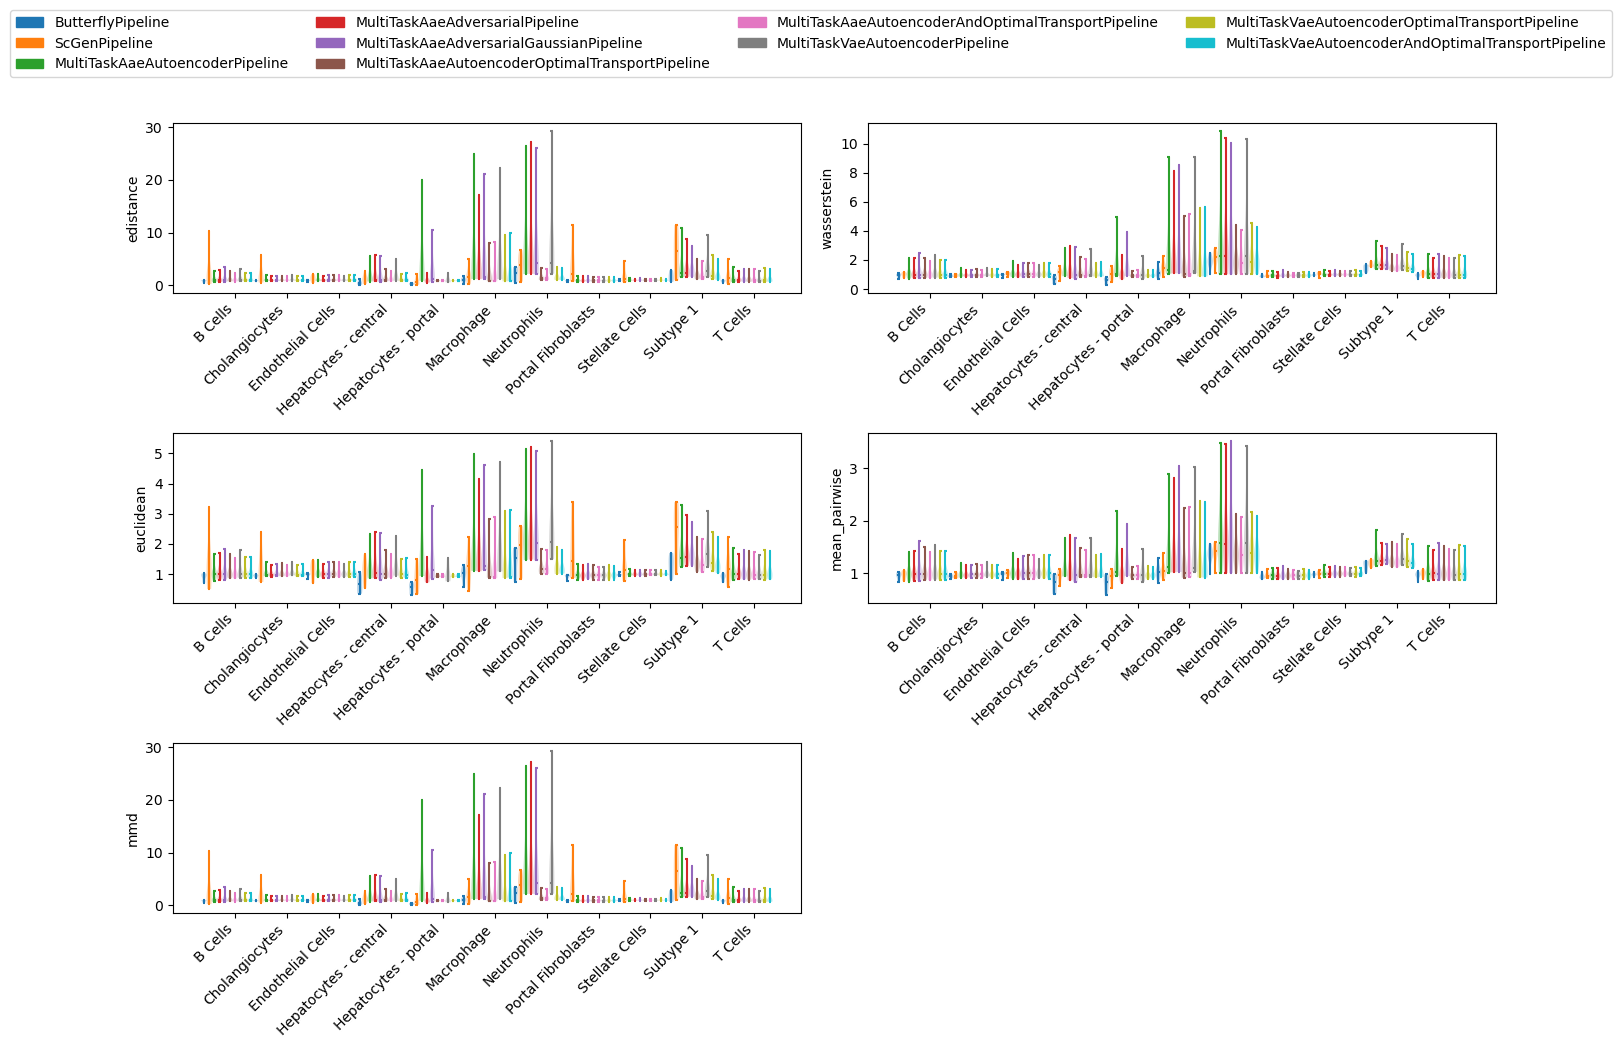

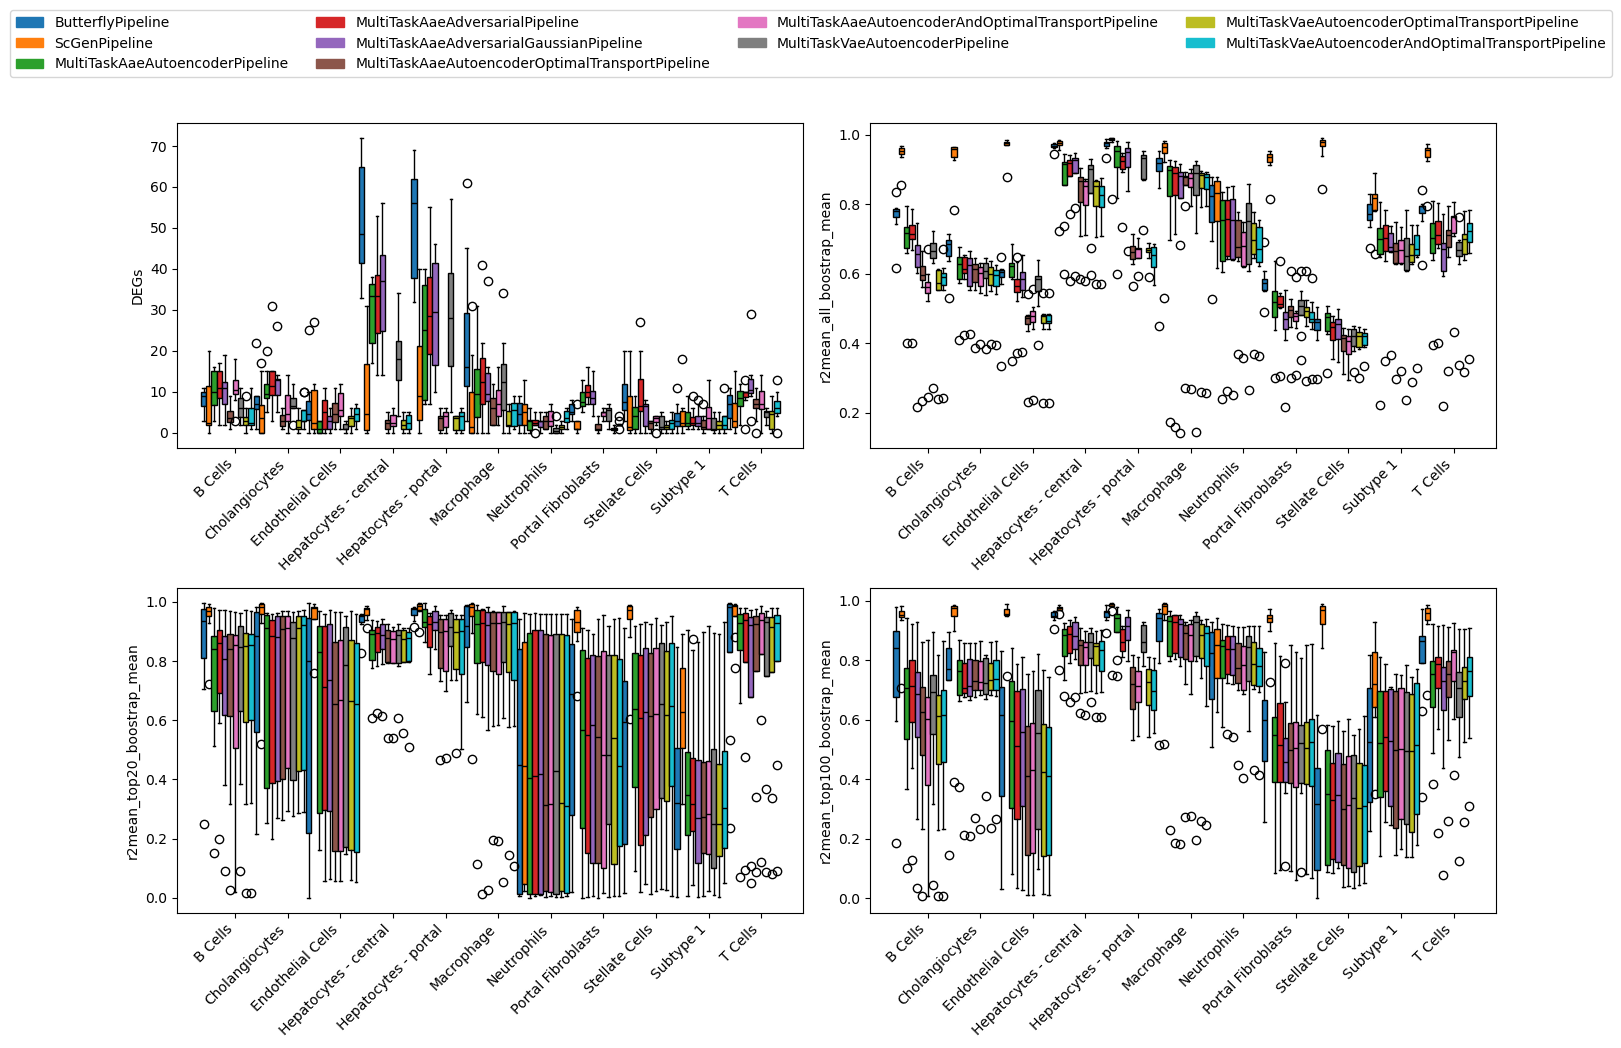

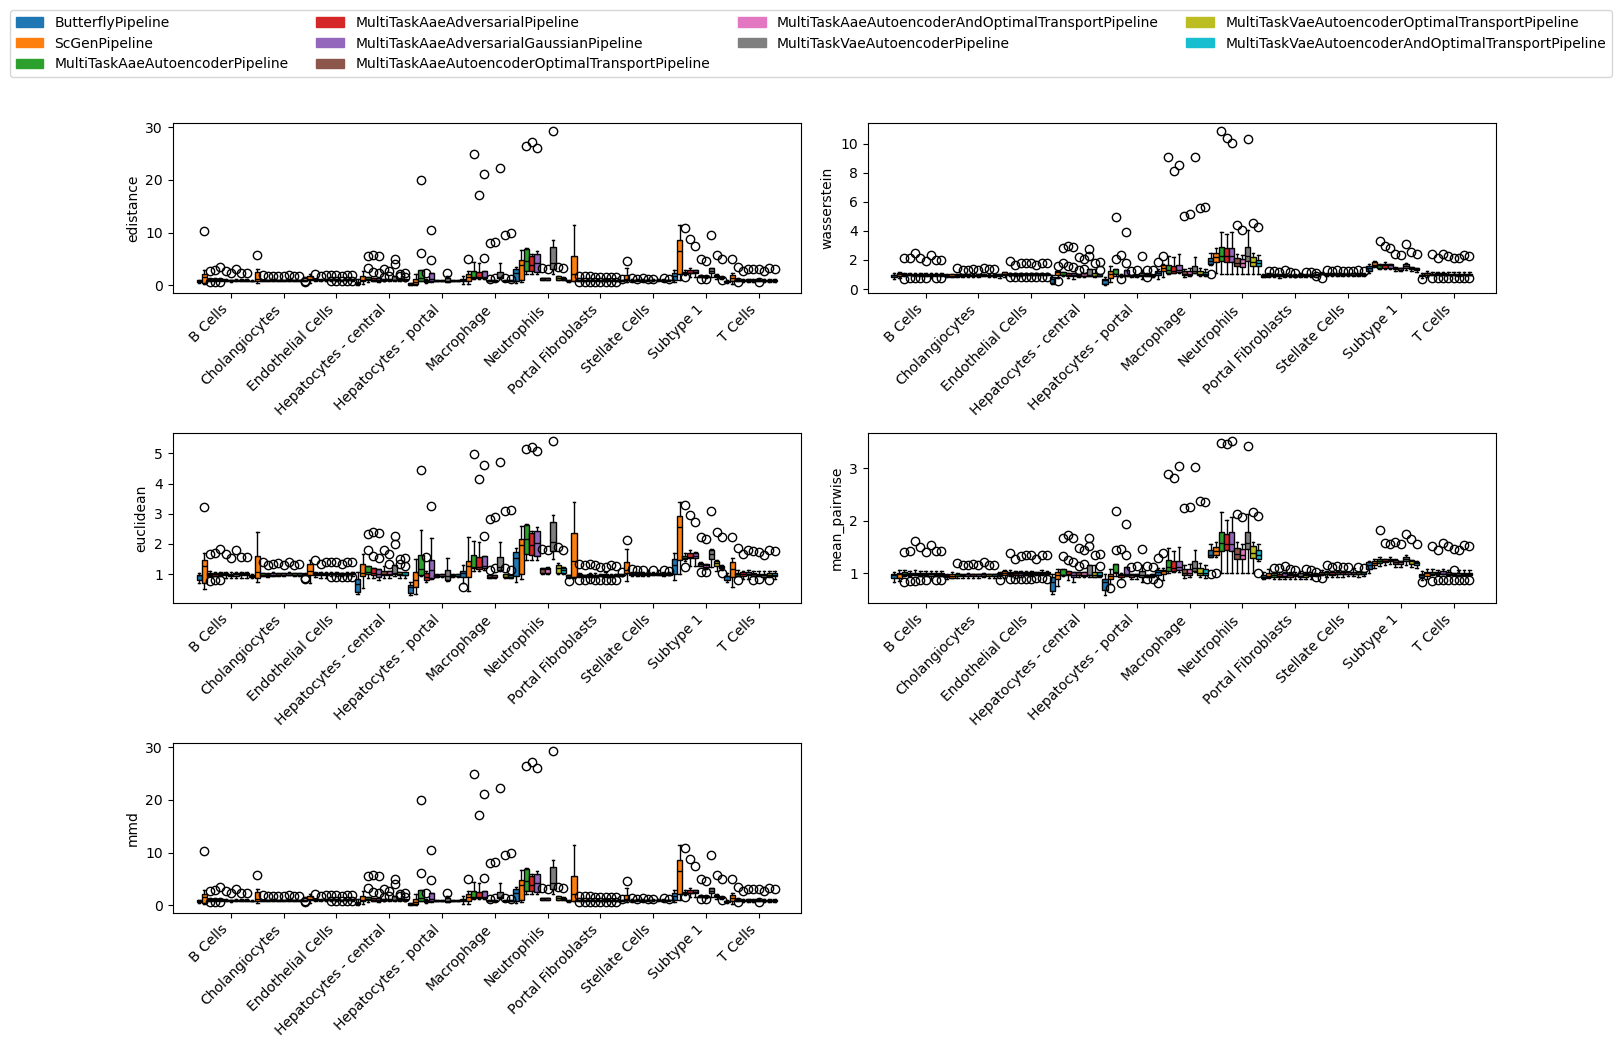

In [163]:
dim_to_reduce = [DimToReduce.X, DimToReduce.Y]
plots = [PlotType.Violin, PlotType.Boxplot]
metrics = [BASELINE_METRICS, DISTANCE_METRICS]
for dim in dim_to_reduce:
    for plot in plots:
        for idx, metric in enumerate(metrics):
            get_plot(
                datasets_name=["NaultMultiplePipeline_NaultPipeline", "NaultSinglePipeline_NaultPipeline"],
                experiment_name="seed_2",
                x_key="cell_type_test",
                y_key="dose",
                dim_to_reduce=dim,
                plot_type=plot,
                title="",
                metrics=metric,
                #file_name_to_save=f'NaultPipeline_{dim.name}_{plot.name}_metrics{idx}'
            )

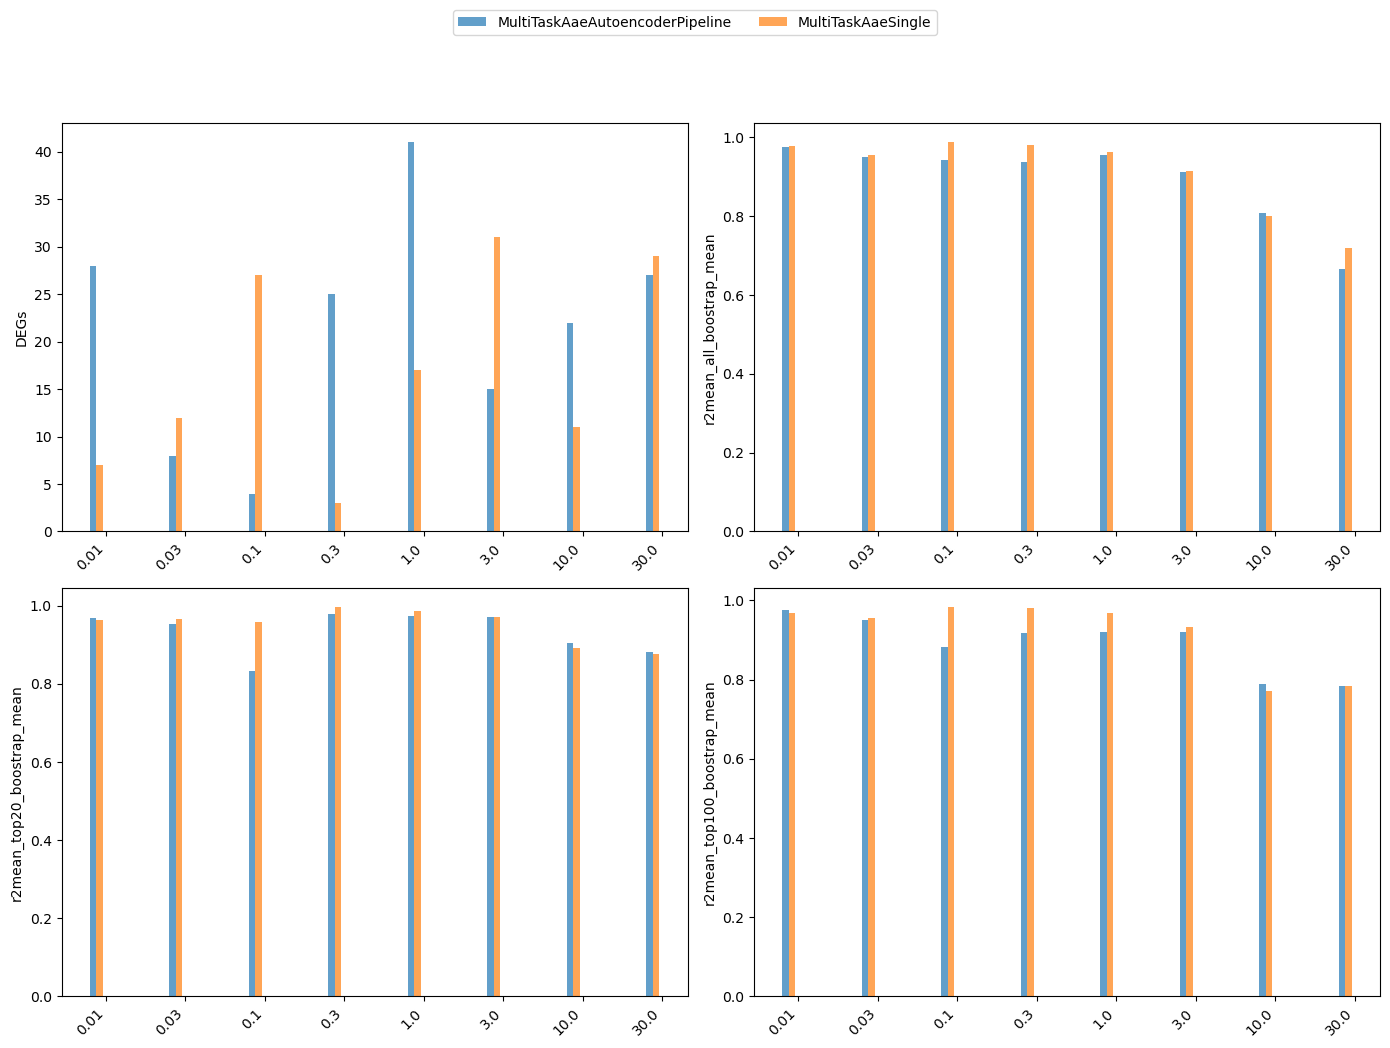

In [164]:
# compare the multi task with each single case

dataset_str = [
    "NaultMultiplePipeline_NaultPipeline",
]
dataset = METRICS_DF[METRICS_DF["dataset"].isin(dataset_str)]
seed = 1
single_experiment_names = [
    "dosage_0_01",
    "dosage_0_03",
    "dosage_0_1",
    "dosage_0_3",
    "dosage_1_0",
    "dosage_3_0",
    "dosage_10_0",
    "dosage_30_0",
]
single_experiment_names = [f"{name}_{seed}" for name in single_experiment_names]
dataset.loc[dataset["experiment_name"].isin(single_experiment_names), "model"] = "MultiTaskAaeSingle"
dataset = dataset[dataset["experiment_name"].isna() | dataset["experiment_name"].isin(single_experiment_names)]

models = ["MultiTaskAaeAutoencoderPipeline", "MultiTaskAaeSingle"]

plot_2d_metrics_per_dosage(
    dataset=dataset,
    cell_type="Hepatocytes - portal",
    models=models,
    title="",
)

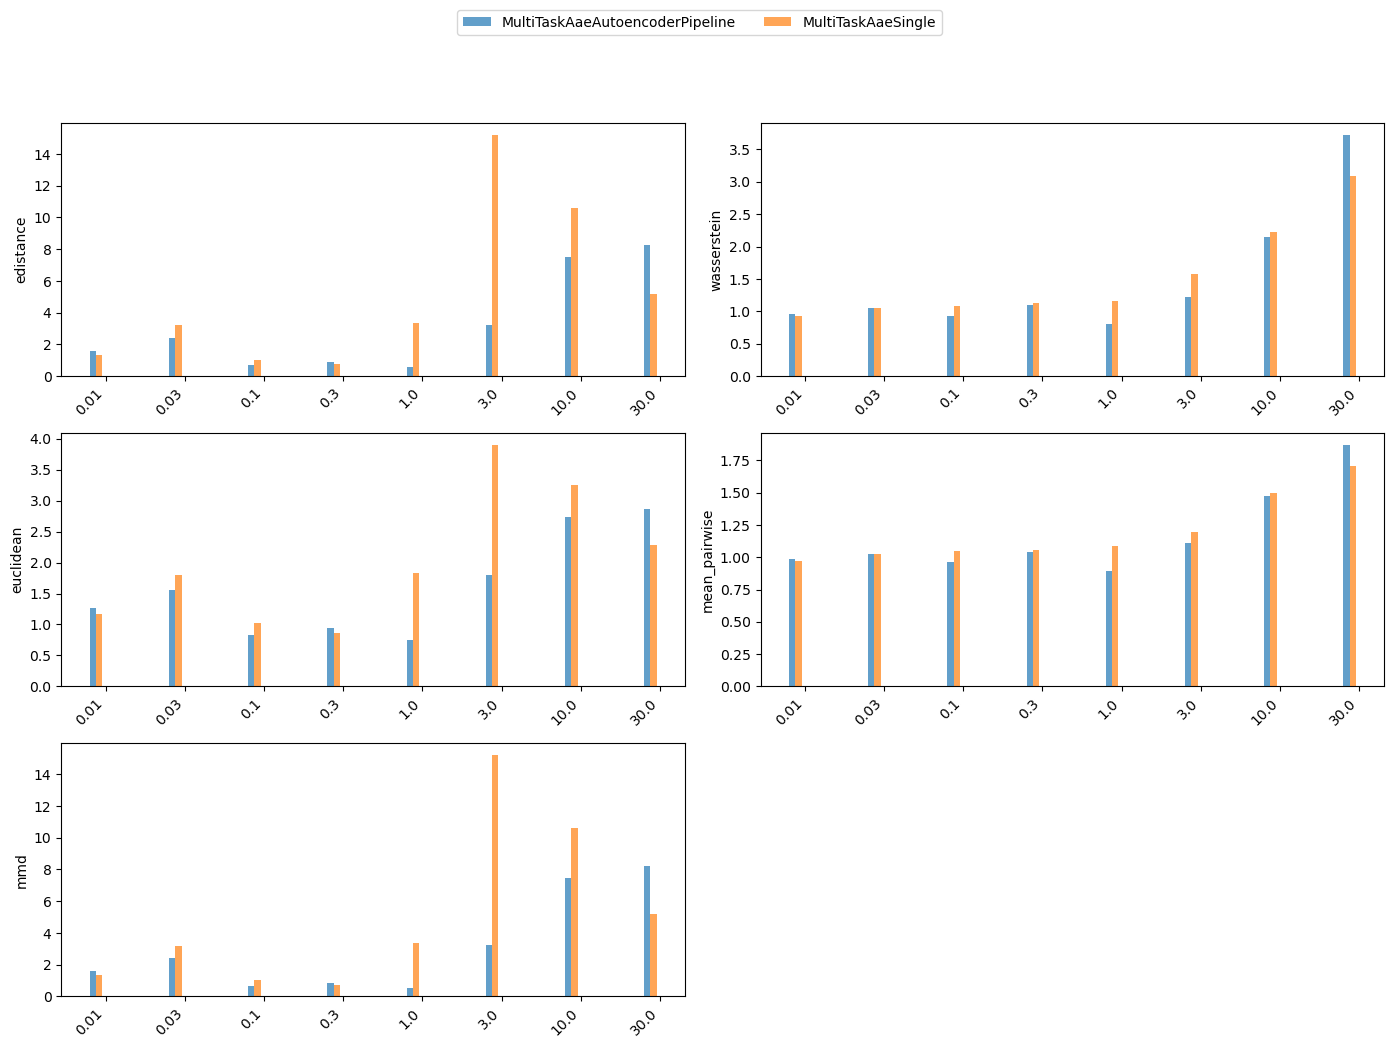

In [165]:
plot_2d_metrics_per_dosage(
    dataset=dataset,
    cell_type="Hepatocytes - portal",
    models=models,
    title="",
    metrics=DISTANCE_METRICS
)

In [220]:
def seed_utility(seed):
    dataset = METRICS_DF[METRICS_DF["model"] == "MultiTaskAaeAutoencoderPipeline"]
    dataset = dataset[dataset["experiment_name"].str.startswith("dosage_", na=False)]
    
    dataset = dataset[
        dataset["experiment_name"].str.endswith(f"_{seed}")]
    
    def extract_seed(exp_name):
        parts = exp_name.rsplit("_", 1)  # Split at the last "_"
        if len(parts) == 2 and parts[1].isdigit():
            return parts[0], int(parts[1])  # Clean name, seed as int
        return exp_name, None  # Keep original if no match

    # Apply function to create new columns
    dataset[["experiment_name", "seed"]] = dataset["experiment_name"].apply(lambda x: pd.Series(extract_seed(x)))
    return dataset

df = []
for seed in [1, 2, 19193]:
    df.append(seed_utility(seed))
filtered_dataset = pd.concat(df)

# average across seeds and calculate std
agg_dataset = filtered_dataset.groupby(["experiment_name", "dose", "model", "dataset", "cell_type_test"])[METRICS].agg(['mean', 'std']).reset_index()

new_columns = []
for col in agg_dataset.columns:
    if col[1] == "mean" or col[1] == '':
        new_columns.append(col[0])
    else:
        new_columns.append(f"{col[0]}_{col[1]}")
agg_dataset.columns = new_columns
agg_dataset

experiment_name   dose                            model  \
0              dosage_0_01   0.01  MultiTaskAaeAutoencoderPipeline   
1         dosage_0_01_0_03   0.01  MultiTaskAaeAutoencoderPipeline   
2         dosage_0_01_0_03   0.03  MultiTaskAaeAutoencoderPipeline   
3     dosage_0_01_0_03_0_1   0.01  MultiTaskAaeAutoencoderPipeline   
4     dosage_0_01_0_03_0_1   0.03  MultiTaskAaeAutoencoderPipeline   
...                    ...    ...                              ...   
1019  dosage_3_0_10_0_30_0   3.00  MultiTaskAaeAutoencoderPipeline   
1020  dosage_3_0_10_0_30_0  10.00  MultiTaskAaeAutoencoderPipeline   
1021  dosage_3_0_10_0_30_0  30.00  MultiTaskAaeAutoencoderPipeline   
1022       dosage_3_0_30_0   3.00  MultiTaskAaeAutoencoderPipeline   
1023       dosage_3_0_30_0  30.00  MultiTaskAaeAutoencoderPipeline   

                                  dataset        cell_type_test       DEGs  \
0     NaultMultiplePipeline_NaultPipeline  Hepatocytes - portal   5.333333   
1     NaultMultiplePipeline_NaultPipeline  Hepatocytes - portal   2.333333   
2     NaultMultiplePipeline_NaultPipeline  Hepatocytes - portal   7.000000   
3     NaultMultiplePipeline_NaultPipeline  Hepatocytes - portal  12.333333   
4     NaultMultiplePipeline_NaultPipeline  Hepatocytes - portal   8.000000   
...                                   ...                   ...        ...   
1019  NaultMultiplePipeline_NaultPipeline  Hepatocytes - portal  41.000000   
1020  NaultMultiplePipeline_NaultPipeline  Hepatocytes - portal  35.000000   
1021  NaultMultiplePipeline_NaultPipeline  Hepatocytes - portal  26.000000   
1022  NaultMultiplePipeline_NaultPipeline  Hepatocytes - portal  46.666667   
1023  NaultMultiplePipeline_NaultPipeline  Hepatocytes - portal  43.666667   

       DEGs_std  r2mean_all_boostrap_mean  r2mean_all_boostrap_mean_std  \
0      3.785939                  0.976771                      0.001784   
1      2.309401                  0.968721                      0.007252   
2      5.291503                  0.950829                      0.003789   
3      1.527525                  0.962286                      0.000553   
4      1.000000                  0.938152                      0.000972   
...         ...                       ...                           ...   
1019  11.532563                  0.924894                      0.026388   
1020  22.113344                  0.834401                      0.033022   
1021  15.132746                  0.659837                      0.034121   
1022   1.527525                  0.935651                      0.006301   
1023   1.527525                  0.666778                      0.007915   

      r2mean_top20_boostrap_mean  ...  edistance  edistance_std  wasserstein  \
0                       0.959596  ...   1.306252       0.231449     0.933491   
1                       0.943297  ...   1.072593       0.132960     0.911915   
2                       0.952418  ...   2.115048       0.344001     1.028694   
3                       0.924224  ...   1.153890       0.026627     0.931067   
4                       0.928009  ...   1.823104       0.061732     1.032176   
...                          ...  ...        ...            ...          ...   
1019                    0.971717  ...   3.397098       2.818217     1.175130   
1020                    0.896368  ...   7.436918       7.064954     1.877293   
1021                    0.867837  ...  18.644160      10.689268     4.290173   
1022                    0.976477  ...   2.205843       0.664878     1.078076   
1023                    0.891802  ...  12.010564       2.401289     4.132157   

      wasserstein_std  euclidean  euclidean_std  mean_pairwise  \
0            0.014845   1.139812       0.103051       0.967527   
1            0.009558   1.034373       0.063221       0.956383   
2            0.028601   1.451011       0.120085       1.011696   
3            0.004922   1.074145       0.012398       0.965104   
4            0.008847   1.350094       0.

In [249]:
import seaborn as sns

def compare(dataset, best_threshold=5, worst_threshold=5):
    best_experiments = []
    worst_experiments = []

    cell_types = dataset["cell_type_test"].unique()
    print(cell_types) # apparently I have tested only for the Hepatocytes - portal

    for idx, metrics_set in enumerate([BASELINE_METRICS, DISTANCE_METRICS]):
        best_experiments_cell_type = []
        worst_experiments_cell_type = []
        for cell_type in cell_types:
            dataset = dataset[dataset["cell_type_test"] == cell_type]
            for metric in metrics_set:
                plt.figure()
                sns.boxplot(y=dataset[metric])
                dataset = dataset.sort_values(by=[metric], ascending=False if idx == 0 else True)
                #print("best")
                #print(sorted(dataset['experiment_name'].values[:best_threshold]))
                best_experiments_cell_type.append(dataset['experiment_name'].values[:best_threshold])
                #print("worst")
                #print(sorted(dataset['experiment_name'].values[-worst_threshold:]))
                worst_experiments_cell_type.append(dataset['experiment_name'].values[-worst_threshold:])
                plt.show()
    
        best_cell_type_common_elements = set.intersection(*map(set, best_experiments_cell_type))  
        worst_cell_type_common_elements = set.intersection(*map(set, worst_experiments_cell_type))
        print("best cell type common", best_cell_type_common_elements)
        print("worst cell type common", worst_cell_type_common_elements)
        if len(best_cell_type_common_elements) == 0:
            raise ValueError("Increase best threshold")
        if len(worst_cell_type_common_elements) == 0:
            raise ValueError("Increase worst threshold")
        best_experiments.append(list(best_cell_type_common_elements))
        worst_experiments.append(list(worst_cell_type_common_elements))
        
    best_common_elements = set.intersection(*map(set, best_experiments))  
    worst_common_elements = set.intersection(*map(set, worst_experiments))    
    print("best for all metrics set common", best_common_elements)
    print("worst for all metrics set common", worst_common_elements)
    return best_common_elements, worst_common_elements

def compare_combinations_with_aggregation(dose: float, best_threshold=5, worst_threshold=5):
    dataset = agg_dataset[agg_dataset["dose"] == dose]
    return compare(dataset, best_threshold, worst_threshold)

def compare_combinations(seed: int, dose: float, best_threshold=5, worst_threshold=5):
    dataset = METRICS_DF[METRICS_DF["model"] == "MultiTaskAaeAutoencoderPipeline"]
    dataset = dataset[dataset["experiment_name"].str.startswith("dosage_", na=False)]

    dataset = dataset[
        dataset["experiment_name"].str.endswith(f"_{seed}")
    ]

    # experiments per dose
    dataset = dataset[dataset["dose"] == dose]
    print("Num of experiments", len(dataset["experiment_name"].unique()))
    compare(dataset, best_threshold, worst_threshold)

Num of experiments 128
['Hepatocytes - portal']


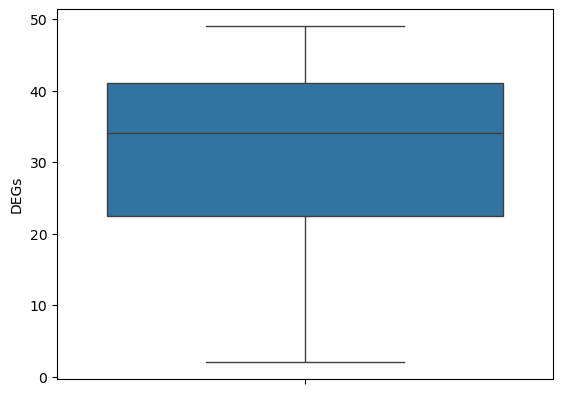

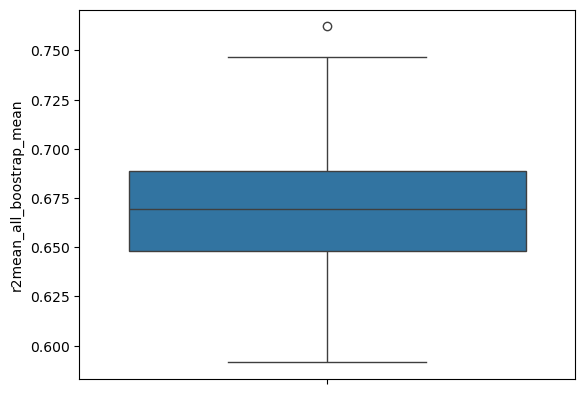

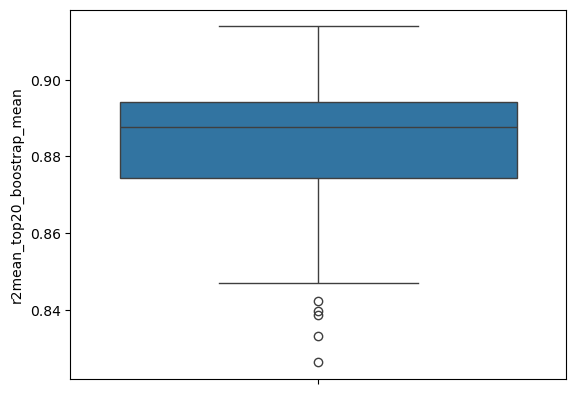

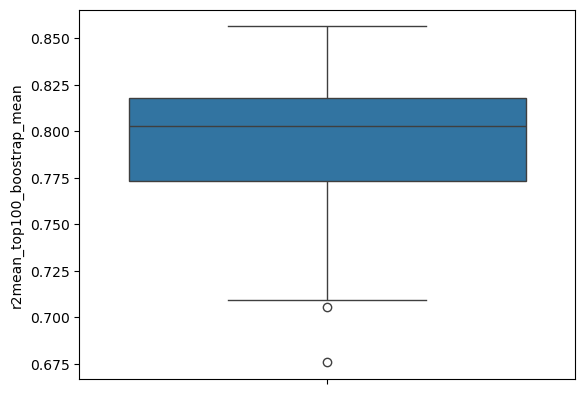

best cell type common {'dosage_0_1_0_3_10_0_30_0_1'}
worst cell type common {'dosage_0_01_0_1_0_3_1_0_10_0_30_0_1'}


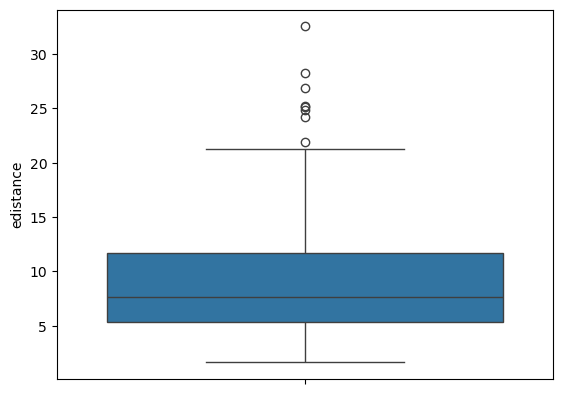

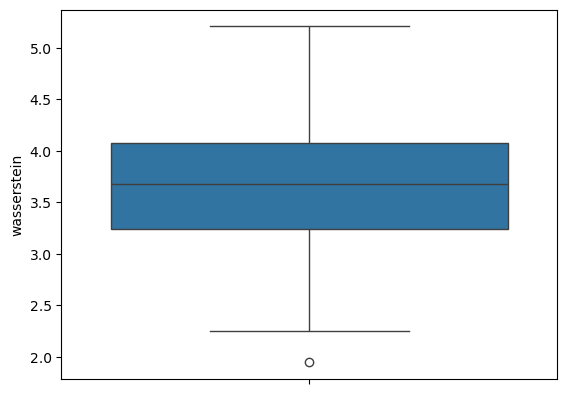

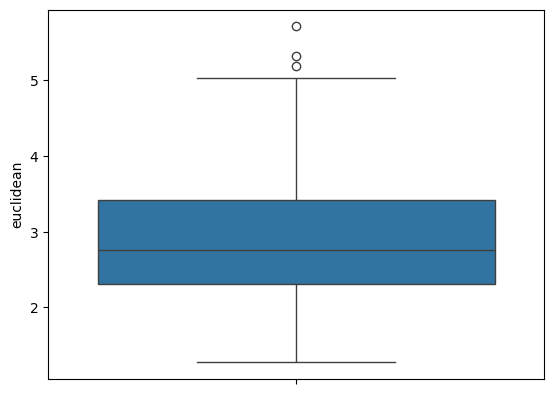

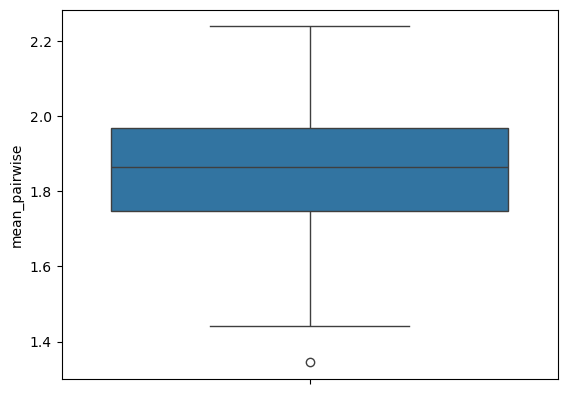

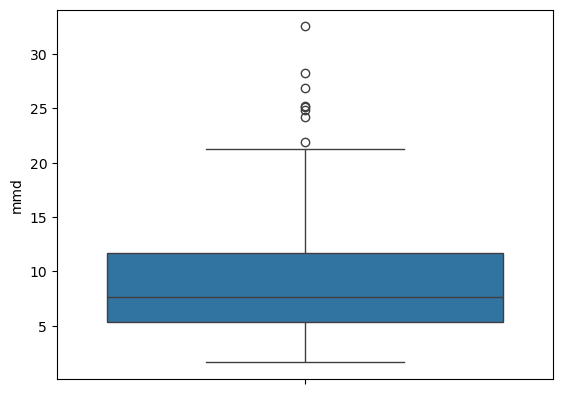

best cell type common {'dosage_0_1_1_0_3_0_10_0_30_0_1', 'dosage_1_0_3_0_10_0_30_0_1', 'dosage_0_1_0_3_10_0_30_0_1', 'dosage_0_01_0_03_0_1_3_0_10_0_30_0_1', 'dosage_1_0_10_0_30_0_1'}
worst cell type common {'dosage_0_01_0_1_0_3_1_0_10_0_30_0_1', 'dosage_0_3_10_0_30_0_1', 'dosage_0_03_0_1_0_3_1_0_10_0_30_0_1'}
best for all cell types common {'dosage_0_1_0_3_10_0_30_0_1'}
worst for all cell types common {'dosage_0_01_0_1_0_3_1_0_10_0_30_0_1'}


In [209]:
compare_combinations(seed=1, dose=30)

Num of experiments 128
['Hepatocytes - portal']


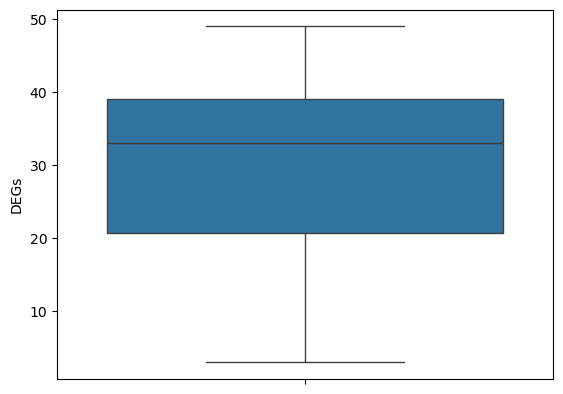

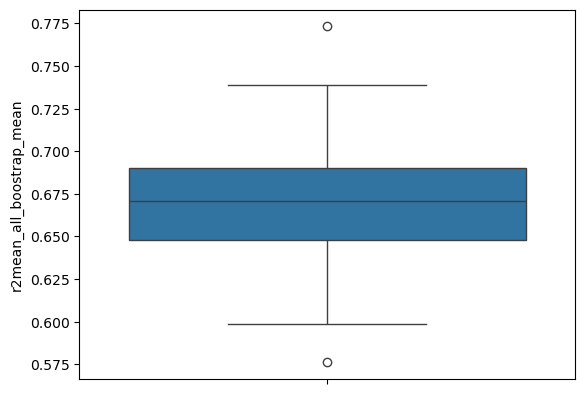

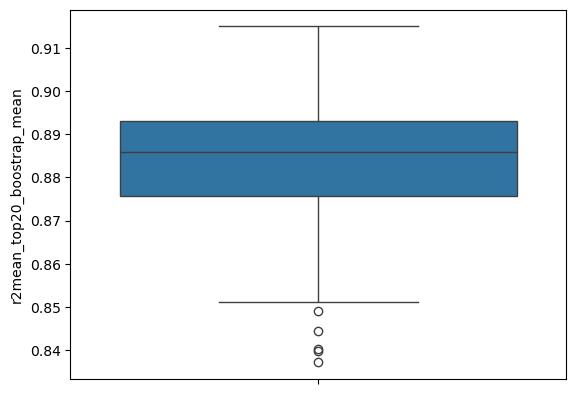

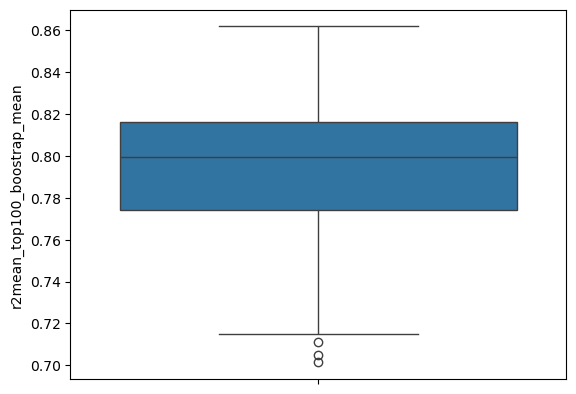

best cell type common {'dosage_0_3_3_0_10_0_30_0_2', 'dosage_0_01_0_3_10_0_30_0_2'}
worst cell type common {'dosage_0_03_0_3_1_0_10_0_30_0_2'}


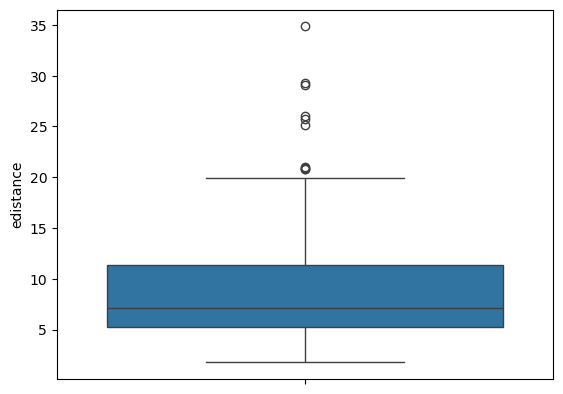

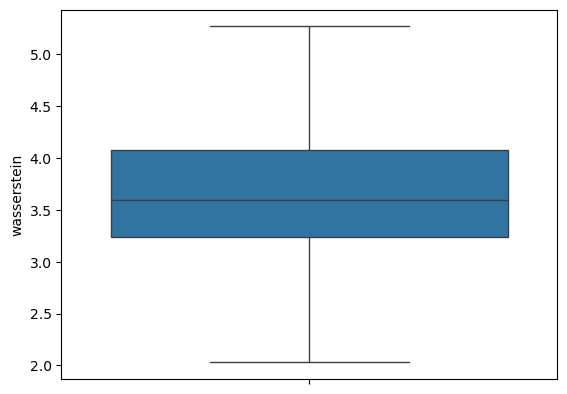

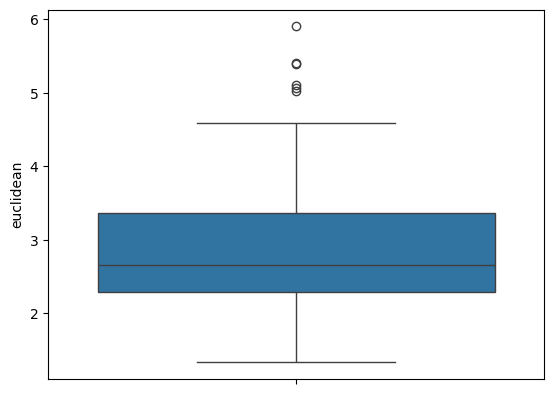

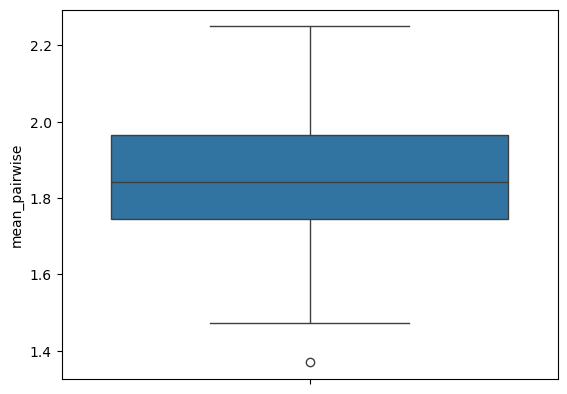

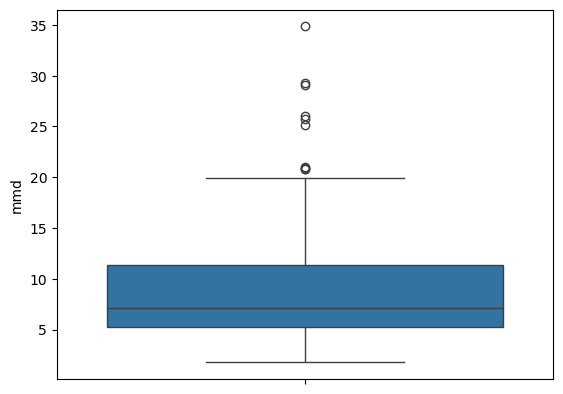

best cell type common {'dosage_0_01_0_1_0_3_3_0_30_0_2', 'dosage_0_03_0_1_1_0_30_0_2', 'dosage_0_3_3_0_10_0_30_0_2', 'dosage_0_01_0_3_10_0_30_0_2', 'dosage_0_01_0_03_0_1_1_0_3_0_10_0_30_0_2'}
worst cell type common {'dosage_0_01_1_0_10_0_30_0_2', 'dosage_0_01_0_3_1_0_10_0_30_0_2', 'dosage_0_03_0_3_1_0_10_0_30_0_2'}
best for all cell types common {'dosage_0_3_3_0_10_0_30_0_2', 'dosage_0_01_0_3_10_0_30_0_2'}
worst for all cell types common {'dosage_0_03_0_3_1_0_10_0_30_0_2'}


In [210]:
compare_combinations(seed=2, dose=30)

Num of experiments 128
['Hepatocytes - portal']


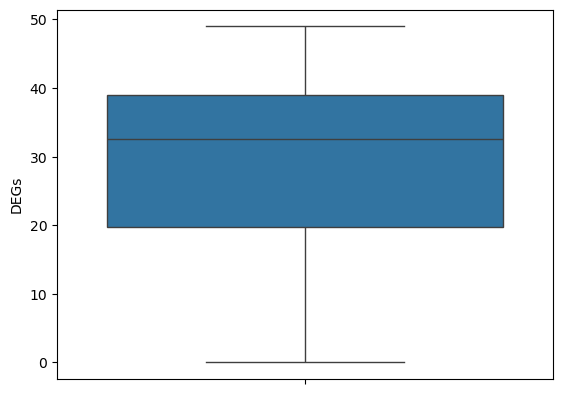

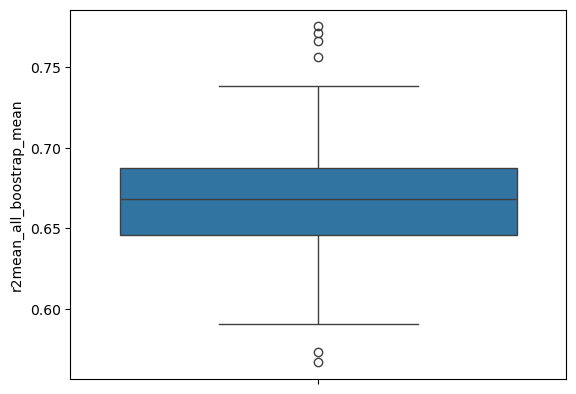

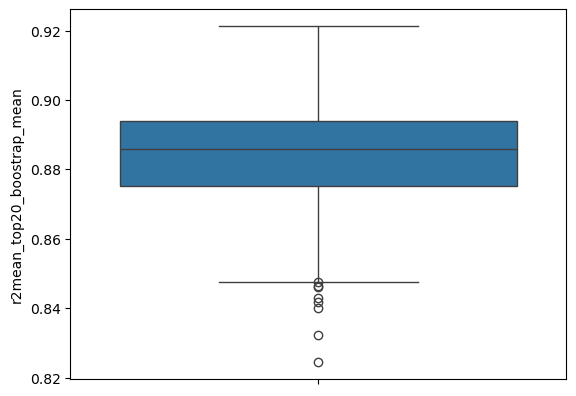

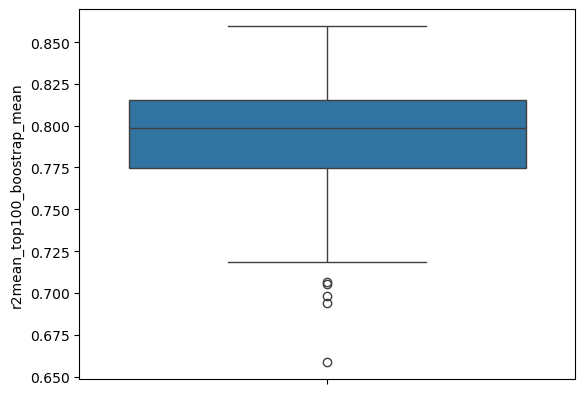

best cell type common {'dosage_0_03_0_1_3_0_10_0_30_0_19193'}
worst cell type common {'dosage_0_01_0_03_0_1_1_0_10_0_30_0_19193', 'dosage_10_0_30_0_19193', 'dosage_0_01_1_0_10_0_30_0_19193'}


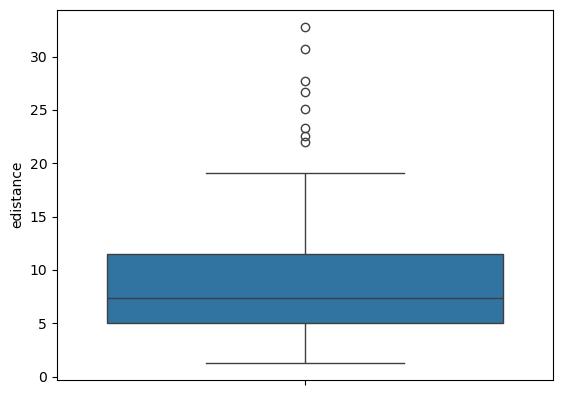

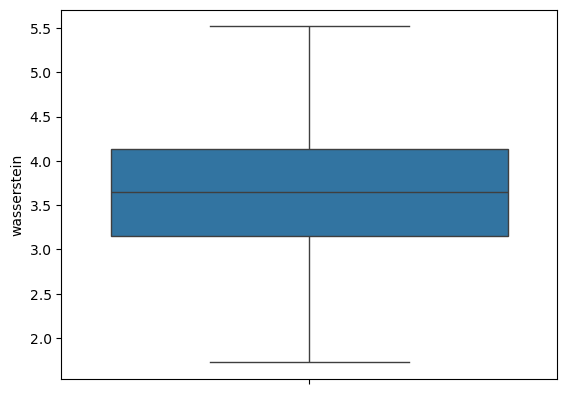

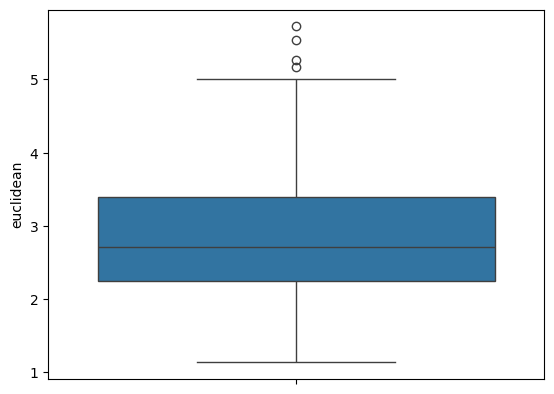

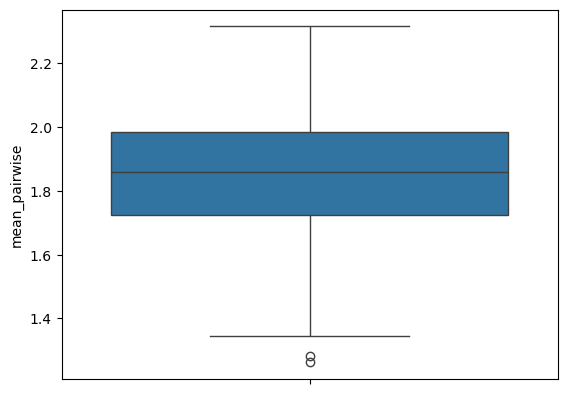

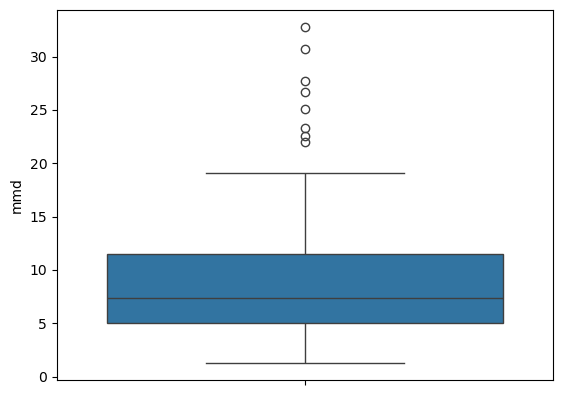

best cell type common {'dosage_1_0_3_0_10_0_30_0_19193', 'dosage_0_01_0_03_1_0_3_0_10_0_30_0_19193', 'dosage_0_03_0_3_1_0_10_0_30_0_19193', 'dosage_0_01_1_0_3_0_10_0_30_0_19193', 'dosage_0_03_0_1_3_0_10_0_30_0_19193'}
worst cell type common {'dosage_0_01_0_03_0_1_1_0_10_0_30_0_19193', 'dosage_10_0_30_0_19193', 'dosage_0_01_0_1_0_3_1_0_3_0_10_0_30_0_19193'}
best for all cell types common {'dosage_0_03_0_1_3_0_10_0_30_0_19193'}
worst for all cell types common {'dosage_0_01_0_03_0_1_1_0_10_0_30_0_19193', 'dosage_10_0_30_0_19193'}


In [211]:
compare_combinations(seed=19193, dose=30)

['Hepatocytes - portal']


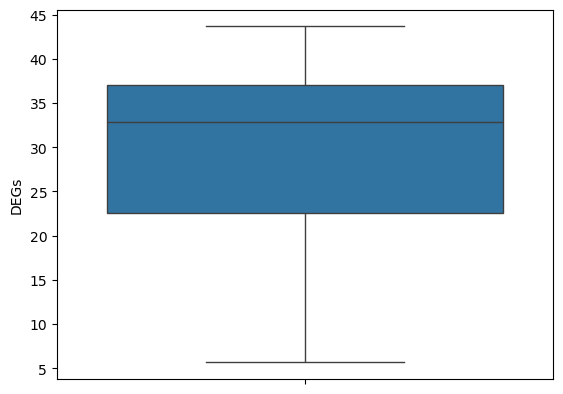

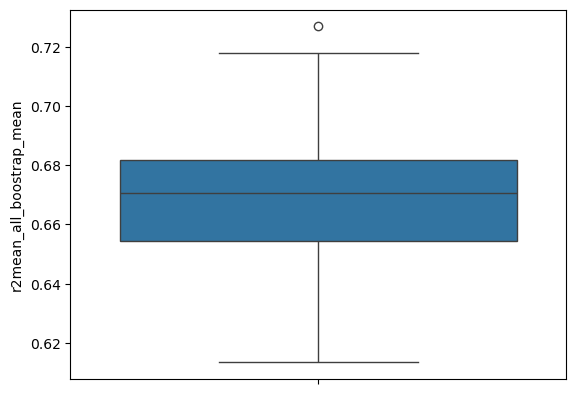

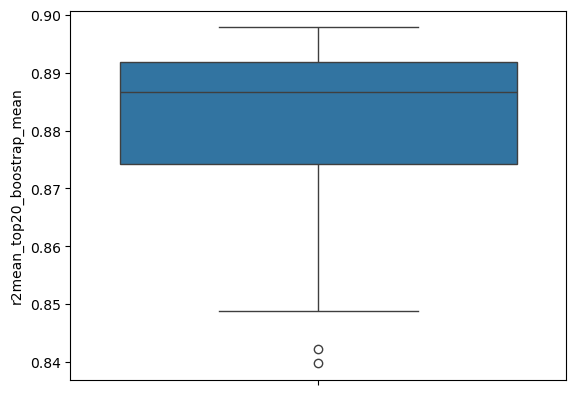

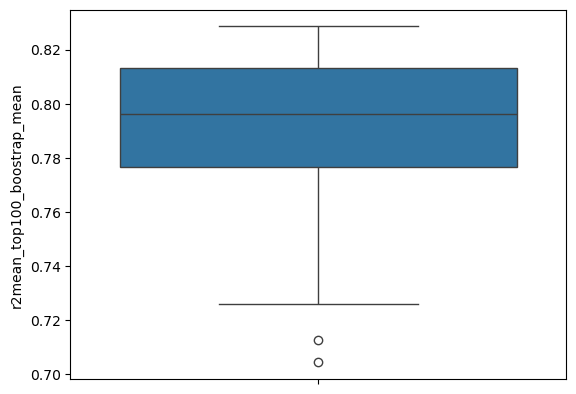

best cell type common {'dosage_0_03_0_3_3_0_30_0'}
worst cell type common {'dosage_0_01_0_03_0_1_1_0_10_0_30_0', 'dosage_0_03_0_1_1_0_10_0_30_0', 'dosage_0_01_1_0_10_0_30_0', 'dosage_0_01_0_1_0_3_1_0_10_0_30_0', 'dosage_0_1_10_0_30_0', 'dosage_0_3_10_0_30_0', 'dosage_0_01_0_03_10_0_30_0', 'dosage_10_0_30_0'}


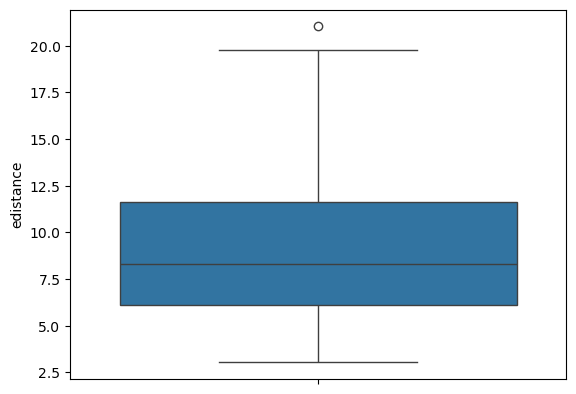

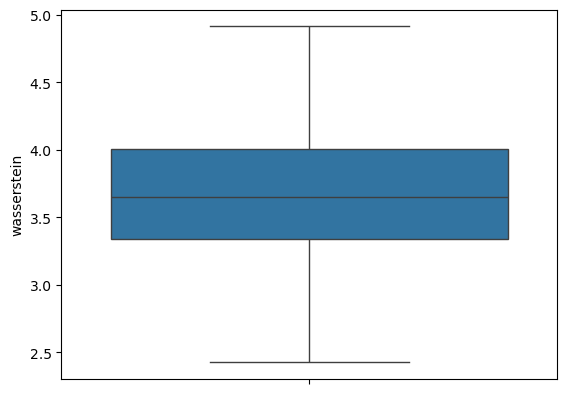

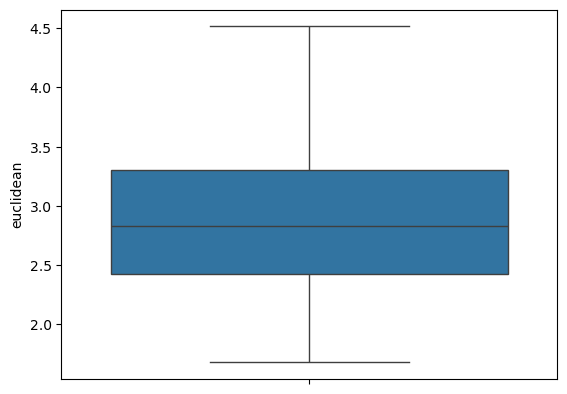

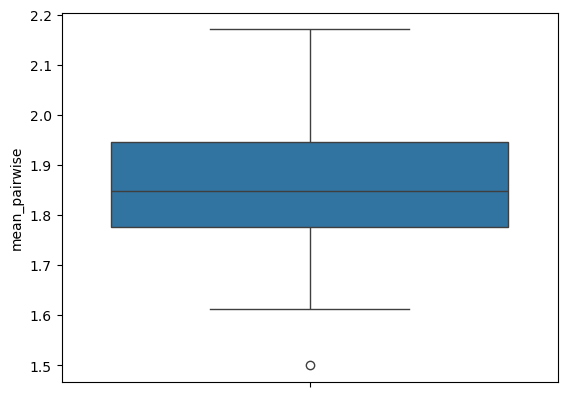

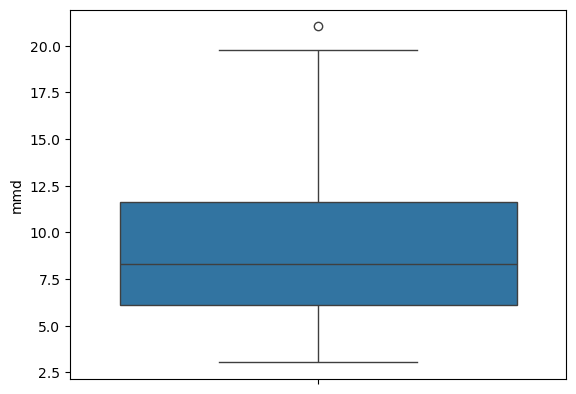

best cell type common {'dosage_0_01_0_03_0_1_0_3_3_0_30_0', 'dosage_0_03_0_1_1_0_30_0', 'dosage_0_03_0_1_0_3_3_0_30_0', 'dosage_0_01_0_1_0_3_3_0_30_0', 'dosage_0_01_0_03_0_1_1_0_3_0_30_0', 'dosage_1_0_3_0_10_0_30_0', 'dosage_0_03_0_3_3_0_30_0', 'dosage_0_01_3_0_30_0', 'dosage_0_01_0_03_0_1_3_0_10_0_30_0', 'dosage_0_03_0_1_1_0_3_0_30_0', 'dosage_0_1_3_0_30_0'}
worst cell type common {'dosage_0_01_0_03_0_1_1_0_10_0_30_0', 'dosage_0_03_0_1_1_0_10_0_30_0', 'dosage_0_01_1_0_10_0_30_0', 'dosage_0_03_0_3_3_0_10_0_30_0', 'dosage_0_3_10_0_30_0', 'dosage_0_01_0_03_10_0_30_0', 'dosage_10_0_30_0'}
best for all cell types common {'dosage_0_03_0_3_3_0_30_0'}
worst for all cell types common {'dosage_0_01_0_03_0_1_1_0_10_0_30_0', 'dosage_0_03_0_1_1_0_10_0_30_0', 'dosage_0_01_1_0_10_0_30_0', 'dosage_0_3_10_0_30_0', 'dosage_0_01_0_03_10_0_30_0', 'dosage_10_0_30_0'}


({'dosage_0_03_0_3_3_0_30_0'},
 {'dosage_0_01_0_03_0_1_1_0_10_0_30_0',
  'dosage_0_01_0_03_10_0_30_0',
  'dosage_0_01_1_0_10_0_30_0',
  'dosage_0_03_0_1_1_0_10_0_30_0',
  'dosage_0_3_10_0_30_0',
  'dosage_10_0_30_0'})

In [216]:
compare_combinations_with_aggregation(dose=30, best_threshold=15, worst_threshold=10)


In [218]:
best_experiment = 'dosage_0_03_0_3_3_0_30_0'
dataset = agg_dataset[agg_dataset['experiment_name'] == best_experiment]
dataset

experiment_name   dose        cell_type_test       DEGs  \
781  dosage_0_03_0_3_3_0_30_0   0.03  Hepatocytes - portal   8.333333   
782  dosage_0_03_0_3_3_0_30_0   0.30  Hepatocytes - portal  22.000000   
783  dosage_0_03_0_3_3_0_30_0   3.00  Hepatocytes - portal  43.000000   
784  dosage_0_03_0_3_3_0_30_0  30.00  Hepatocytes - portal  41.333333   

     DEGs_std  r2mean_all_boostrap_mean  r2mean_all_boostrap_mean_std  \
781  1.527525                  0.934048                      0.003496   
782  5.291503                  0.957140                      0.008718   
783  2.645751                  0.944264                      0.003168   
784  3.785939                  0.695878                      0.020644   

     r2mean_top20_boostrap_mean  r2mean_top20_boostrap_mean_std  \
781                    0.915455                        0.003912   
782                    0.984623                        0.006647   
783                    0.973042                        0.000494   
784                    0.897838                        0.001555   

     r2mean_top100_boostrap_mean  ...  edistance  edistance_std  wasserstein  \
781                     0.895471  ...   1.483386       0.136264     0.996930   
782                     0.949249  ...   0.825010       0.089116     1.101287   
783                     0.947387  ...   1.159227       0.169924     0.901305   
784                     0.818713  ...   5.083560       1.822413     3.121266   

     wasserstein_std  euclidean  euclidean_std  mean_pairwise  \
781         0.013918   1.217099       0.055548       0.996859   
782         0.059180   0.907435       0.048558       1.038189   
783         0.045692   1.074652       0.080785       0.957793   
784         0.409283   2.232226       0.388701       1.711385   

     mean_pairwise_std       mmd   mmd_std  
781           0.006814  1.483387  0.136263  
782           0.031787  0.825011  0.089116  
783           0.024928  1.159228  0.169925  
784           0.112284  5.083562  1.822414  

[4 rows x 21 columns]

In [244]:
def compare_multi_task_with_other_models(dose_to_test, best_threshold=10, worst_threshold=10):
    best_experiment_set, worst_experiment_set = compare_combinations_with_aggregation(dose=dose_to_test, best_threshold=best_threshold, worst_threshold=worst_threshold)
    dataset = agg_dataset[agg_dataset['experiment_name'] == list(best_experiment_set)[0]]
    dataset["model"] = agg_dataset["model"]
    for metric in METRICS:
        dataset[metric] = agg_dataset[metric]
        dataset["dataset"] = agg_dataset["dataset"]
        dataset["cell_type_test"] = agg_dataset["cell_type_test"]
        dataset["dose"] = agg_dataset["dose"]
    dataset = dataset[dataset["dose"] == dose_to_test]

    other_models = ["ButterflyPipeline", "VidrMultiplePipeline"]
    models_to_compare = METRICS_DF[METRICS_DF["model"].isin(other_models)]
    models_to_compare = models_to_compare[models_to_compare["dose"] == dose_to_test]
    models_to_compare = models_to_compare[
        models_to_compare["dataset"].isin(
            ["NaultSinglePipeline_NaultPipeline", "NaultMultiplePipeline_NaultPipeline"]
        )
    ]
    models_to_compare = models_to_compare[models_to_compare["experiment_name"] == "seed_1"] # this needs to be averaged
    concat_dataset = pd.concat([dataset, models_to_compare])

    plot_2d_metrics_per_dosage(
        dataset=concat_dataset,
        title="",
        cell_type="Hepatocytes - portal",
        models=["MultiTaskAaeAutoencoderPipeline"] + other_models,
        metrics=BASELINE_METRICS,
    )

    plot_2d_metrics_per_dosage(
        dataset=concat_dataset,
        title="",
        cell_type="Hepatocytes - portal",
        models=["MultiTaskAaeAutoencoderPipeline"] + other_models,
        metrics=DISTANCE_METRICS,
    )

['Hepatocytes - portal']


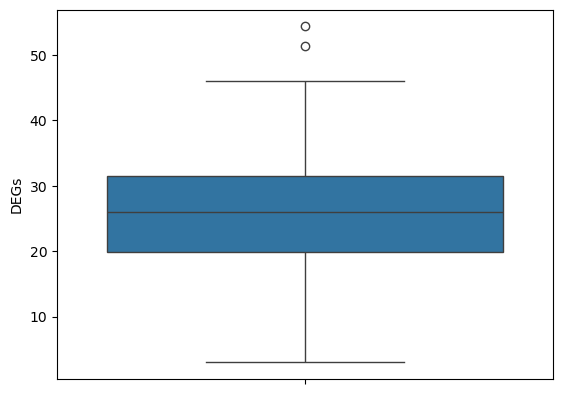

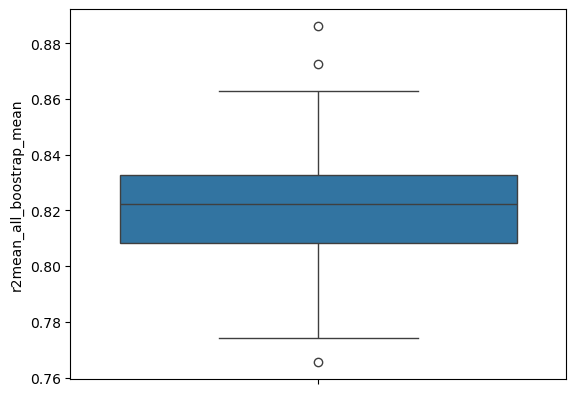

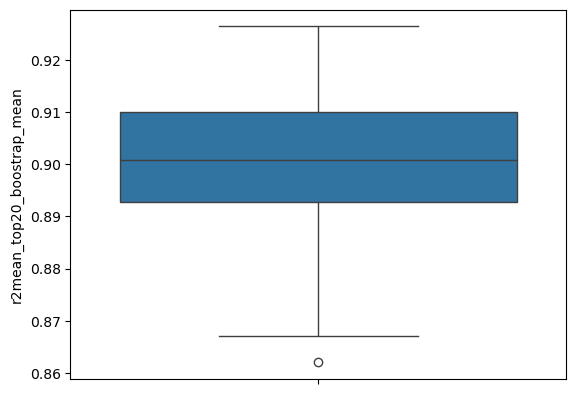

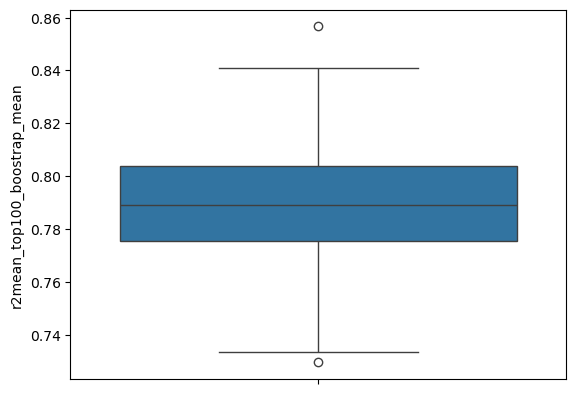

best cell type common {'dosage_0_3_3_0_10_0_30_0', 'dosage_0_01_0_03_0_3_1_0_10_0_30_0', 'dosage_1_0_10_0_30_0', 'dosage_0_1_10_0_30_0', 'dosage_0_3_1_0_10_0_30_0', 'dosage_10_0_30_0'}
worst cell type common {'dosage_0_03_10_0', 'dosage_0_3_3_0_10_0', 'dosage_0_01_0_03_10_0', 'dosage_0_03_0_3_10_0', 'dosage_0_01_0_1_10_0'}


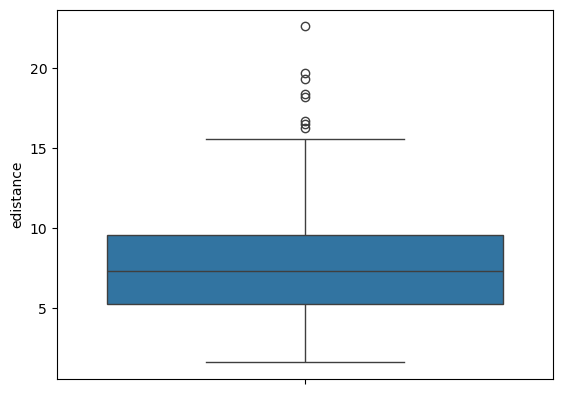

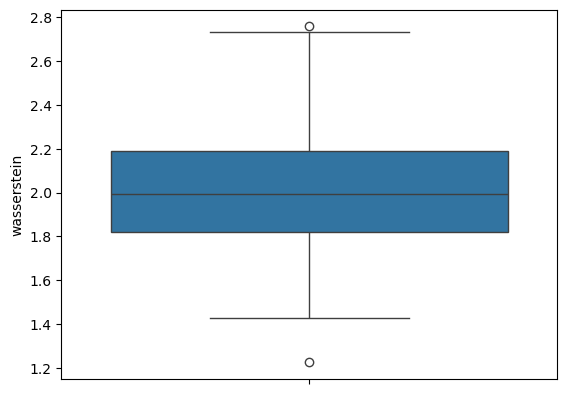

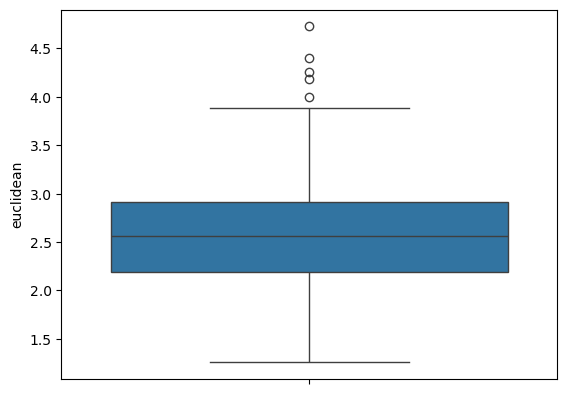

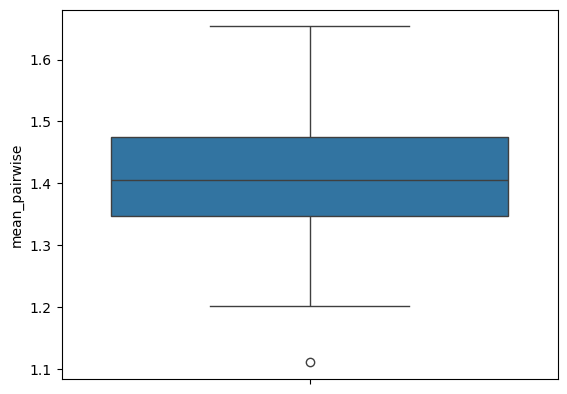

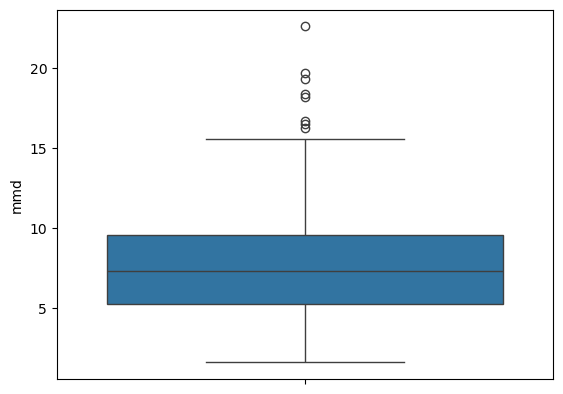

best cell type common {'dosage_0_01_0_03_0_3_1_0_10_0_30_0', 'dosage_0_01_0_1_10_0_30_0', 'dosage_0_01_0_03_0_1_0_3_10_0_30_0', 'dosage_0_03_0_3_3_0_10_0_30_0', 'dosage_0_1_10_0_30_0', 'dosage_0_01_0_03_0_1_3_0_10_0_30_0', 'dosage_10_0_30_0'}
worst cell type common {'dosage_0_3_3_0_10_0', 'dosage_0_01_3_0_10_0', 'dosage_0_03_0_3_10_0', 'dosage_0_01_0_03_10_0', 'dosage_0_1_1_0_3_0_10_0', 'dosage_3_0_10_0'}
best for all metrics set common {'dosage_0_1_10_0_30_0', 'dosage_0_01_0_03_0_3_1_0_10_0_30_0', 'dosage_10_0_30_0'}
worst for all metrics set common {'dosage_0_3_3_0_10_0', 'dosage_0_01_0_03_10_0', 'dosage_0_03_0_3_10_0'}


/tmp/ipykernel_1252850/2794771108.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset["model"] = agg_dataset["model"]
/tmp/ipykernel_1252850/2794771108.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset[metric] = agg_dataset[metric]
/tmp/ipykernel_1252850/2794771108.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-do

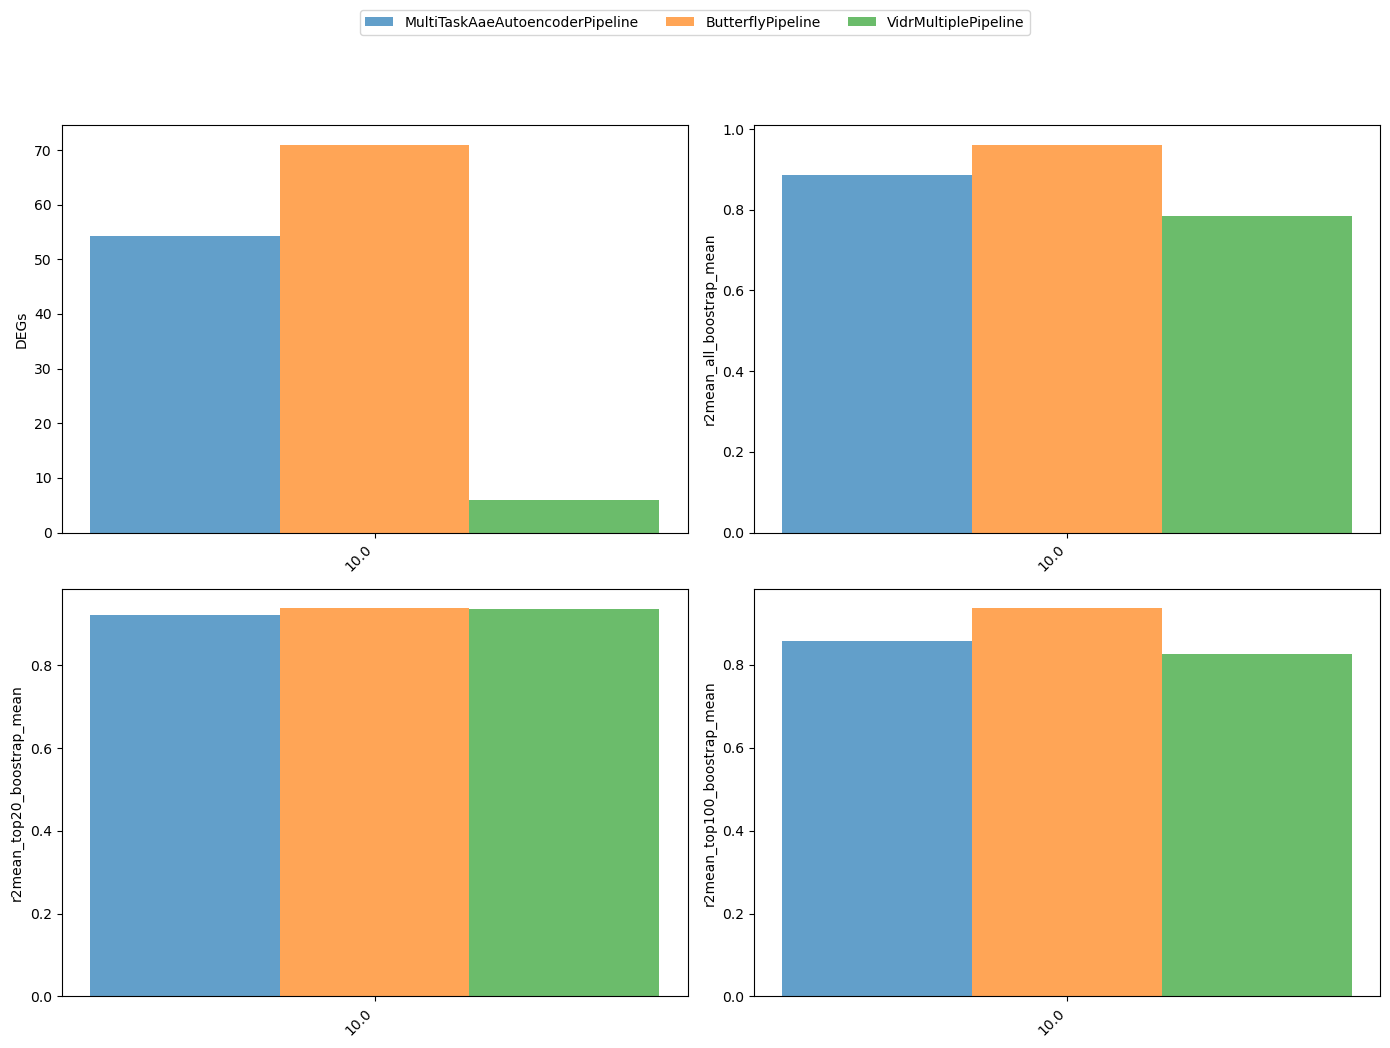

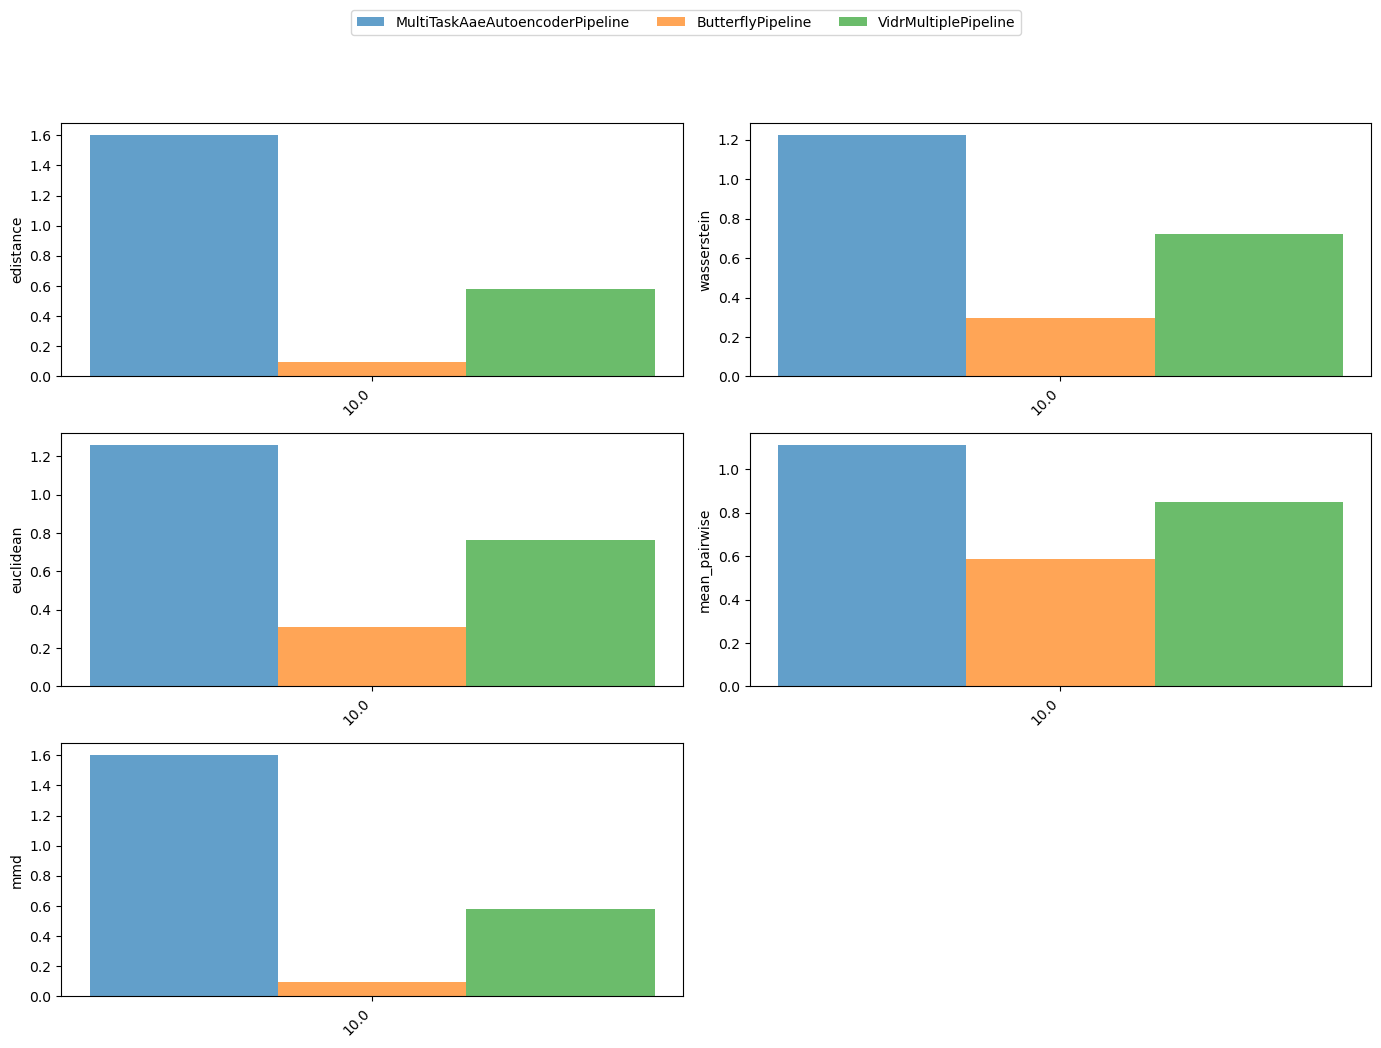

In [262]:
compare_multi_task_with_other_models(dose_to_test=10, best_threshold=10, worst_threshold=10)

['Hepatocytes - portal']


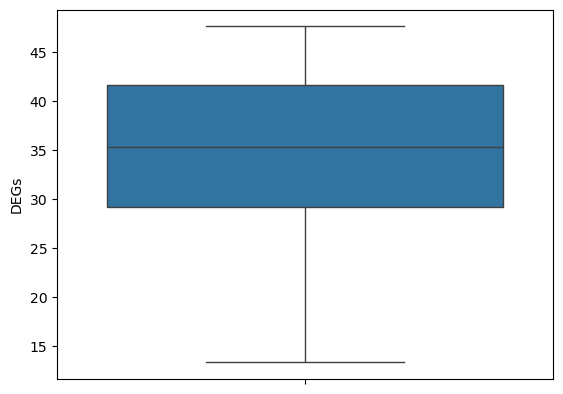

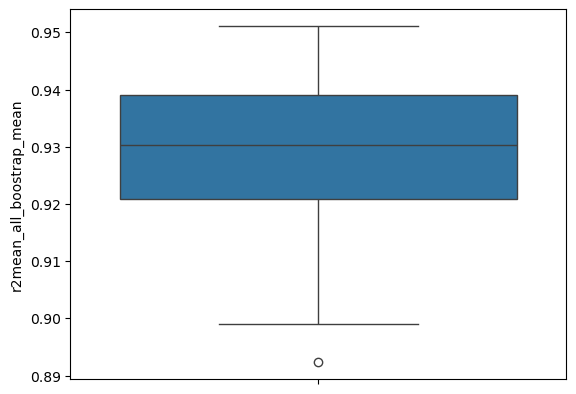

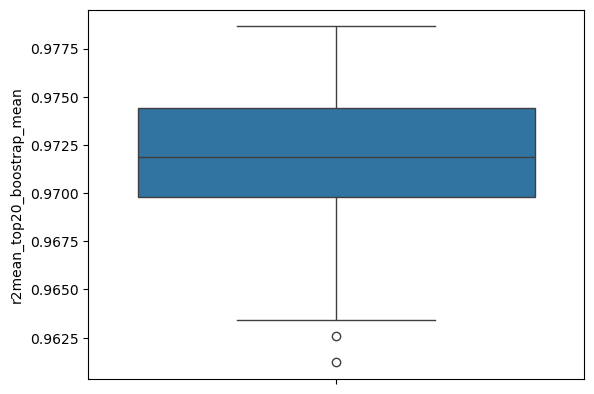

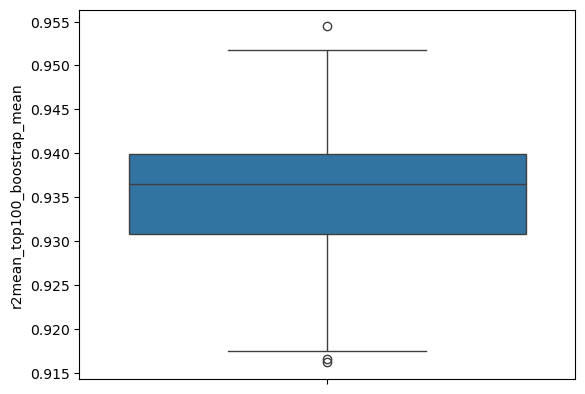

best cell type common {'dosage_0_03_0_1_0_3_1_0_3_0', 'dosage_1_0_3_0_30_0', 'dosage_0_01_0_03_0_3_1_0_3_0', 'dosage_0_03_0_3_1_0_3_0_10_0_30_0', 'dosage_0_3_1_0_3_0_30_0'}
worst cell type common {'dosage_0_03_3_0_10_0', 'dosage_0_03_0_1_0_3_3_0_10_0', 'dosage_0_01_0_03_3_0_10_0', 'dosage_0_03_0_1_3_0_10_0', 'dosage_0_01_3_0_10_0_30_0'}


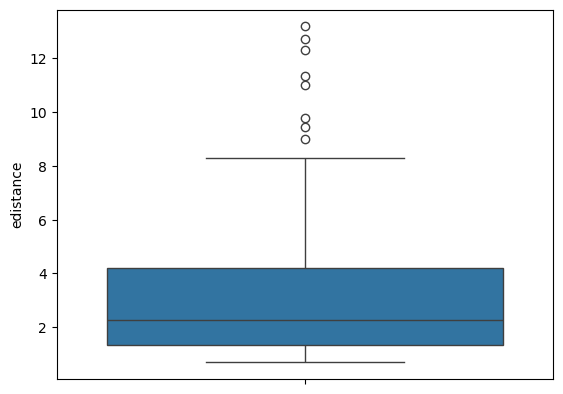

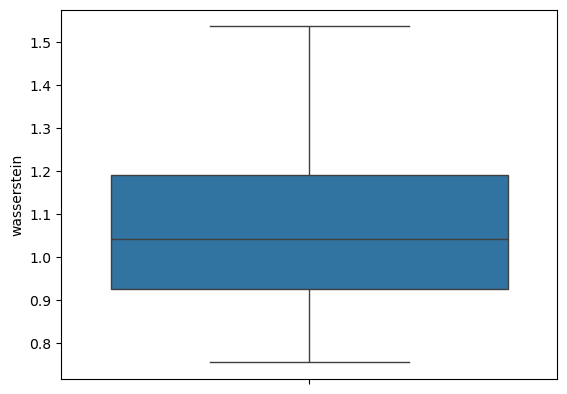

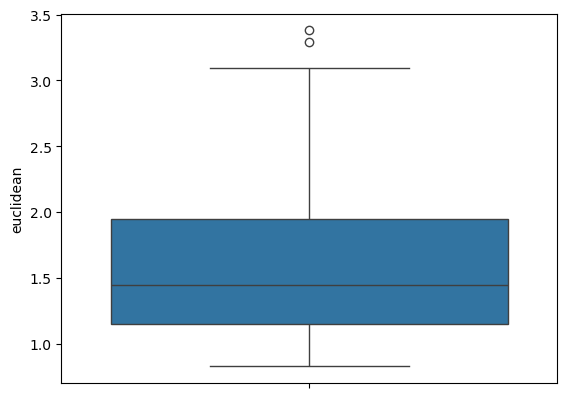

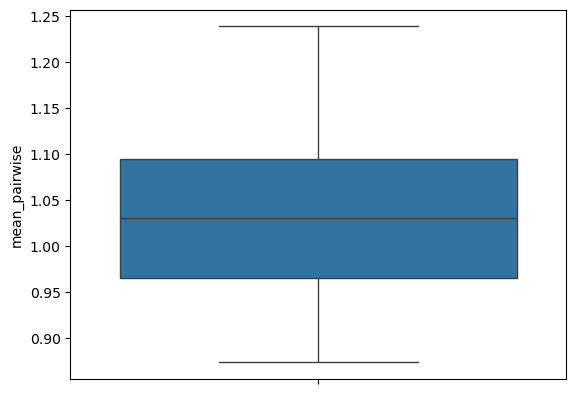

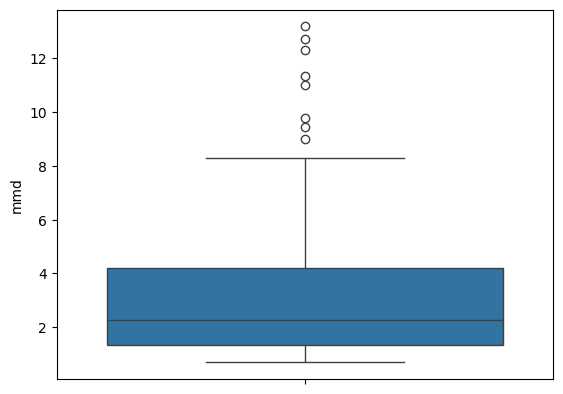

best cell type common {'dosage_0_3_3_0_30_0', 'dosage_0_01_0_03_0_1_3_0', 'dosage_0_01_0_03_0_3_1_0_3_0_10_0_30_0', 'dosage_0_01_0_03_0_3_1_0_3_0_30_0', 'dosage_0_1_3_0_30_0', 'dosage_0_03_0_1_1_0_3_0', 'dosage_0_3_1_0_3_0_30_0', 'dosage_0_01_0_3_1_0_3_0_30_0', 'dosage_0_03_0_1_1_0_3_0_10_0_30_0', 'dosage_0_01_0_1_1_0_3_0_30_0', 'dosage_0_03_0_1_0_3_3_0_30_0', 'dosage_0_01_0_03_0_1_1_0_3_0_30_0', 'dosage_0_03_1_0_3_0_30_0', 'dosage_0_03_0_3_1_0_3_0_30_0', 'dosage_0_03_0_3_3_0_30_0', 'dosage_0_01_0_03_0_3_3_0_10_0_30_0', 'dosage_0_01_0_1_0_3_1_0_3_0_30_0', 'dosage_0_01_0_03_0_1_3_0_30_0', 'dosage_0_01_0_03_0_1_0_3_3_0_30_0', 'dosage_0_1_1_0_3_0_30_0', 'dosage_0_03_0_1_0_3_1_0_3_0_30_0', 'dosage_0_1_0_3_3_0_30_0', 'dosage_0_01_0_03_1_0_3_0_30_0', 'dosage_0_03_0_1_1_0_3_0_30_0', 'dosage_0_1_0_3_1_0_3_0_30_0', 'dosage_0_01_0_03_0_3_3_0_30_0', 'dosage_0_01_0_03_0_1_0_3_1_0_3_0_30_0', 'dosage_0_01_1_0_3_0_30_0'}
worst cell type common {'dosage_0_3_3_0_10_0_30_0', 'dosage_0_01_0_1_1_0_3_0_10_

/tmp/ipykernel_1252850/2794771108.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset["model"] = agg_dataset["model"]
/tmp/ipykernel_1252850/2794771108.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset[metric] = agg_dataset[metric]
/tmp/ipykernel_1252850/2794771108.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-do

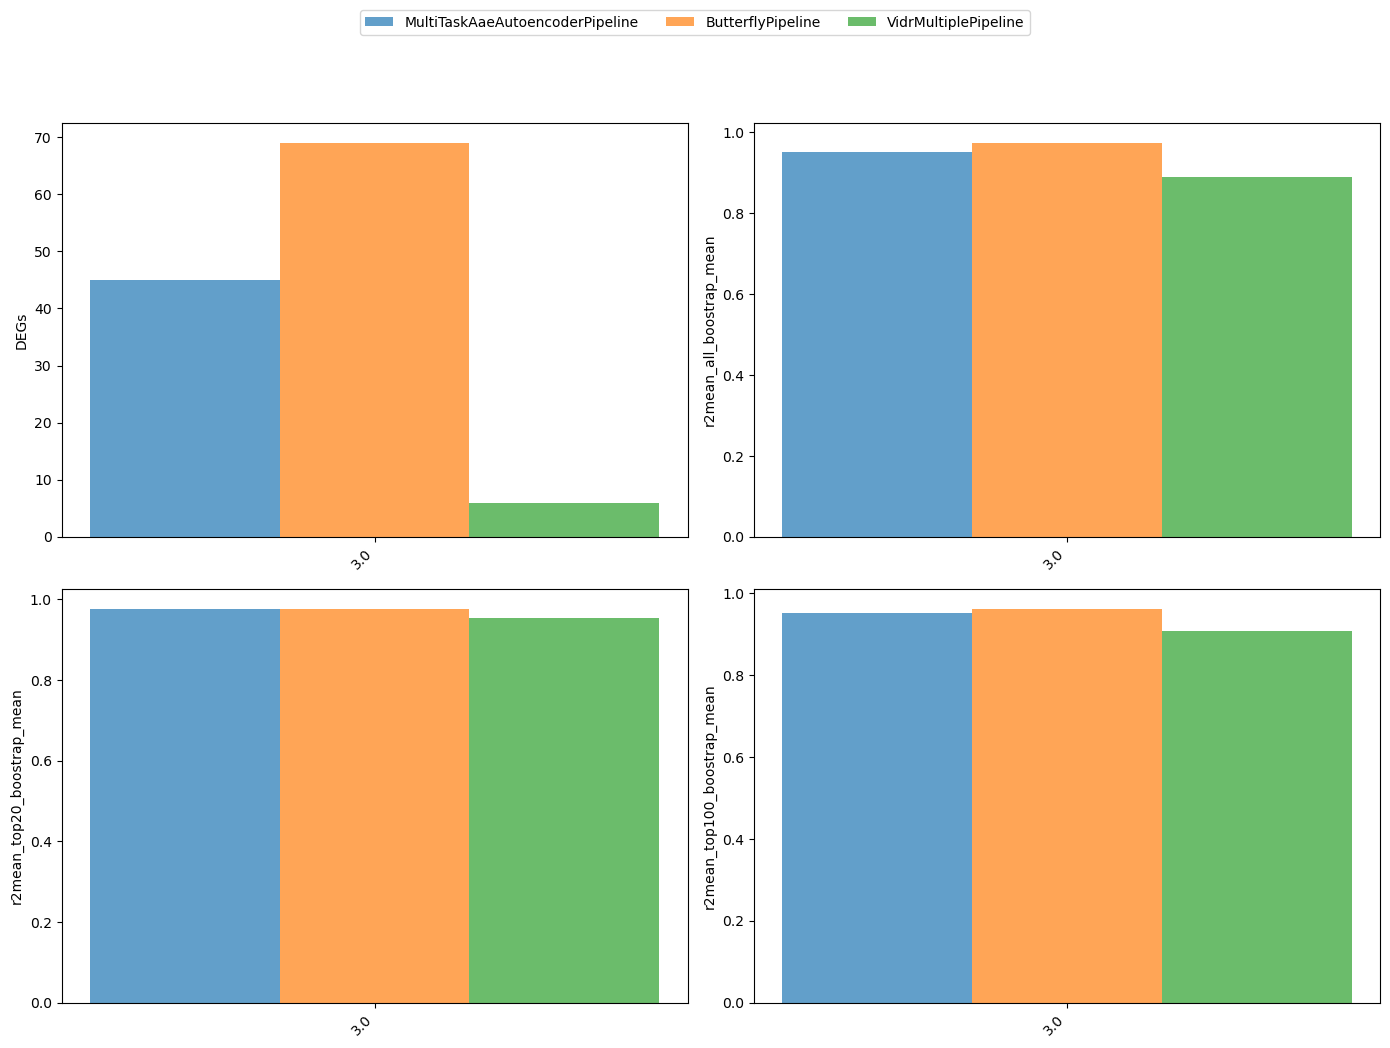

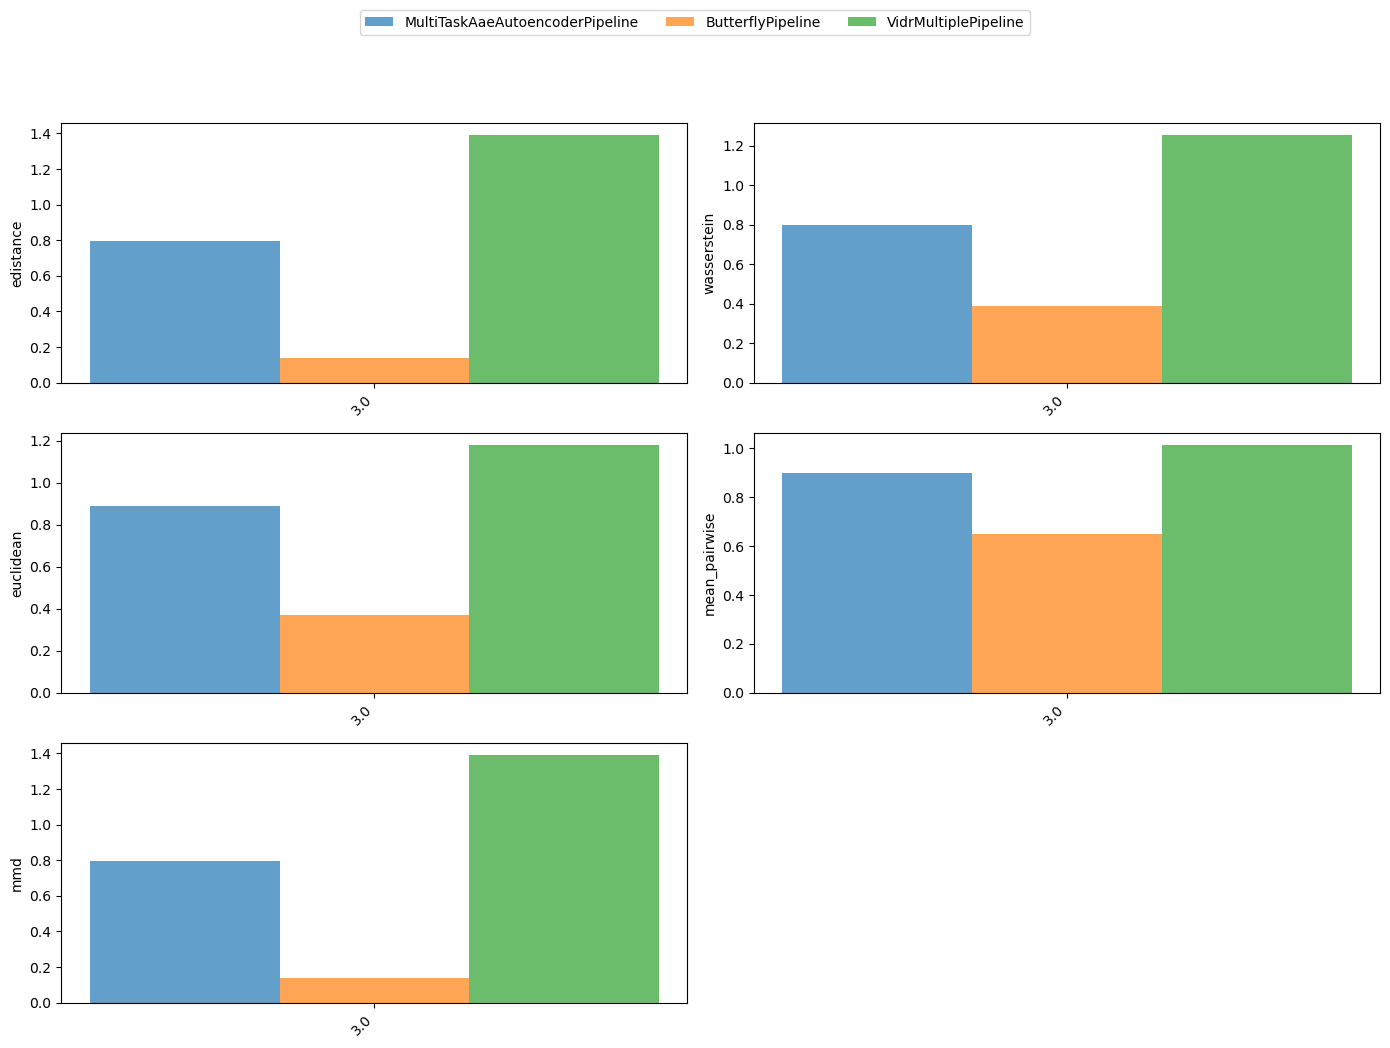

In [245]:
compare_multi_task_with_other_models(dose_to_test=3, best_threshold=30, worst_threshold=30)


['Hepatocytes - portal']


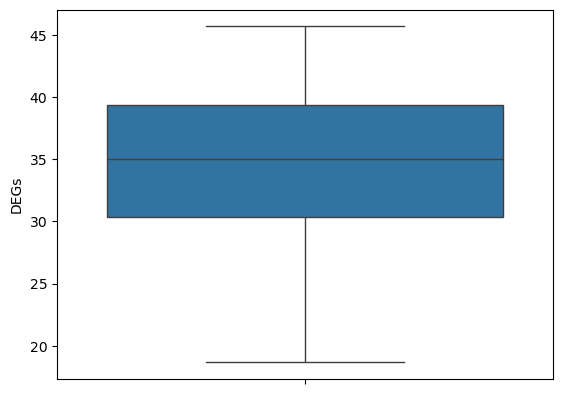

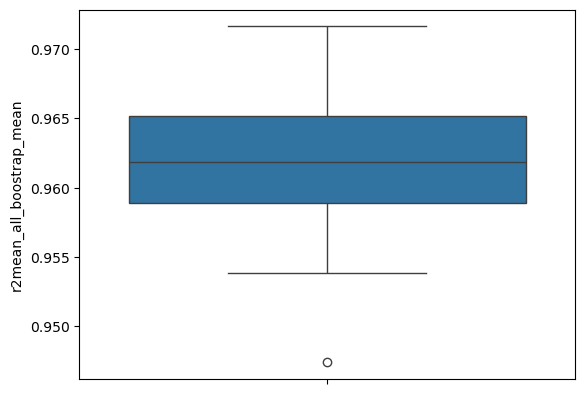

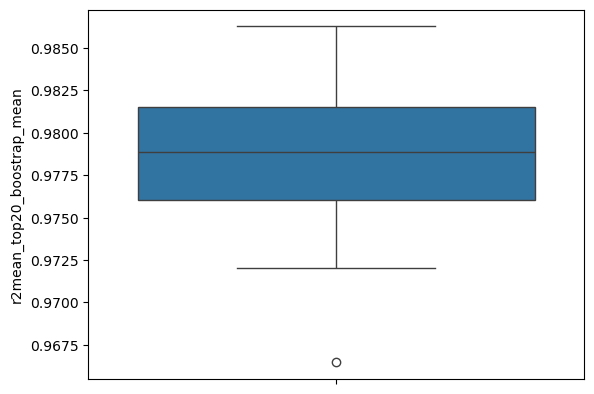

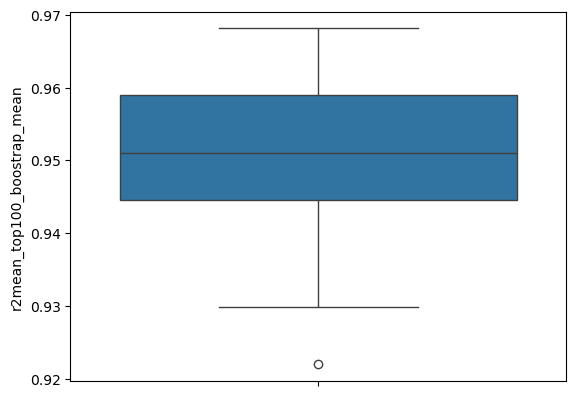

best cell type common {'dosage_0_03_0_1_0_3_1_0_3_0', 'dosage_0_03_0_3_1_0_3_0', 'dosage_0_01_0_03_0_3_1_0_3_0', 'dosage_0_1_0_3_1_0_3_0_10_0_30_0', 'dosage_0_01_0_1_0_3_1_0_3_0', 'dosage_1_0_10_0', 'dosage_1_0_3_0_10_0', 'dosage_0_03_1_0_3_0', 'dosage_0_3_1_0_3_0', 'dosage_0_1_1_0_3_0', 'dosage_0_01_0_03_0_3_1_0_10_0', 'dosage_0_3_1_0_10_0_30_0'}
worst cell type common {'dosage_0_03_0_1_0_3_1_0_30_0', 'dosage_0_01_0_03_1_0_10_0', 'dosage_0_03_1_0_30_0', 'dosage_0_01_0_03_0_1_1_0_3_0_10_0_30_0'}


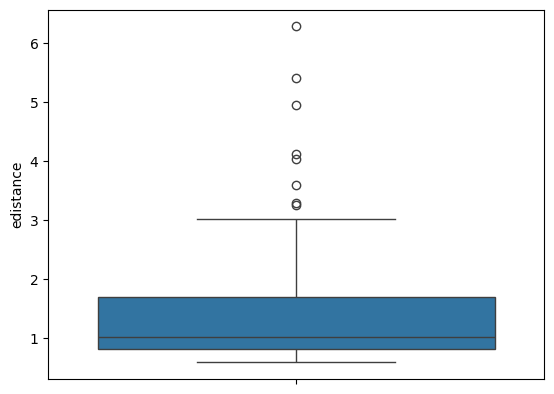

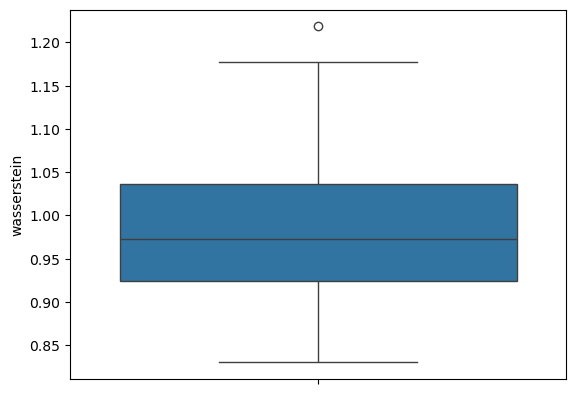

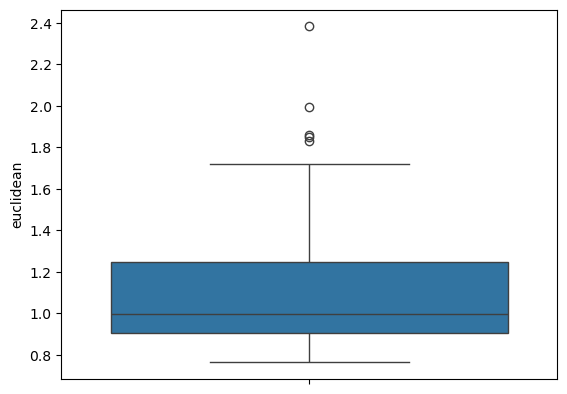

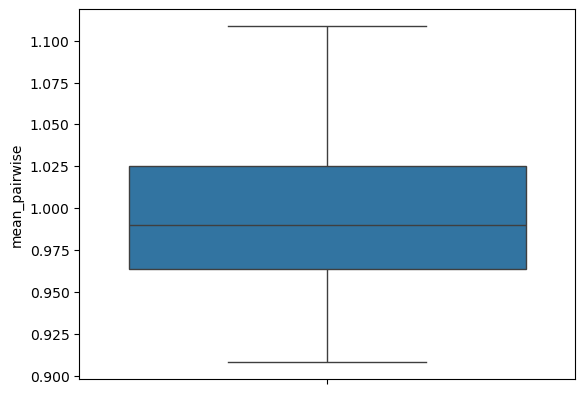

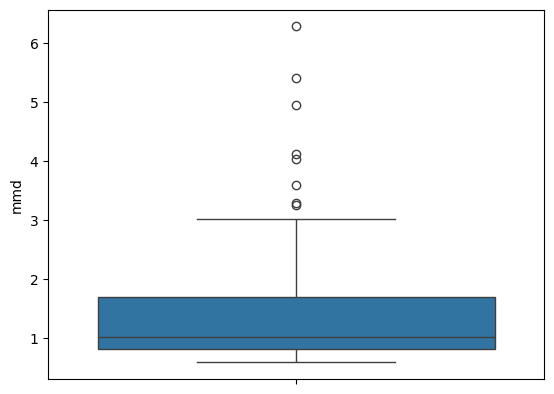

best cell type common {'dosage_1_0_3_0_30_0', 'dosage_0_01_0_03_1_0_10_0_30_0', 'dosage_0_01_0_03_0_3_1_0_3_0_30_0', 'dosage_0_01_0_03_0_1_1_0_30_0', 'dosage_0_03_0_1_0_3_1_0_30_0', 'dosage_1_0_3_0_10_0_30_0', 'dosage_0_01_0_03_0_1_1_0', 'dosage_0_03_0_1_1_0_3_0', 'dosage_0_3_1_0_3_0_30_0', 'dosage_0_01_0_3_1_0_3_0_30_0', 'dosage_0_01_0_1_1_0_3_0_30_0', 'dosage_0_01_0_1_1_0_3_0_10_0_30_0', 'dosage_0_01_0_03_0_3_1_0_3_0', 'dosage_0_3_1_0_30_0', 'dosage_0_01_0_1_0_3_1_0_3_0', 'dosage_0_1_1_0_10_0_30_0', 'dosage_0_03_1_0_3_0_30_0', 'dosage_0_01_0_03_0_1_1_0_3_0_30_0', 'dosage_0_03_0_3_1_0_3_0_30_0', 'dosage_0_01_0_03_0_1_0_3_1_0_3_0', 'dosage_0_01_0_1_0_3_1_0_3_0_30_0', 'dosage_0_01_0_03_0_3_1_0_30_0', 'dosage_0_01_0_03_0_1_1_0_3_0', 'dosage_0_1_1_0_3_0_30_0', 'dosage_0_03_0_1_0_3_1_0_3_0_30_0', 'dosage_0_1_0_3_1_0_3_0_10_0', 'dosage_0_01_0_03_0_1_0_3_1_0_3_0_10_0_30_0', 'dosage_0_01_0_03_1_0_3_0_30_0', 'dosage_0_01_0_1_0_3_1_0', 'dosage_0_01_0_03_0_3_1_0', 'dosage_0_03_0_3_1_0_10_0_30_0'

/tmp/ipykernel_1252850/2794771108.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset["model"] = agg_dataset["model"]
/tmp/ipykernel_1252850/2794771108.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset[metric] = agg_dataset[metric]
/tmp/ipykernel_1252850/2794771108.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-do

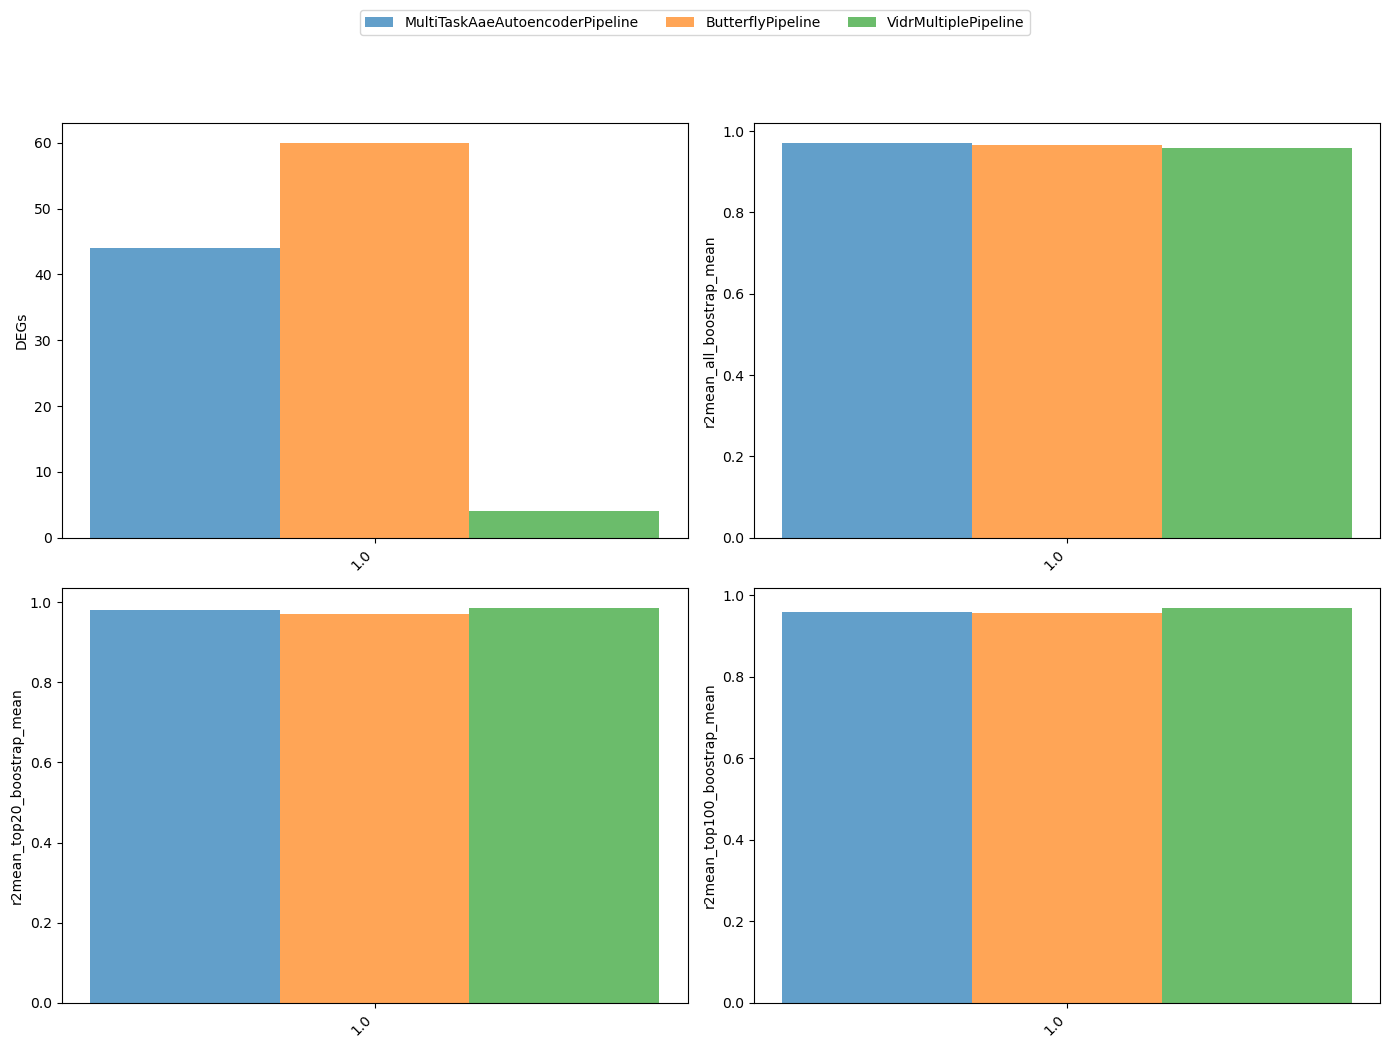

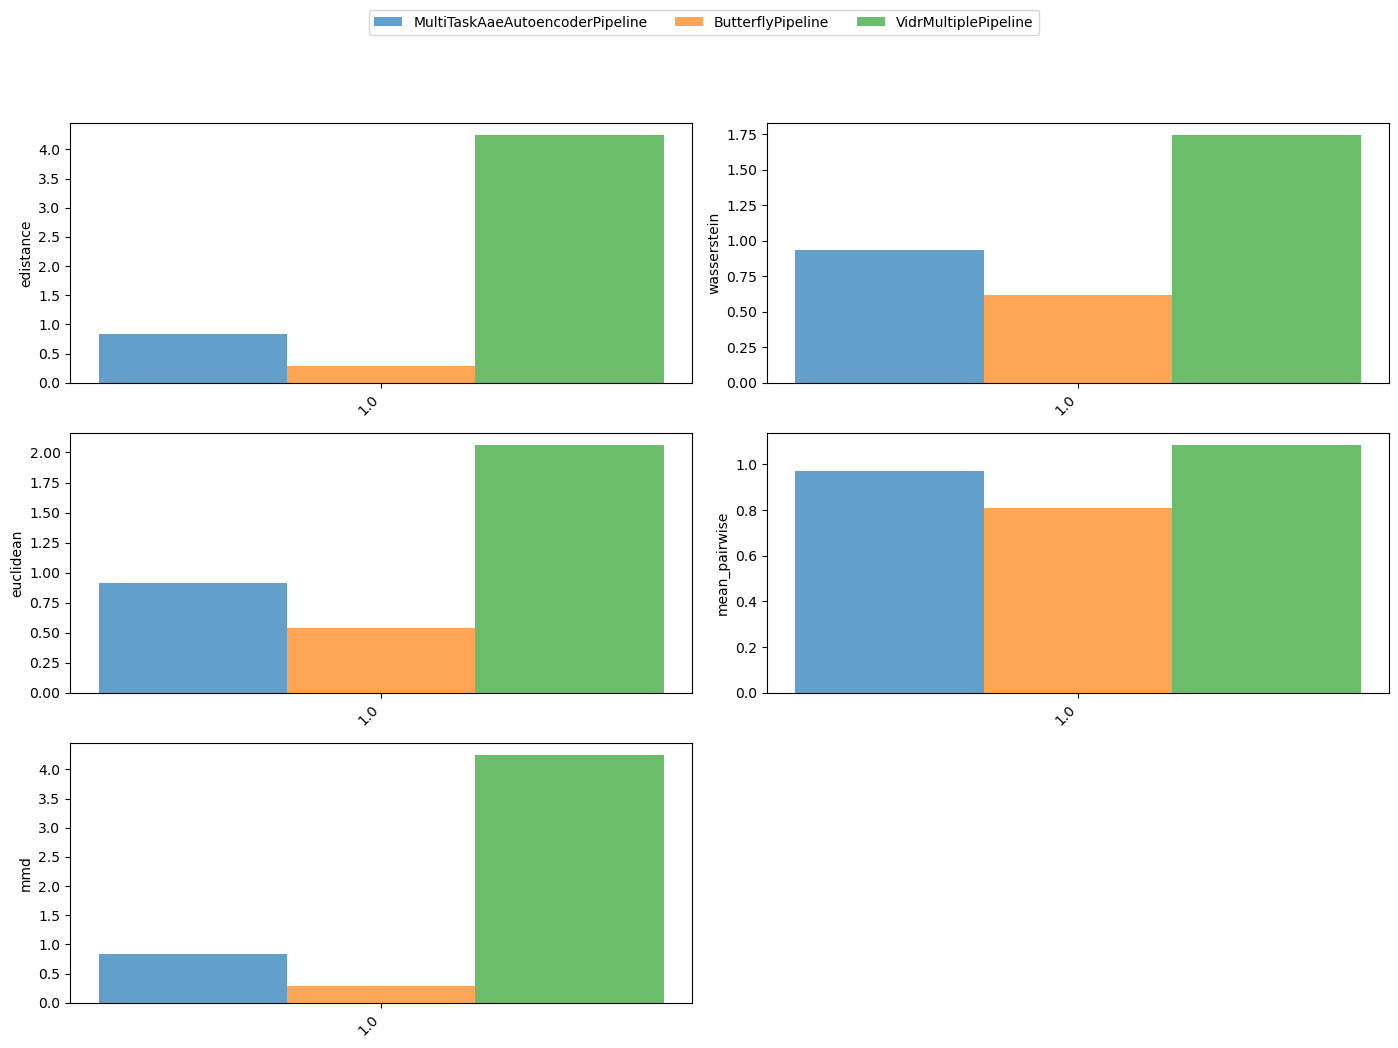

In [251]:
compare_multi_task_with_other_models(dose_to_test=1, best_threshold=50, worst_threshold=30)


['Hepatocytes - portal']


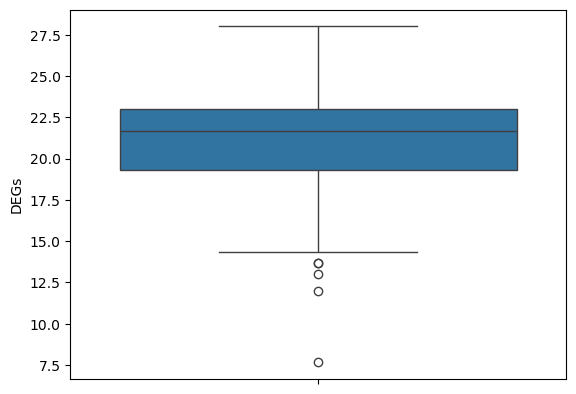

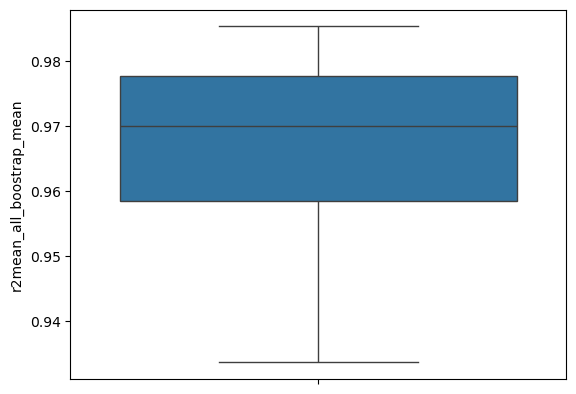

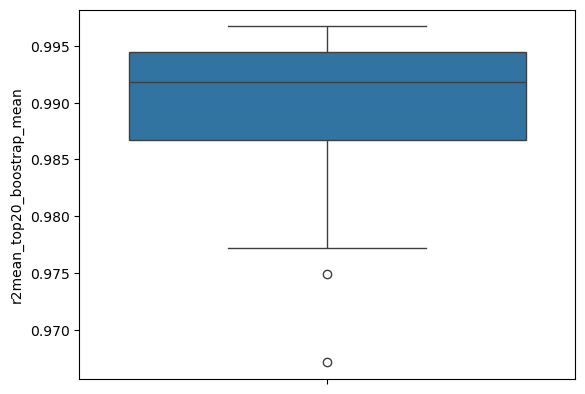

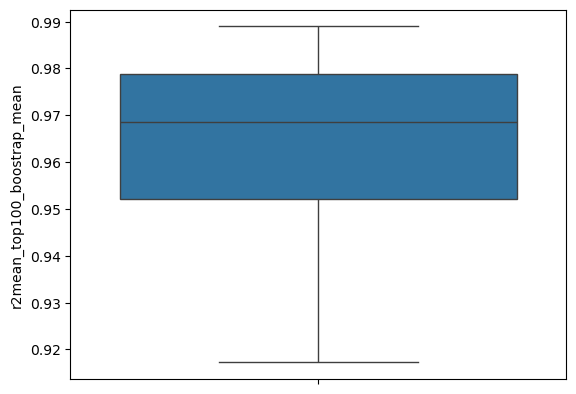

best cell type common {'dosage_0_01_0_3_3_0', 'dosage_0_01_0_03_0_3_1_0_3_0_10_0', 'dosage_0_01_0_3_1_0_10_0', 'dosage_0_01_0_1_0_3_1_0_10_0', 'dosage_0_01_0_03_0_1_0_3_3_0_10_0', 'dosage_0_3_3_0_10_0', 'dosage_0_03_0_3_3_0', 'dosage_0_01_0_03_0_1_0_3_1_0', 'dosage_0_03_0_1_0_3_1_0', 'dosage_0_03_0_1_0_3_3_0_10_0', 'dosage_0_1_0_3_1_0_10_0', 'dosage_0_3_1_0_10_0', 'dosage_0_3_3_0', 'dosage_0_01_0_03_0_3_1_0_10_0', 'dosage_0_01_0_03_0_1_0_3_1_0_3_0_10_0', 'dosage_0_03_0_3_1_0_10_0_30_0', 'dosage_0_03_0_3_3_0_10_0'}
worst cell type common {'dosage_0_01_0_3_1_0_10_0_30_0', 'dosage_0_01_0_03_0_1_0_3_3_0_30_0', 'dosage_0_1_0_3_1_0_3_0_10_0_30_0', 'dosage_0_01_0_03_0_1_0_3_30_0', 'dosage_0_01_0_3_10_0_30_0', 'dosage_0_01_0_03_0_3_10_0_30_0'}


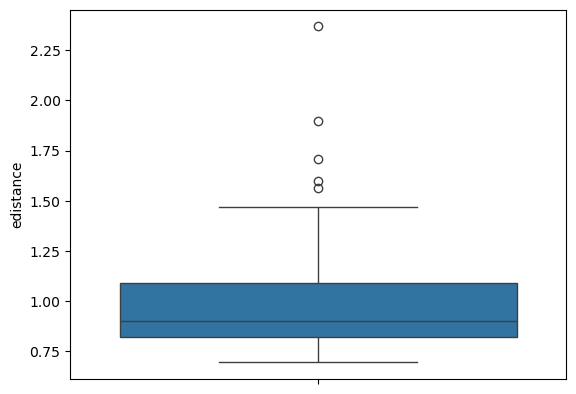

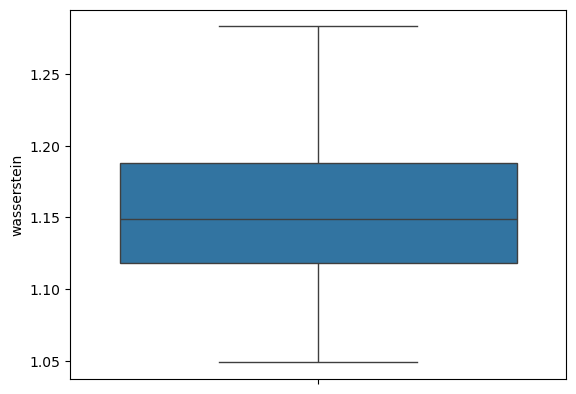

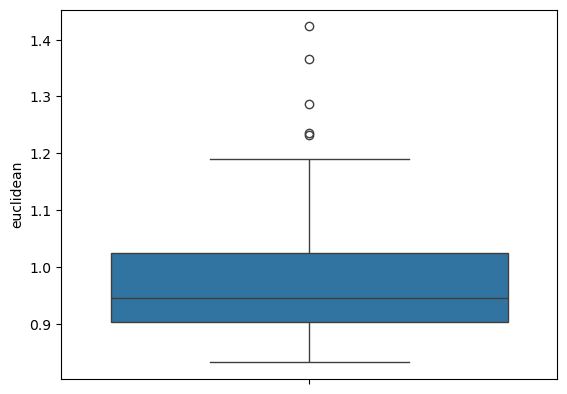

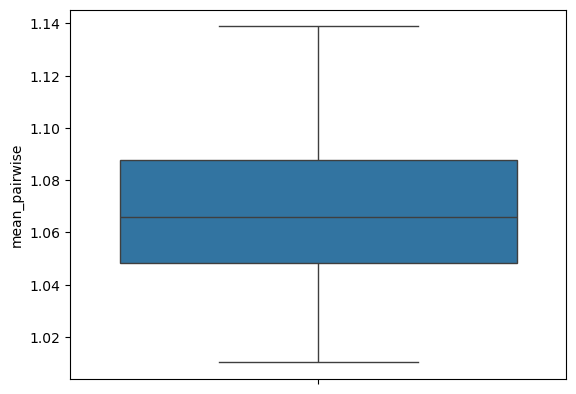

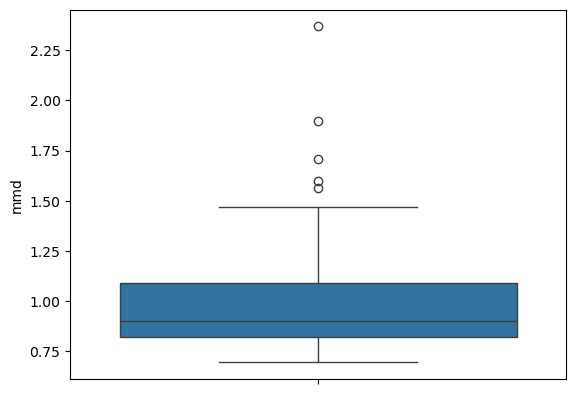

best cell type common {'dosage_0_1_0_3_1_0_10_0_30_0', 'dosage_0_01_0_03_0_3_1_0_3_0_30_0', 'dosage_0_03_0_3_1_0_30_0', 'dosage_0_03_0_1_0_3_1_0', 'dosage_0_03_0_1_0_3_1_0_3_0_10_0_30_0', 'dosage_0_3_1_0_3_0_30_0', 'dosage_0_01_0_3_1_0_3_0_30_0', 'dosage_0_01_0_1_0_3_30_0', 'dosage_0_01_0_1_0_3_1_0_10_0_30_0', 'dosage_0_01_0_03_0_3_1_0_3_0', 'dosage_0_01_0_1_0_3_1_0_3_0', 'dosage_0_03_0_1_0_3', 'dosage_0_03_0_1_0_3_3_0_30_0', 'dosage_0_03_0_3_1_0_3_0_30_0', 'dosage_0_01_0_03_0_1_0_3_1_0_3_0', 'dosage_0_01_0_03_0_3_10_0_30_0', 'dosage_0_03_0_3_3_0_30_0', 'dosage_0_01_0_03_0_3_3_0_10_0_30_0', 'dosage_0_01_0_1_0_3_1_0_3_0_30_0', 'dosage_0_01_0_03_0_1_0_3_3_0_30_0', 'dosage_0_03_0_1_0_3_1_0_3_0_30_0', 'dosage_0_03_0_1_0_3_1_0_10_0_30_0', 'dosage_0_1_0_3_3_0_30_0', 'dosage_0_01_0_3_3_0_30_0', 'dosage_0_01_0_1_0_3_3_0_30_0', 'dosage_0_03_0_1_0_3_3_0', 'dosage_0_01_0_1_0_3_1_0', 'dosage_0_3_1_0_10_0_30_0', 'dosage_0_01_0_03_0_1_0_3_3_0', 'dosage_0_1_0_3_1_0_3_0_30_0', 'dosage_0_01_0_03_0_3_30

/tmp/ipykernel_1252850/2794771108.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset["model"] = agg_dataset["model"]
/tmp/ipykernel_1252850/2794771108.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset[metric] = agg_dataset[metric]
/tmp/ipykernel_1252850/2794771108.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-do

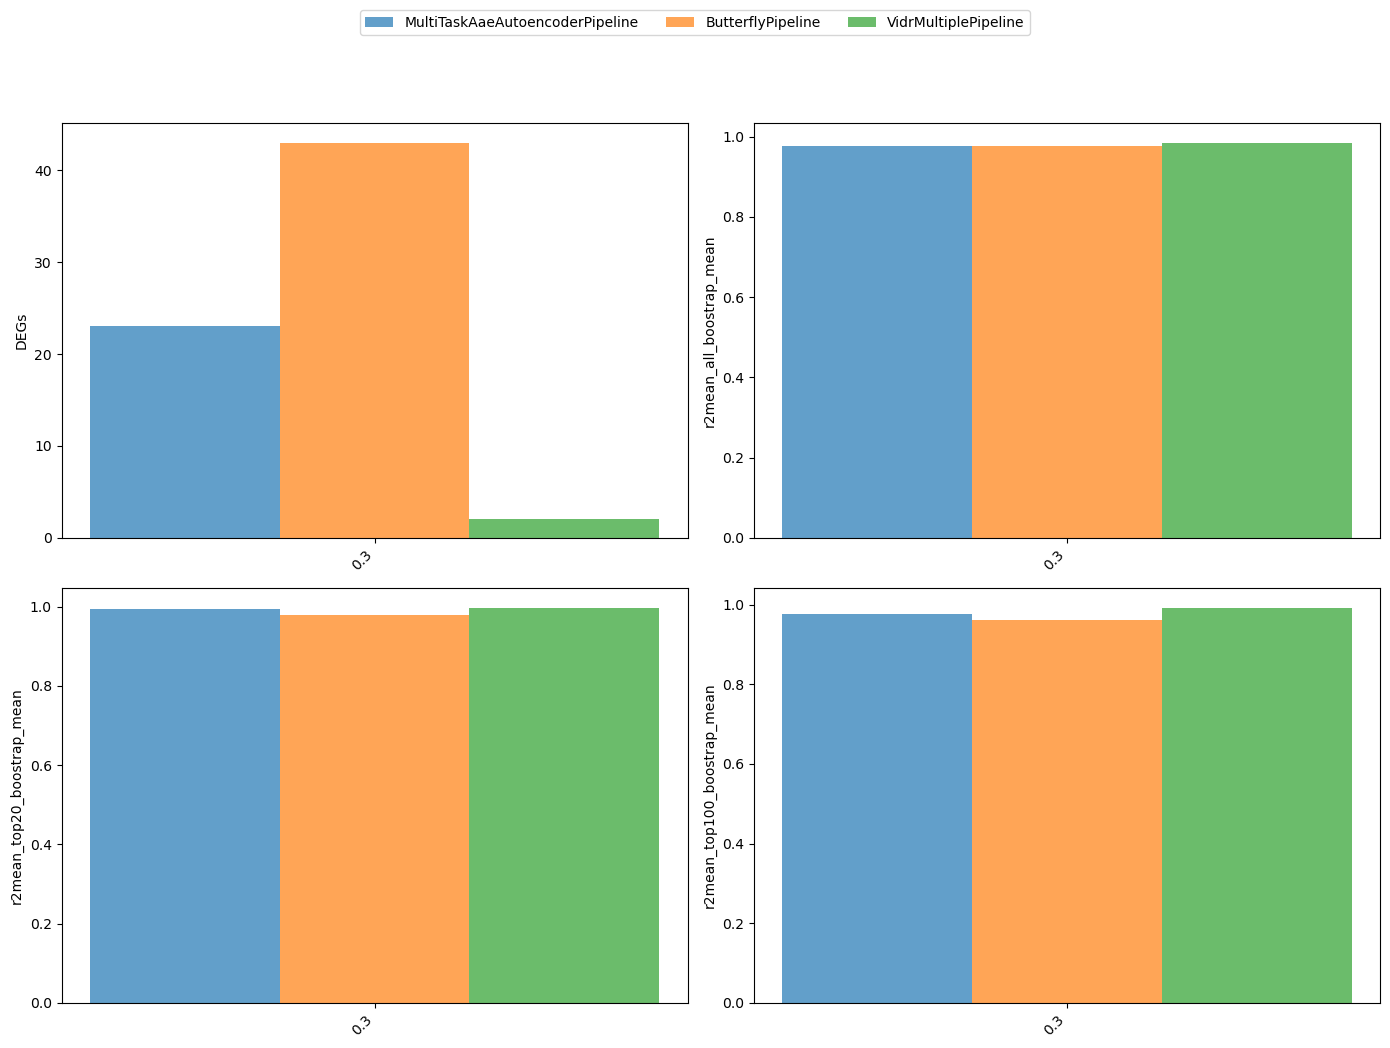

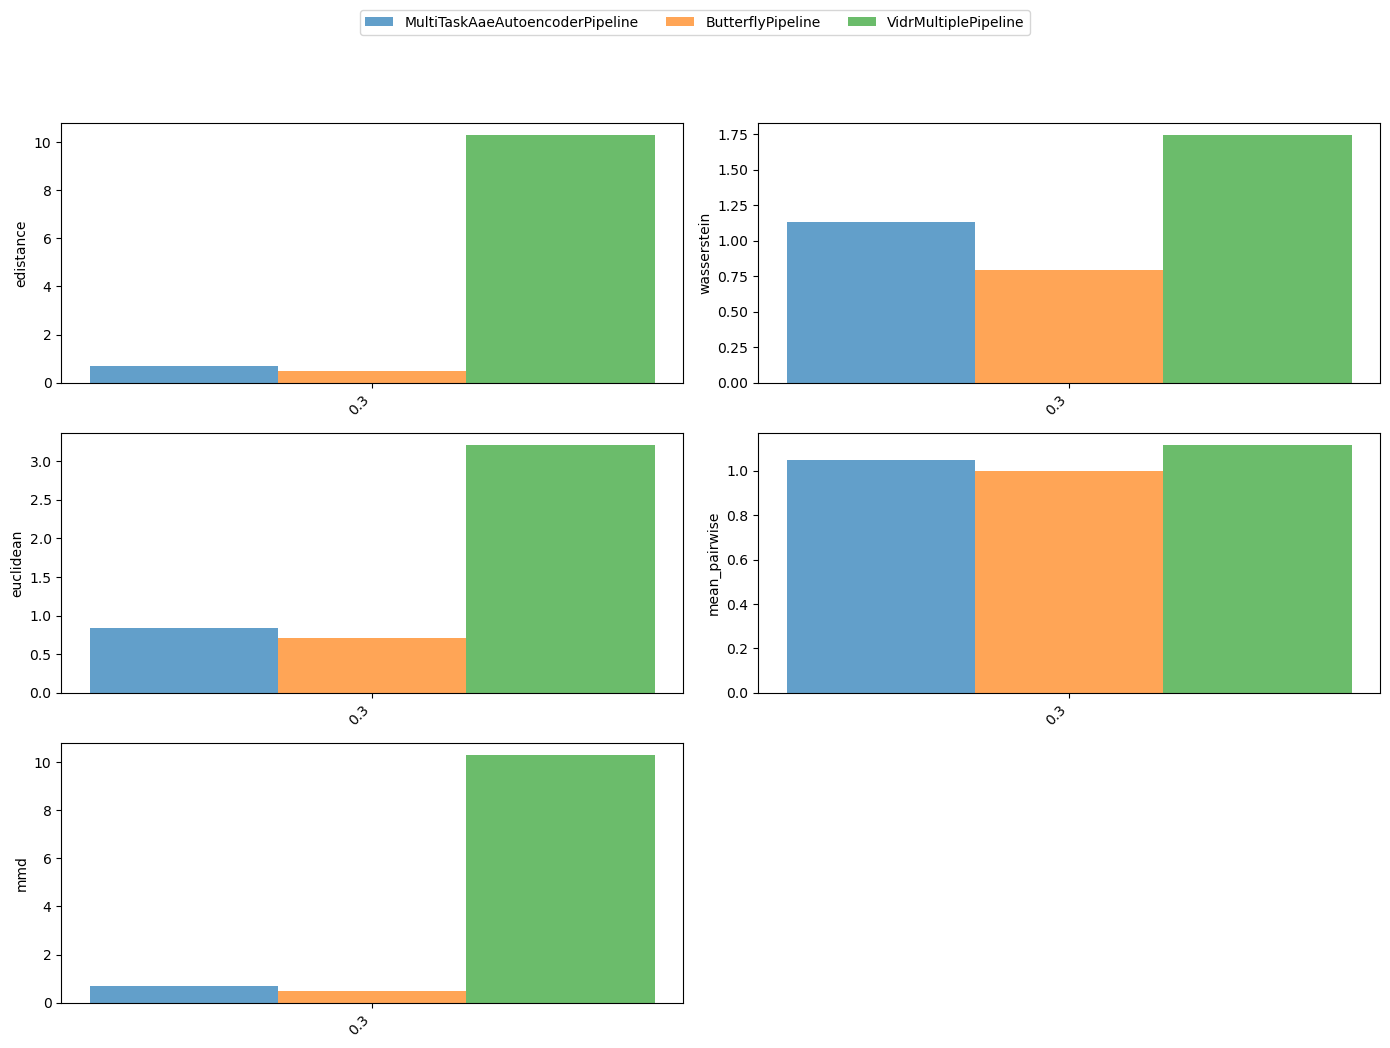

In [255]:
compare_multi_task_with_other_models(dose_to_test=0.3, best_threshold=50, worst_threshold=30)


['Hepatocytes - portal']


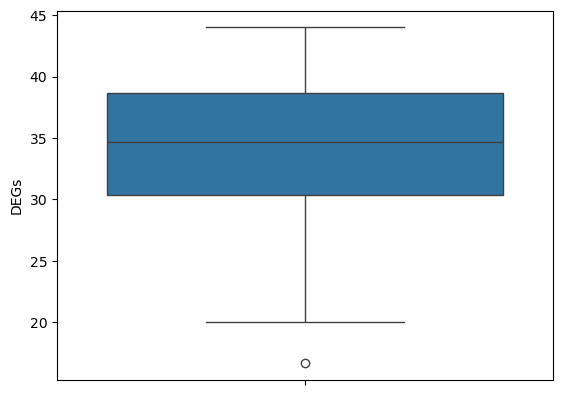

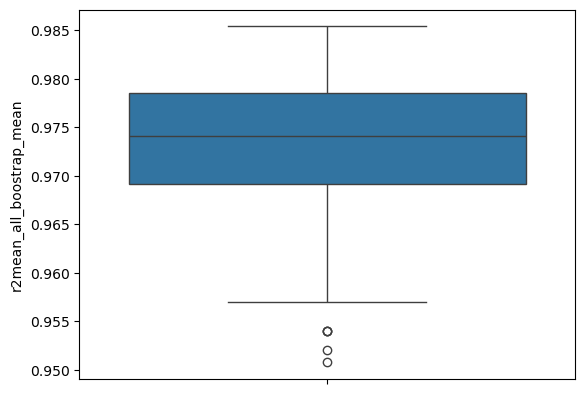

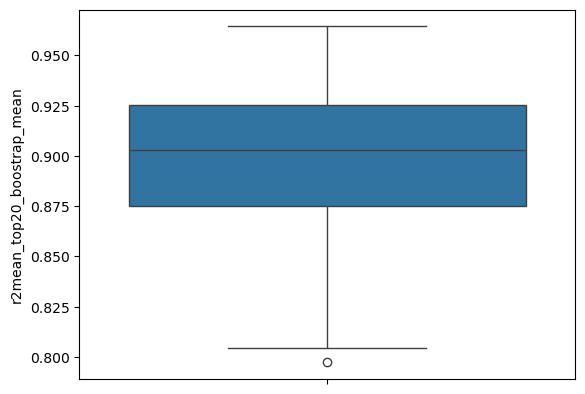

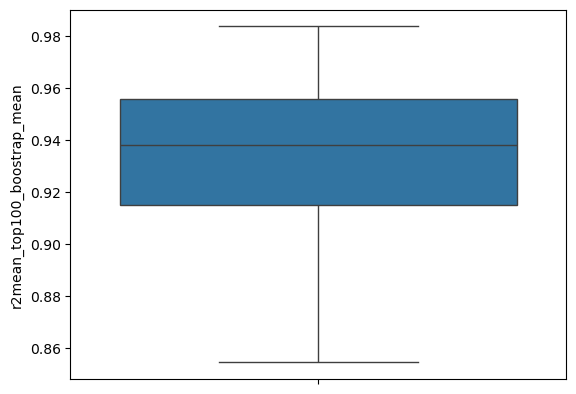

best cell type common {'dosage_0_01_0_1_1_0_3_0_10_0', 'dosage_0_01_0_03_0_1_0_3_3_0_10_0', 'dosage_0_1_0_3_1_0', 'dosage_0_01_0_1_0_3_1_0_3_0_10_0_30_0', 'dosage_0_1', 'dosage_0_03_0_1_0_3_1_0_3_0_10_0_30_0', 'dosage_0_03_0_1_3_0', 'dosage_0_03_0_1_1_0_3_0_10_0_30_0', 'dosage_0_01_0_1_1_0_3_0_10_0_30_0', 'dosage_0_1_0_3_10_0_30_0', 'dosage_0_1_0_3_3_0_10_0', 'dosage_0_1_10_0', 'dosage_0_1_1_0_10_0_30_0', 'dosage_0_01_0_1_3_0_10_0', 'dosage_0_03_0_1_0_3_10_0', 'dosage_0_01_0_03_0_1_1_0_3_0', 'dosage_0_1_0_3_1_0_3_0_10_0', 'dosage_0_01_0_1_10_0', 'dosage_0_03_0_1_0_3_1_0_3_0_10_0', 'dosage_0_1_0_3_3_0_10_0_30_0', 'dosage_0_01_0_1_1_0_3_0', 'dosage_0_1_0_3_1_0_3_0_10_0_30_0', 'dosage_0_01_0_03_0_1_0_3_1_0_10_0', 'dosage_0_1_0_3_1_0_10_0', 'dosage_0_1_1_0_3_0', 'dosage_0_1_0_3_10_0'}
worst cell type common {'dosage_0_03_0_1_1_0_10_0_30_0', 'dosage_0_03_0_1_1_0_30_0', 'dosage_0_03_0_1_0_3_3_0_30_0', 'dosage_0_1_0_3_30_0', 'dosage_0_1_0_3_1_0_30_0', 'dosage_0_1_3_0_10_0_30_0', 'dosage_0_03_

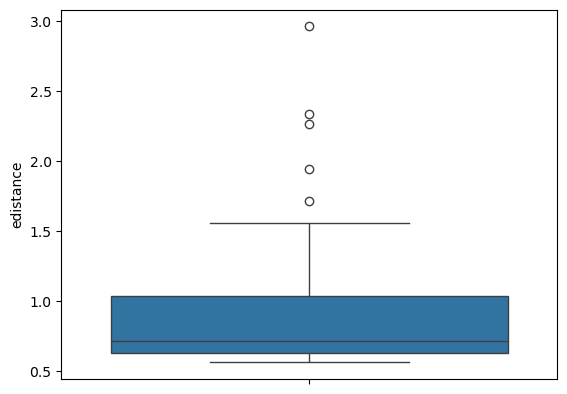

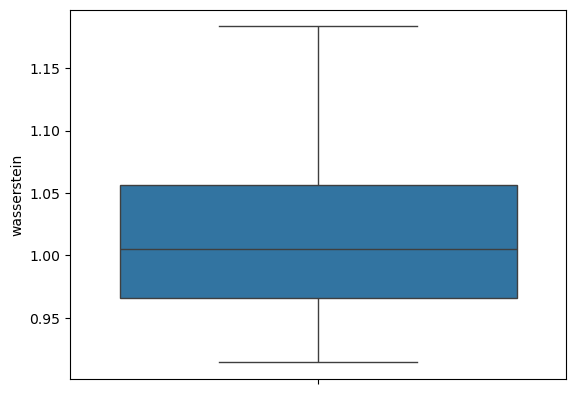

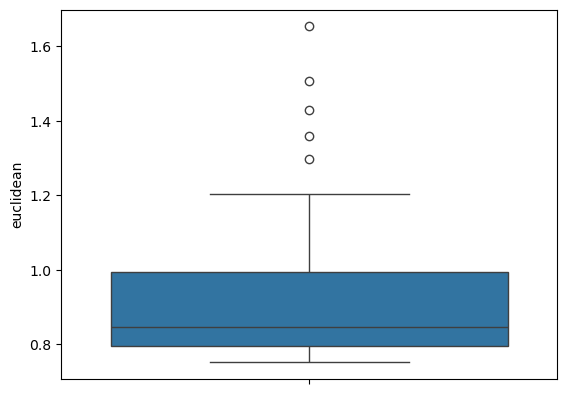

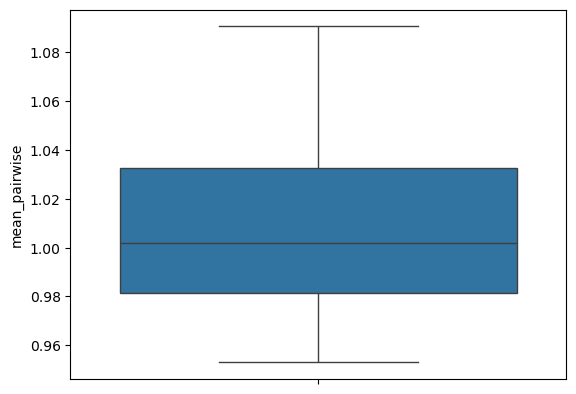

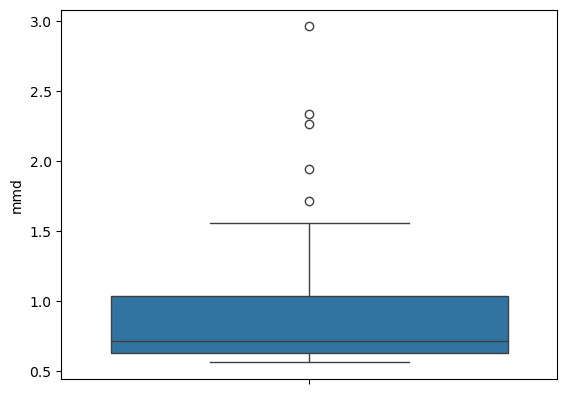

best cell type common {'dosage_0_01_0_1', 'dosage_0_03_0_1_1_0_10_0_30_0', 'dosage_0_01_0_03_0_1_3_0', 'dosage_0_01_0_03_0_1_0_3', 'dosage_0_1_1_0_30_0', 'dosage_0_01_0_1_10_0_30_0', 'dosage_0_01_0_03_0_1_1_0_30_0', 'dosage_0_01_0_1_1_0_10_0', 'dosage_0_03_0_1_0_3_1_0_30_0', 'dosage_0_03_0_1_0_3_1_0', 'dosage_0_03_0_1_30_0', 'dosage_0_1_30_0', 'dosage_0_01_0_1_1_0', 'dosage_0_01_0_03_0_1_1_0', 'dosage_0_03_0_1_1_0_3_0', 'dosage_0_03_0_1_0_3_10_0_30_0', 'dosage_0_1_10_0_30_0', 'dosage_0_1_3_0_30_0', 'dosage_0_01_0_1_0_3_30_0', 'dosage_0_01_0_1_0_3_1_0_10_0_30_0', 'dosage_0_01_0_1_1_0_3_0_30_0', 'dosage_0_01_0_1_1_0_10_0_30_0', 'dosage_0_01_0_03_0_1_30_0', 'dosage_0_01_0_1_0_3_1_0_3_0', 'dosage_0_03_0_1_0_3', 'dosage_0_03_0_1_1_0', 'dosage_0_03_0_1_0_3_3_0_30_0', 'dosage_0_01_0_03_0_1_1_0_3_0_30_0', 'dosage_0_01_0_1_30_0', 'dosage_0_01_0_03_0_1_1_0_3_0_10_0_30_0', 'dosage_0_01_0_1_3_0_10_0_30_0', 'dosage_0_03_0_1_0_3_1_0_3_0', 'dosage_0_01_0_1_0_3_1_0_3_0_30_0', 'dosage_0_01_0_03_0_1_3_0

/tmp/ipykernel_1252850/2794771108.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset["model"] = agg_dataset["model"]
/tmp/ipykernel_1252850/2794771108.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset[metric] = agg_dataset[metric]
/tmp/ipykernel_1252850/2794771108.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-do

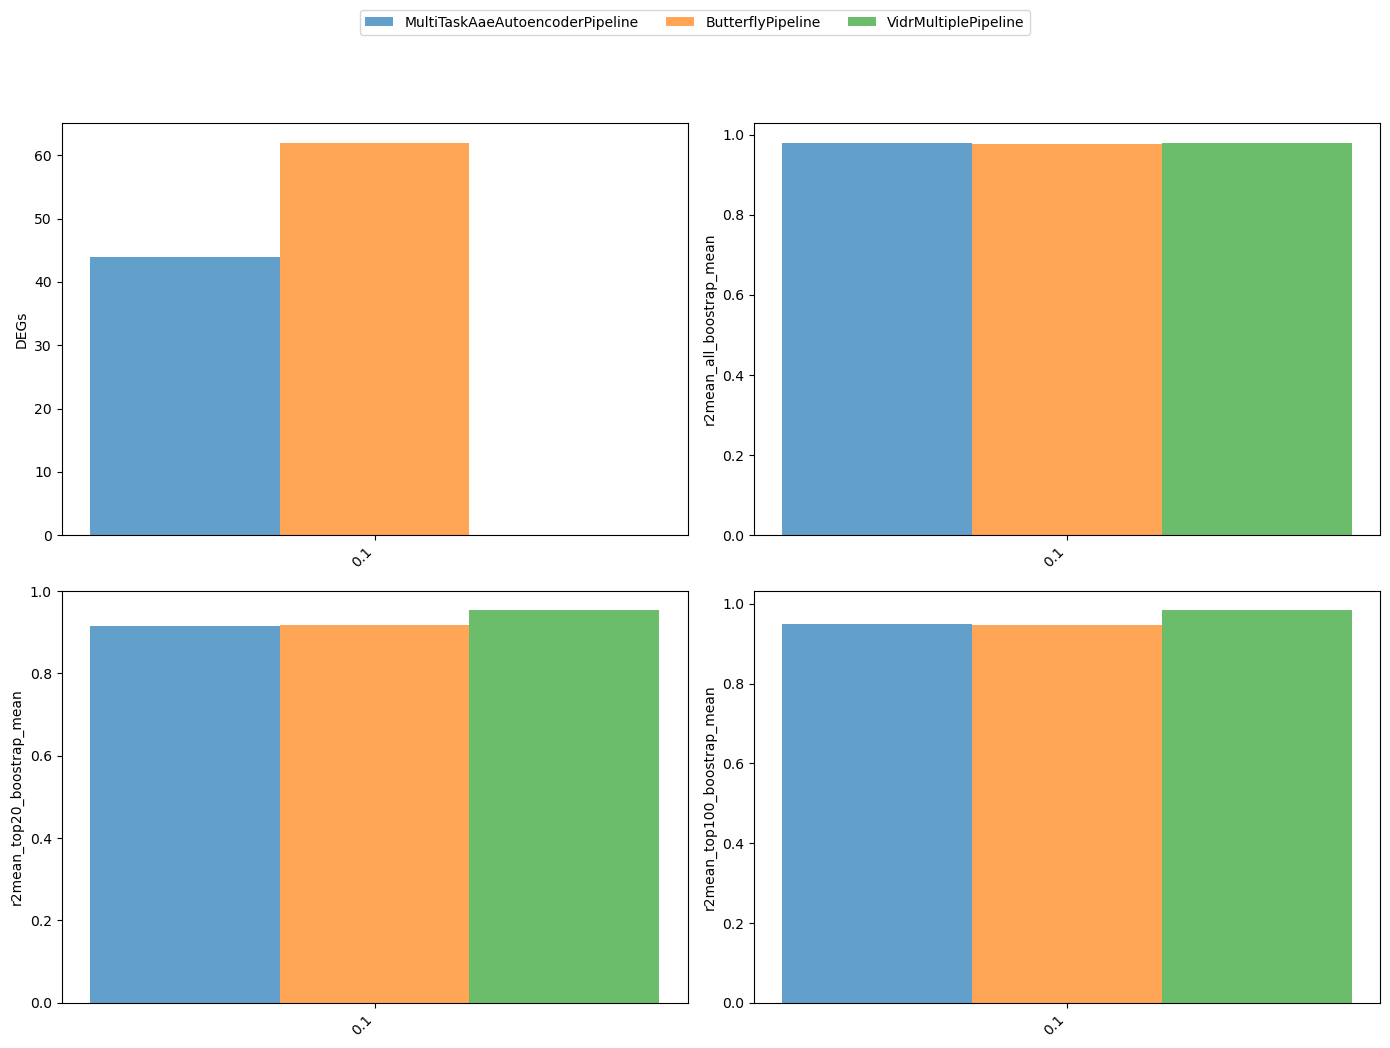

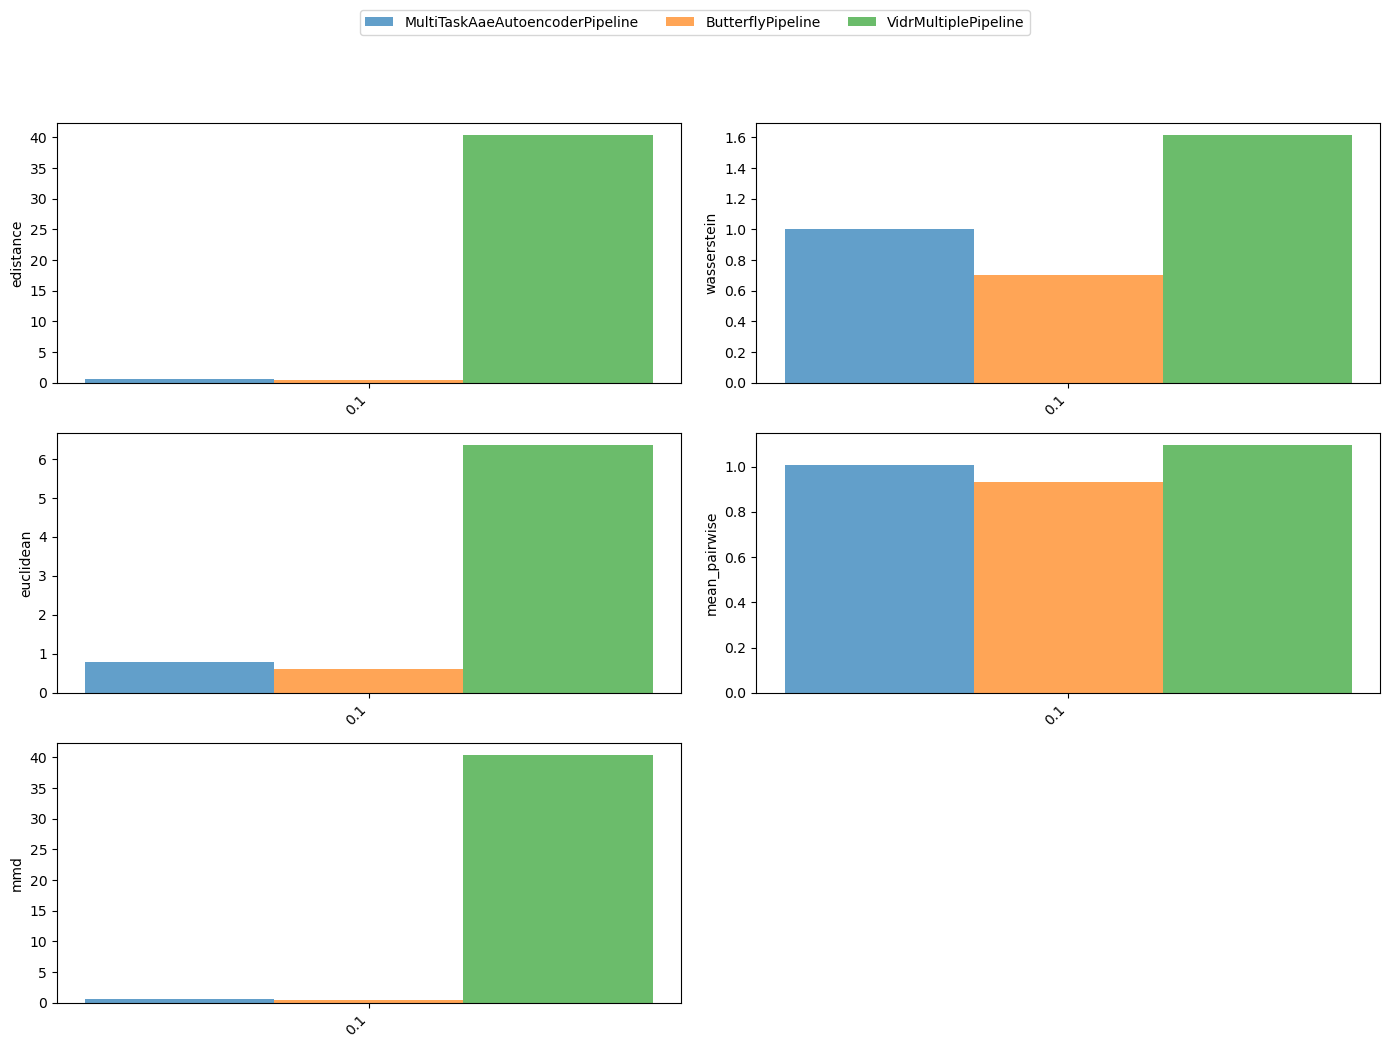

In [258]:
compare_multi_task_with_other_models(dose_to_test=0.1, best_threshold=70, worst_threshold=30)


['Hepatocytes - portal']


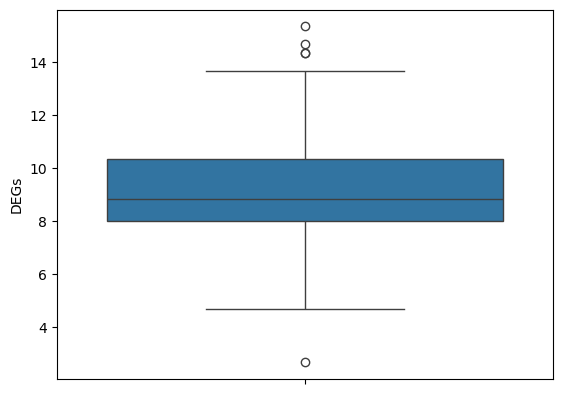

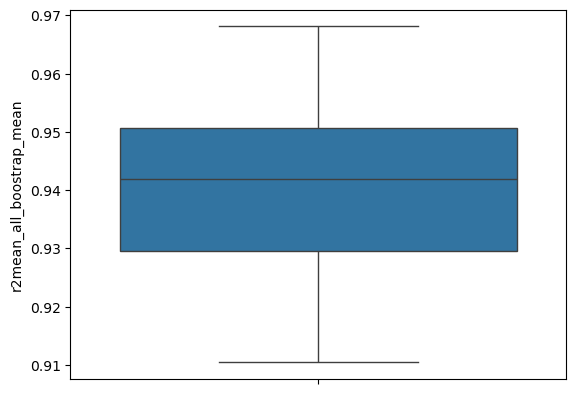

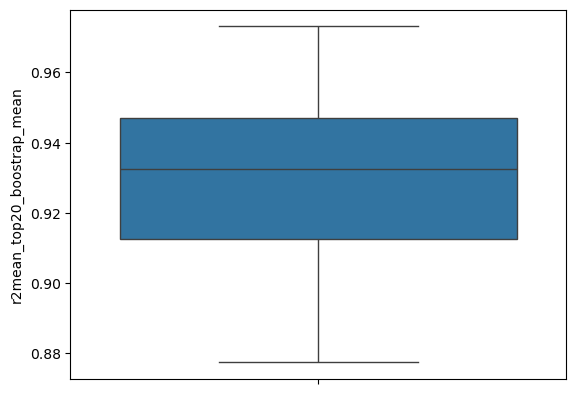

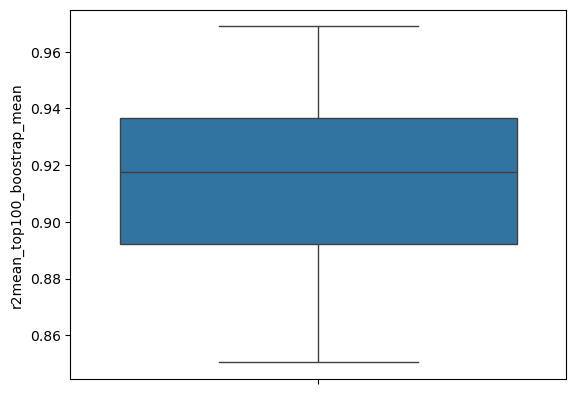

best cell type common {'dosage_0_03_0_3_30_0', 'dosage_0_01_0_03_0_3_10_0', 'dosage_0_01_0_03_0_1_0_3_3_0_10_0', 'dosage_0_03_10_0', 'dosage_0_03_1_0_10_0_30_0', 'dosage_0_03_0_1_1_0_3_0_10_0', 'dosage_0_03_0_3_10_0', 'dosage_0_01_0_03_0_3_3_0', 'dosage_0_03_1_0_3_0_10_0', 'dosage_0_03_0_1_0_3_1_0_3_0_10_0_30_0', 'dosage_0_01_0_03_1_0', 'dosage_0_01_0_03_0_1_1_0_10_0', 'dosage_0_03_0_1_3_0', 'dosage_0_03_0_3_1_0_3_0_10_0', 'dosage_0_01_0_03_1_0_3_0', 'dosage_0_01_0_03_30_0', 'dosage_0_01_0_03_0_3_1_0_10_0_30_0', 'dosage_0_01_0_03_0_3_1_0_3_0', 'dosage_0_01_0_03_3_0', 'dosage_0_01_0_03_0_1_1_0_3_0_10_0_30_0', 'dosage_0_03_0_1_0_3_10_0', 'dosage_0_03_1_0_3_0_10_0_30_0', 'dosage_0_01_0_03_0_1_3_0_10_0', 'dosage_0_03_0_1_10_0', 'dosage_0_03_0_3_1_0_10_0', 'dosage_0_03_0_1_0_3_1_0_10_0_30_0', 'dosage_0_03_1_0_3_0', 'dosage_0_03_3_0', 'dosage_0_01_0_03_0_1_0_3_10_0_30_0', 'dosage_0_03_0_3_3_0_10_0_30_0', 'dosage_0_01_0_03_0_3_1_0_10_0', 'dosage_0_01_0_03_0_1_0_3_1_0_3_0_10_0', 'dosage_0_03_0

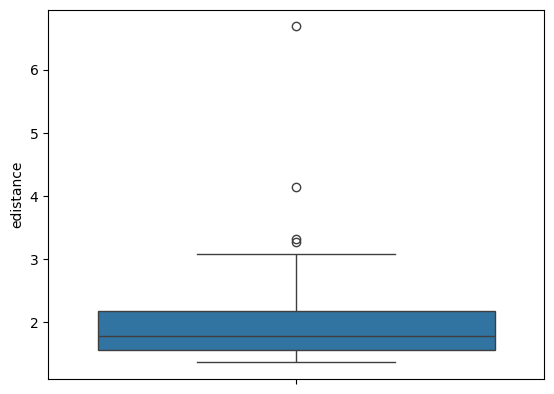

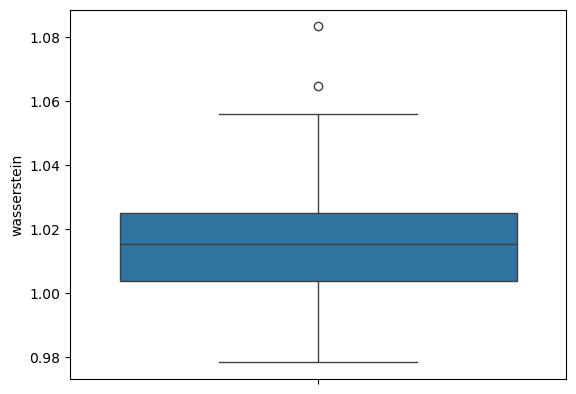

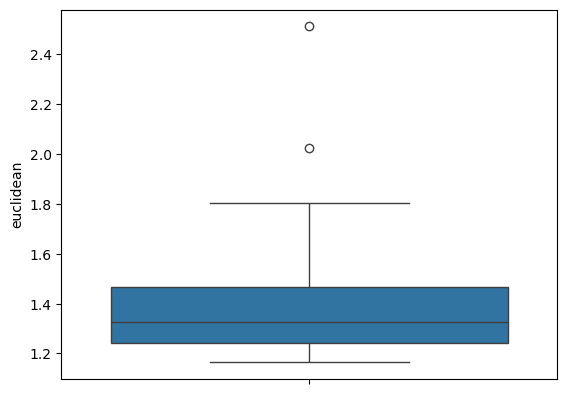

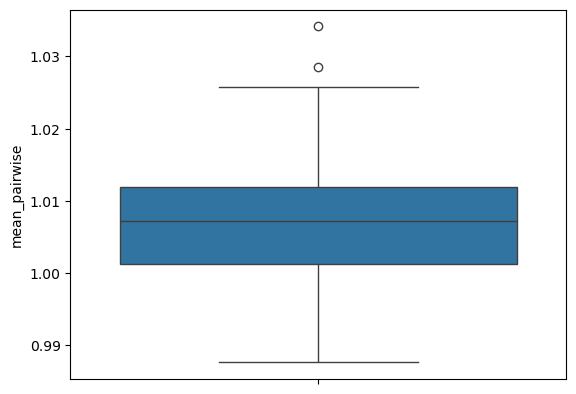

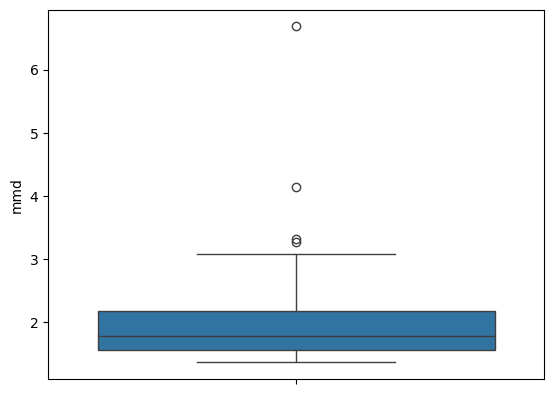

best cell type common {'dosage_0_03_0_1_1_0_10_0', 'dosage_0_01_0_03_0_1_3_0', 'dosage_0_03_0_1_3_0_10_0_30_0', 'dosage_0_03_1_0_10_0', 'dosage_0_01_0_03_0_3_1_0_3_0_30_0', 'dosage_0_03_0_3_1_0_30_0', 'dosage_0_03_3_0_30_0', 'dosage_0_03_0_1_1_0_3_0', 'dosage_0_03_0_1_1_0_3_0_10_0_30_0', 'dosage_0_01_0_03_0_1_1_0_10_0_30_0', 'dosage_0_01_0_03_0_3_1_0_10_0_30_0', 'dosage_0_01_0_03_0_1_30_0', 'dosage_0_03_0_1_0_3', 'dosage_0_03_0_1_0_3_3_0_30_0', 'dosage_0_01_0_03_0_1_1_0_3_0_30_0', 'dosage_0_03_0_3_1_0_3_0_30_0', 'dosage_0_01_0_03_0_1_0_3_1_0_3_0', 'dosage_0_01_0_03_0_3_10_0_30_0', 'dosage_0_03_0_3_3_0_30_0', 'dosage_0_03_10_0_30_0', 'dosage_0_01_0_03_0_3_3_0_10_0_30_0', 'dosage_0_03_0_3', 'dosage_0_01_0_03_0_1_3_0_30_0', 'dosage_0_01_0_03_0_3_1_0_30_0', 'dosage_0_01_0_03_0_1_0_3_3_0_30_0', 'dosage_0_01_0_03_0_1_1_0_3_0', 'dosage_0_01_0_03_3_0_30_0', 'dosage_0_03_0_1_0_3_1_0_3_0_30_0', 'dosage_0_03_0_3_3_0', 'dosage_0_01_0_03_0_1_10_0_30_0', 'dosage_0_01_0_03_0_1_0_3_1_0_3_0_10_0_30_0',

/tmp/ipykernel_1252850/2794771108.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset["model"] = agg_dataset["model"]
/tmp/ipykernel_1252850/2794771108.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset[metric] = agg_dataset[metric]
/tmp/ipykernel_1252850/2794771108.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-do

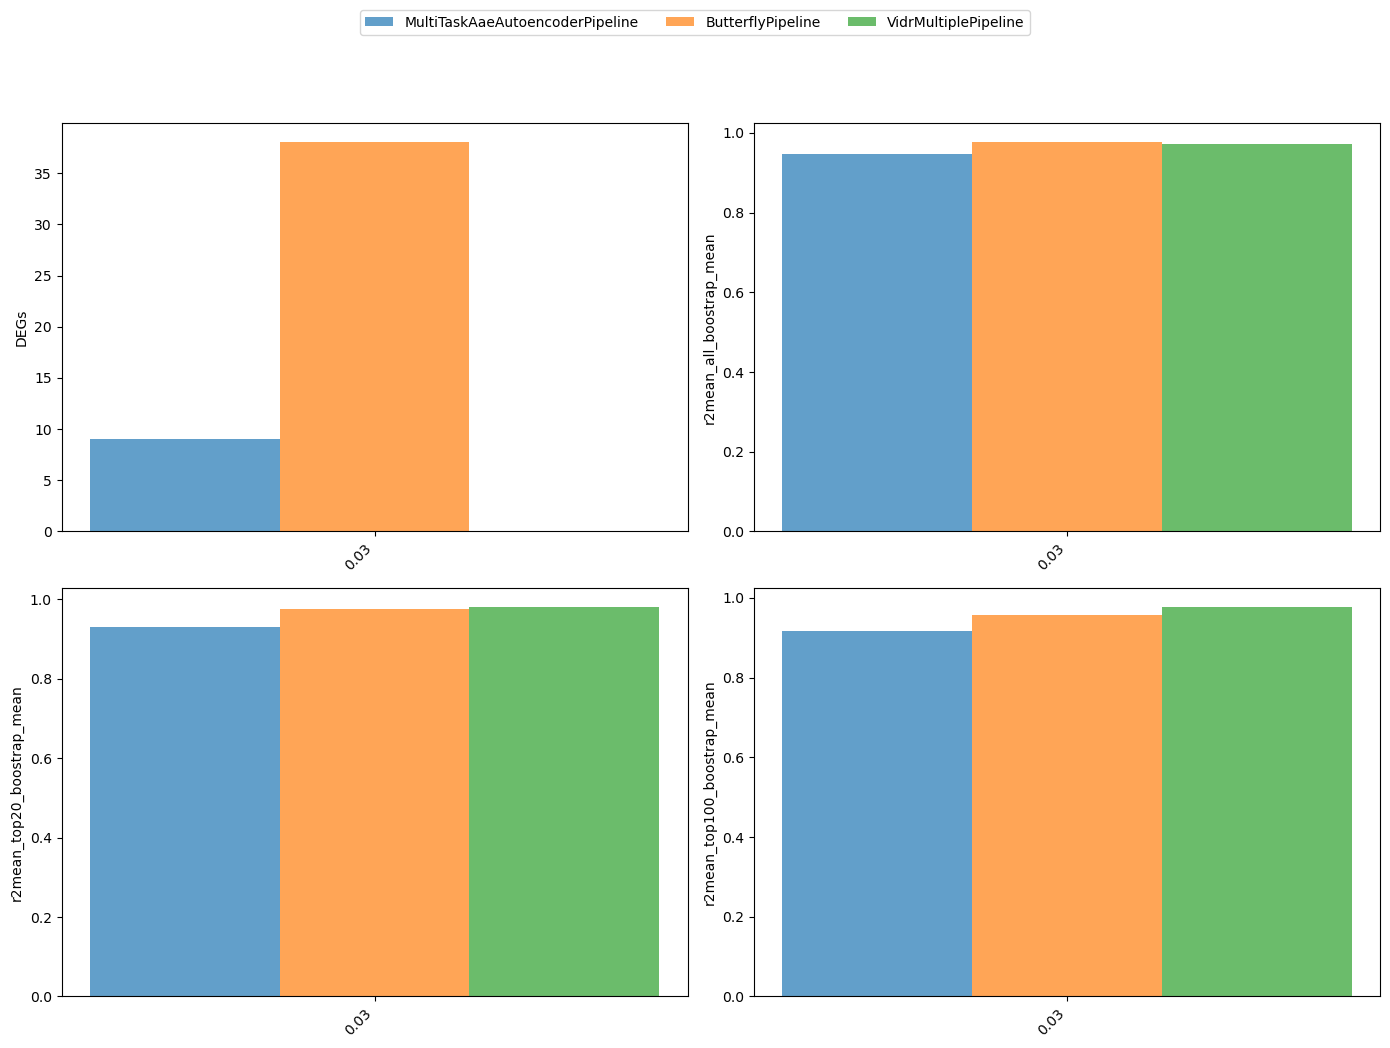

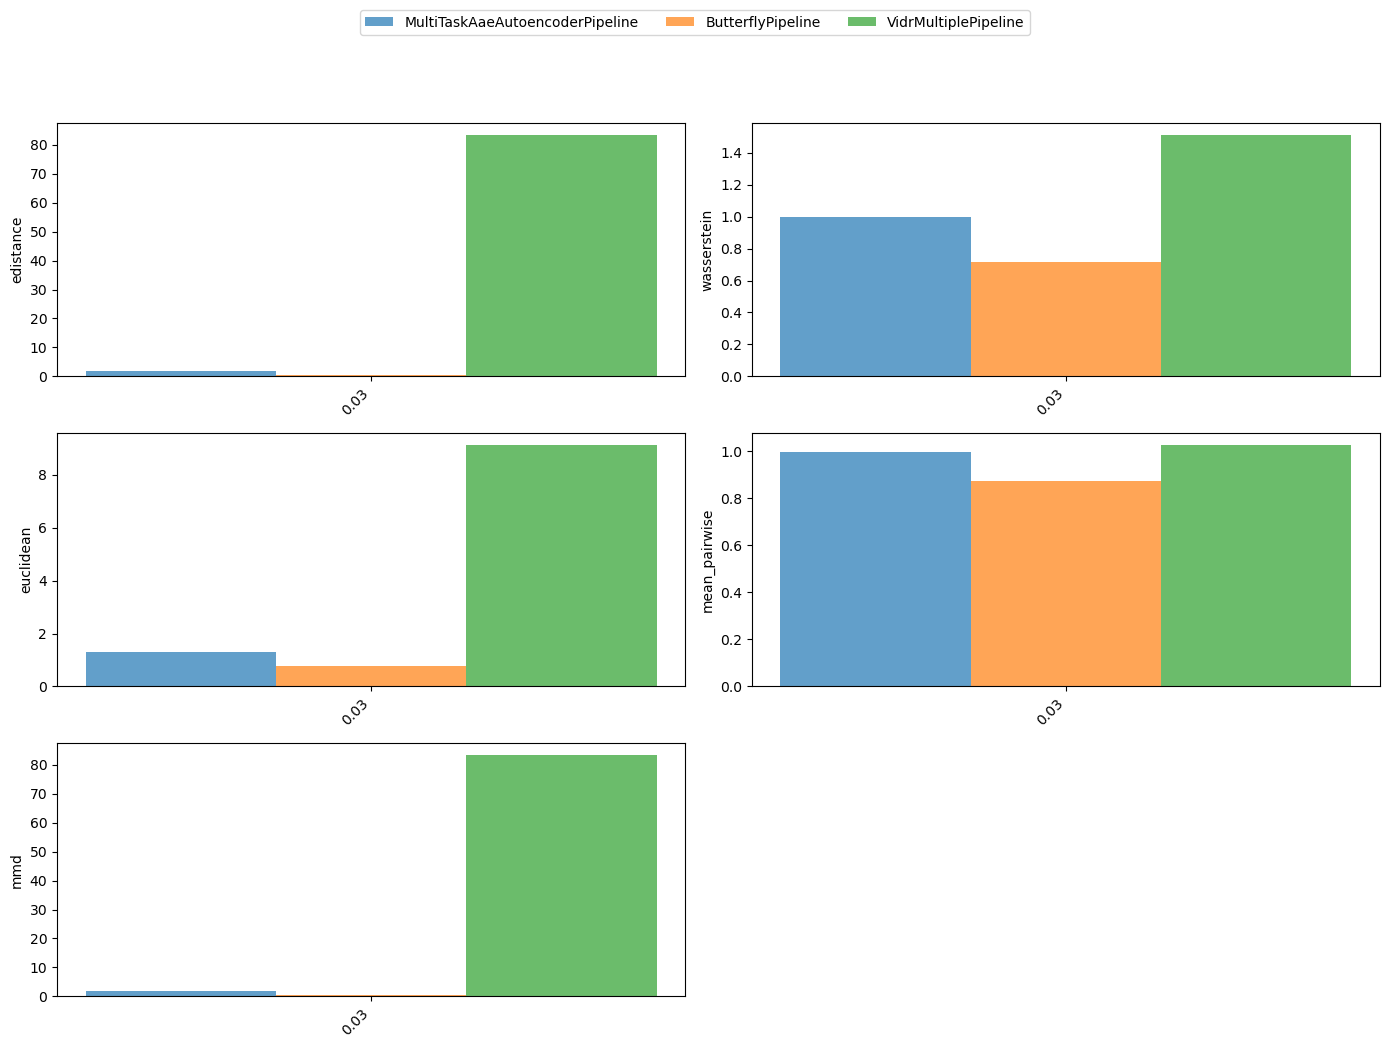

In [260]:
compare_multi_task_with_other_models(dose_to_test=0.03, best_threshold=70, worst_threshold=30)


In [240]:
best_experiment = 'dosage_0_1_0_3_10_0_30_0_19193'
dataset = METRICS_DF[METRICS_DF['experiment_name'] == best_experiment]
dataset

model                              dataset  \
4006  MultiTaskAaeAutoencoderPipeline  NaultMultiplePipeline_NaultPipeline   
4009  MultiTaskAaeAutoencoderPipeline  NaultMultiplePipeline_NaultPipeline   
4012  MultiTaskAaeAutoencoderPipeline  NaultMultiplePipeline_NaultPipeline   
4014  MultiTaskAaeAutoencoderPipeline  NaultMultiplePipeline_NaultPipeline   

                     experiment_name perturbation  dose  DEGs  r2mean  \
4006  dosage_0_1_0_3_10_0_30_0_19193         tcdd   0.1    36   0.980   
4009  dosage_0_1_0_3_10_0_30_0_19193         tcdd   0.3    17   0.956   
4012  dosage_0_1_0_3_10_0_30_0_19193         tcdd  10.0     8   0.746   
4014  dosage_0_1_0_3_10_0_30_0_19193         tcdd  30.0    34   0.687   

      r2mean_top20  r2mean_top100  r2mean_all_boostrap_mean  ...  \
4006         0.968          0.941                  0.979296  ...   
4009         0.970          0.992                  0.956128  ...   
4012         0.719          0.865                  0.746657  ...   
4014         0.801          0.885                  0.687502  ...   

            cell_type_test  average_mean_expressed_diff  \
4006  Hepatocytes - portal                     0.775812   
4009  Hepatocytes - portal                     0.757047   
4012  Hepatocytes - portal                     0.753337   
4014  Hepatocytes - portal                     0.763394   

     average_fractions_diff  average_mean_degs20_diff  \
4006               0.196442                  0.534822   
4009               0.168990                  0.492501   
4012               0.179603                  0.769065   
4014               0.222368                  0.719066   

      average_mean_degs100_diff  edistance  wasserstein  euclidean  \
4006                   0.592332   0.911988     1.072119   0.954980   
4009                   0.579031   1.414555     1.301244   1.189351   
4012                   0.759469  10.891676     2.933340   3.300257   
4014                   0.782867   5.329039     3.217285   2.308473   

      mean_pairwise        mmd  
4006       1.036827   0.911988  
4009       1.145985   1.414555  
4012       1.723637  10.891672  
4014       1.740820   5.329041  

[4 rows x 22 columns]

In [ ]:
best_experiment = 'dosage_0_1_0_3_10_0_30_0_2'
dataset = METRICS_DF[METRICS_DF['experiment_name'] == best_experiment]
dataset

model                              dataset  \
2859  MultiTaskAaeAutoencoderPipeline  NaultMultiplePipeline_NaultPipeline   
2868  MultiTaskAaeAutoencoderPipeline  NaultMultiplePipeline_NaultPipeline   
2876  MultiTaskAaeAutoencoderPipeline  NaultMultiplePipeline_NaultPipeline   
2882  MultiTaskAaeAutoencoderPipeline  NaultMultiplePipeline_NaultPipeline   

                 experiment_name perturbation  dose  DEGs  r2mean  \
2859  dosage_0_1_0_3_10_0_30_0_2         tcdd   0.1    42   0.974   
2868  dosage_0_1_0_3_10_0_30_0_2         tcdd   0.3    22   0.976   
2876  dosage_0_1_0_3_10_0_30_0_2         tcdd  10.0    50   0.906   
2882  dosage_0_1_0_3_10_0_30_0_2         tcdd  30.0    31   0.659   

      r2mean_top20  r2mean_top100  r2mean_all_boostrap_mean  ...  \
2859         0.929          0.834                  0.974188  ...   
2868         0.986          0.996                  0.976366  ...   
2876         0.889          0.949                  0.905540  ...   
2882         0.792          0.876                  0.658684  ...   

            cell_type_test  average_mean_expressed_diff  \
2859  Hepatocytes - portal                     0.770529   
2868  Hepatocytes - portal                     0.786410   
2876  Hepatocytes - portal                     0.806722   
2882  Hepatocytes - portal                     0.755276   

     average_fractions_diff  average_mean_degs20_diff  \
2859               0.206929                  0.449492   
2868               0.201973                  0.492088   
2876               0.278549                  0.522916   
2882               0.205300                  0.740517   

      average_mean_degs100_diff  edistance  wasserstein  euclidean  \
2859                   0.538249   0.593568     0.968018   0.770434   
2868                   0.609185   1.006992     1.197633   1.003490   
2876                   0.617940   0.759428     0.899650   0.871451   
2882                   0.791565  10.502955     4.045522   3.240832   

      mean_pairwise        mmd  
2859       0.981937   0.593568  
2868       1.091901   1.006993  
2876       0.951913   0.759428  
2882       1.963480  10.502946  

[4 rows x 22 columns]

In [242]:
# there is a fair amount of variability by changing the seeds making harder to make any conclusions since the metrics are not consistent